In [1]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 14, 12  # делаем картинки крупнее
%config InlineBackend.figure_format = 'retina'  # делаем картинки красивее

За основу взять [пример из scikit-learn-а](http://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py). Сначала примерно повторим пример.

In [2]:
rng = np.random.RandomState(179179)
# Создаём два кластера "нормальных данных" для обучения
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Создаём ещё данных из этих кластеров для теста 
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Чуть-чуть аномалий, чтоб не расслабляться - тоже для теста
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

In [3]:
# Применим IsolationForest
clf = IsolationForest(100)
clf.fit(X_train)

y_pred_train = clf.decision_function(X_train)
y_pred_test = clf.decision_function(X_test)
y_pred_outliers = clf.decision_function(X_outliers)

In [4]:
# Оценим результат через AUC-ROC, для удобства оформим в качестве функции:
def score(y_pred_test, y_pred_outliers):
    return roc_auc_score(np.append(np.ones((len(y_pred_test))), -np.ones((len(y_pred_outliers)))), np.append(y_pred_test, y_pred_outliers))

score(y_pred_test, y_pred_outliers)

0.96375

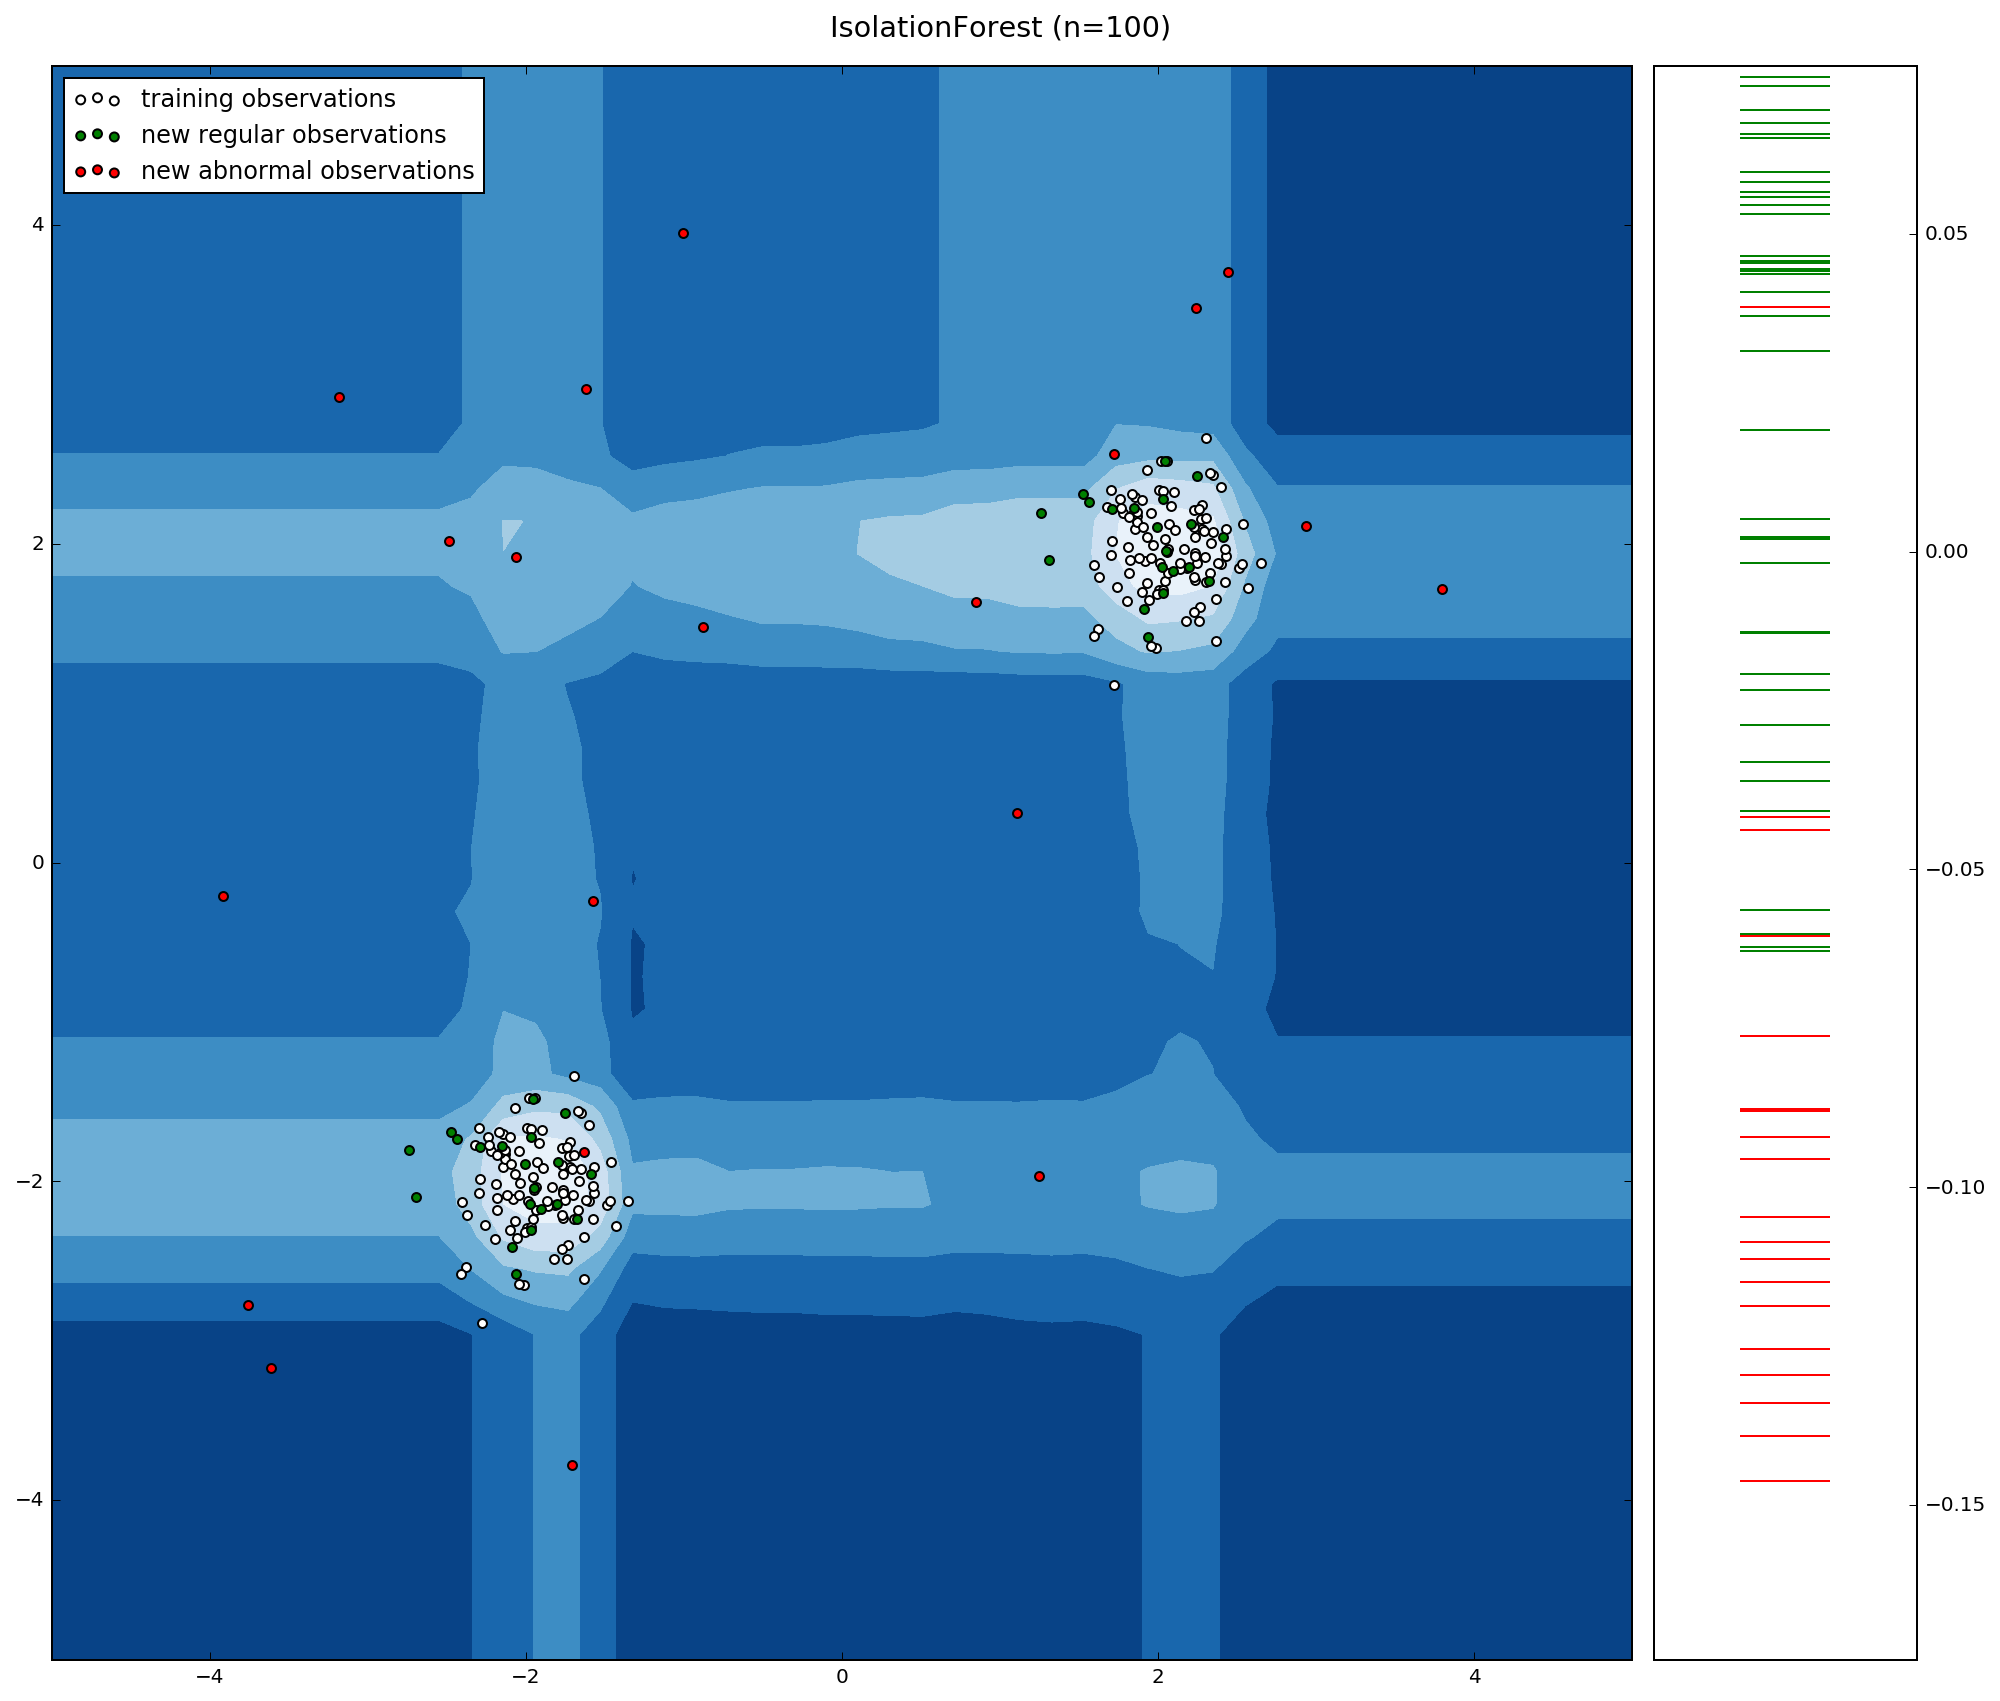

In [5]:
# Построим красивый график, для удобства оформим в качестве функции
def coolPlot(name, decision_func, train=np.empty((0, 2)), test=np.empty((0, 2)), outliers=np.empty((0, 2))):
    rcParams['figure.figsize'] = 14, 12
    f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[6, 1]})
        
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = decision_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax0.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    b1 = ax0.scatter(train[:, 0], train[:, 1], c='white')
    b2 = ax0.scatter(test[:, 0], test[:, 1], c='green')
    c = ax0.scatter(outliers[:, 0], outliers[:, 1], c='red')
    ax0.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
    ax0.axis('tight')
    ax0.set_xlim((-5, 5))
    ax0.set_ylim((-5, 5))
       
    b = ax1.scatter(np.zeros_like(y_pred_test), y_pred_test, marker='_', c='green', s=2000)
    c = ax1.scatter(np.zeros_like(y_pred_outliers), y_pred_outliers, marker='_', c='red', s=2000)
    ax1.set_xticks(np.array([]))
    ax1.yaxis.tick_right()
    ax1.set_ylim((y_pred_outliers.min(), y_pred_test.max()))
    
    plt.tight_layout()
    st = f.suptitle(name, fontsize="x-large")
    f.subplots_adjust(top=0.95)
    plt.show()

coolPlot("IsolationForest (n=100)", clf.decision_function, X_train, X_test, X_outliers)

Поскольку обучение происходило только на двух кластерах, неудивительно, что осталась "сетка", параллельная осям координат. Ещё лучше это видно, если взять только один кластер

In [6]:
from sklearn.datasets import make_circles  # тоже интересный случай, но для начала считаю одним кластером
circles = make_circles(n_samples=200)
Circle_train = np.asmatrix(circles[0])

Circle_test = make_circles(n_samples=80)[0]
# и чтоб не расслабляться
Circle_outliers = rng.uniform(low=-4, high=4, size=(40, 2))

In [7]:
# Применим IsolationForest и посмотрим на результат на train-е
clf = IsolationForest(100)
clf.fit(Circle_train)

y_pred_train = clf.decision_function(Circle_train)
y_pred_test = clf.decision_function(Circle_test)
y_pred_outliers = clf.decision_function(Circle_outliers)

In [8]:
score(y_pred_test, y_pred_outliers)

0.9871875

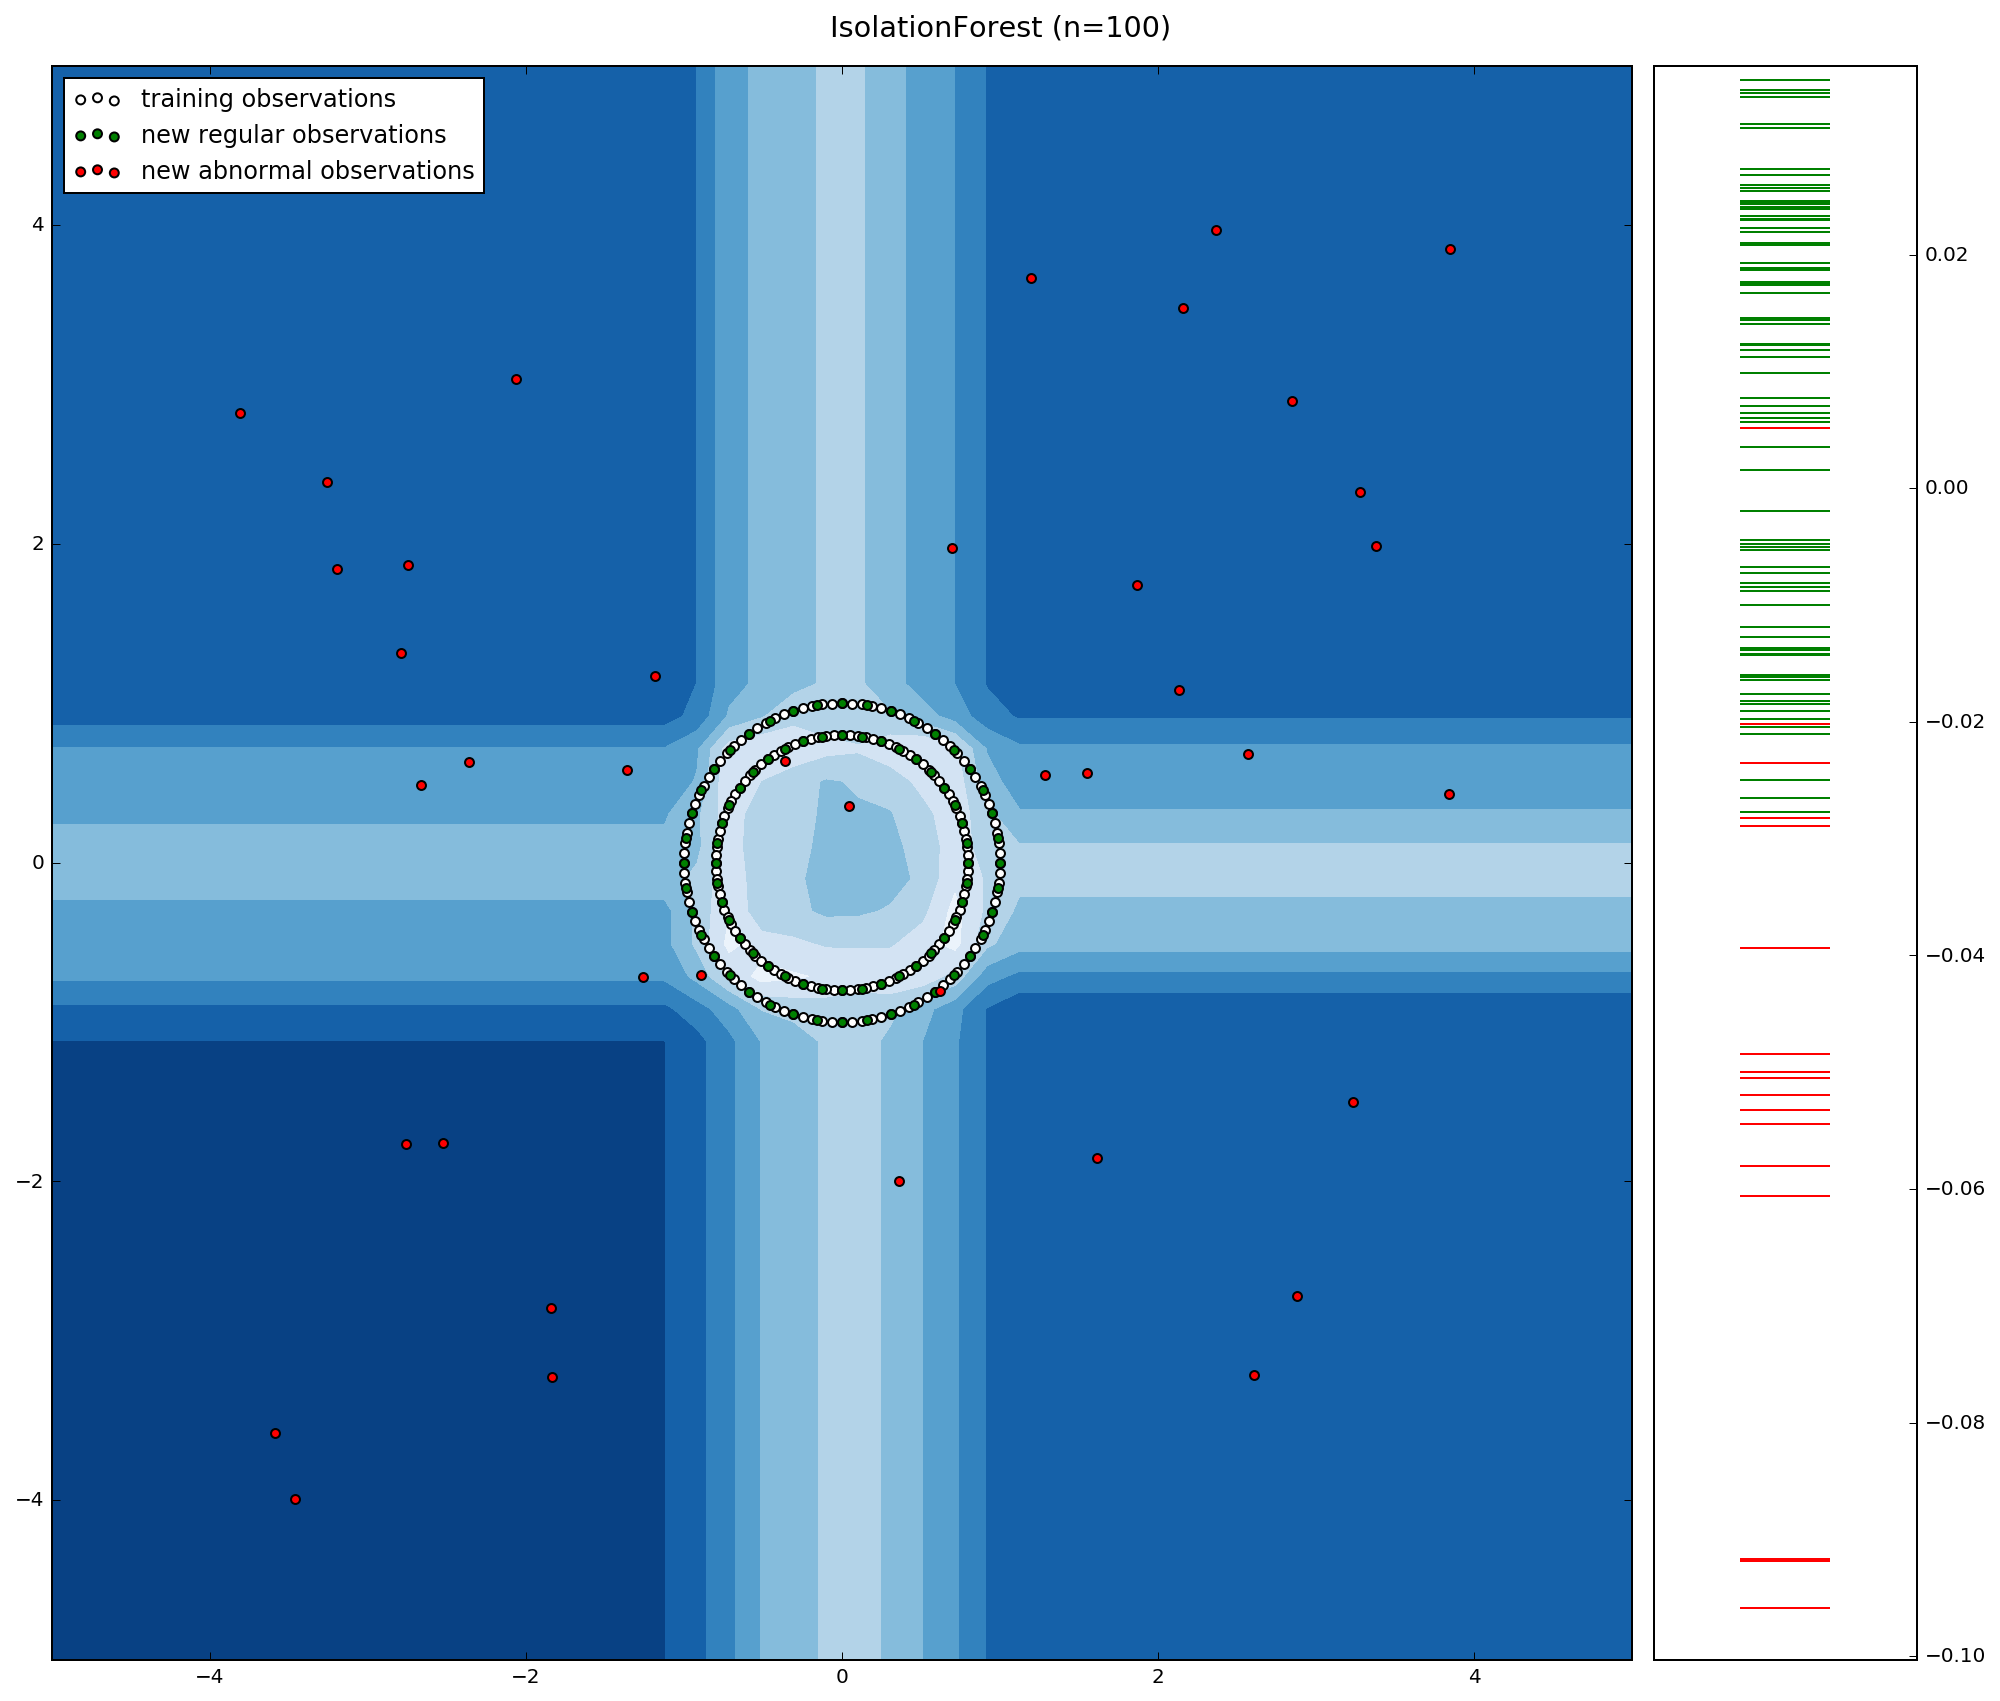

In [9]:
coolPlot("IsolationForest (n=100)", clf.decision_function, Circle_train, Circle_test, Circle_outliers)

Лучше видно, что при "совпадении" одной координаты аномалии с кластером, результат работы алгоритма плохой - не думая, увеличим число деревьев с целью минимизировать "ширину" нехорошей светлой полосы.

In [10]:
# Не думая, просто увеличиваем в десять раз!
clf = IsolationForest(1000)
clf.fit(Circle_train)

y_pred_train = clf.decision_function(Circle_train)
y_pred_test = clf.decision_function(Circle_test)
y_pred_outliers = clf.decision_function(Circle_outliers)

In [11]:
score(y_pred_test, y_pred_outliers)

0.97843749999999996

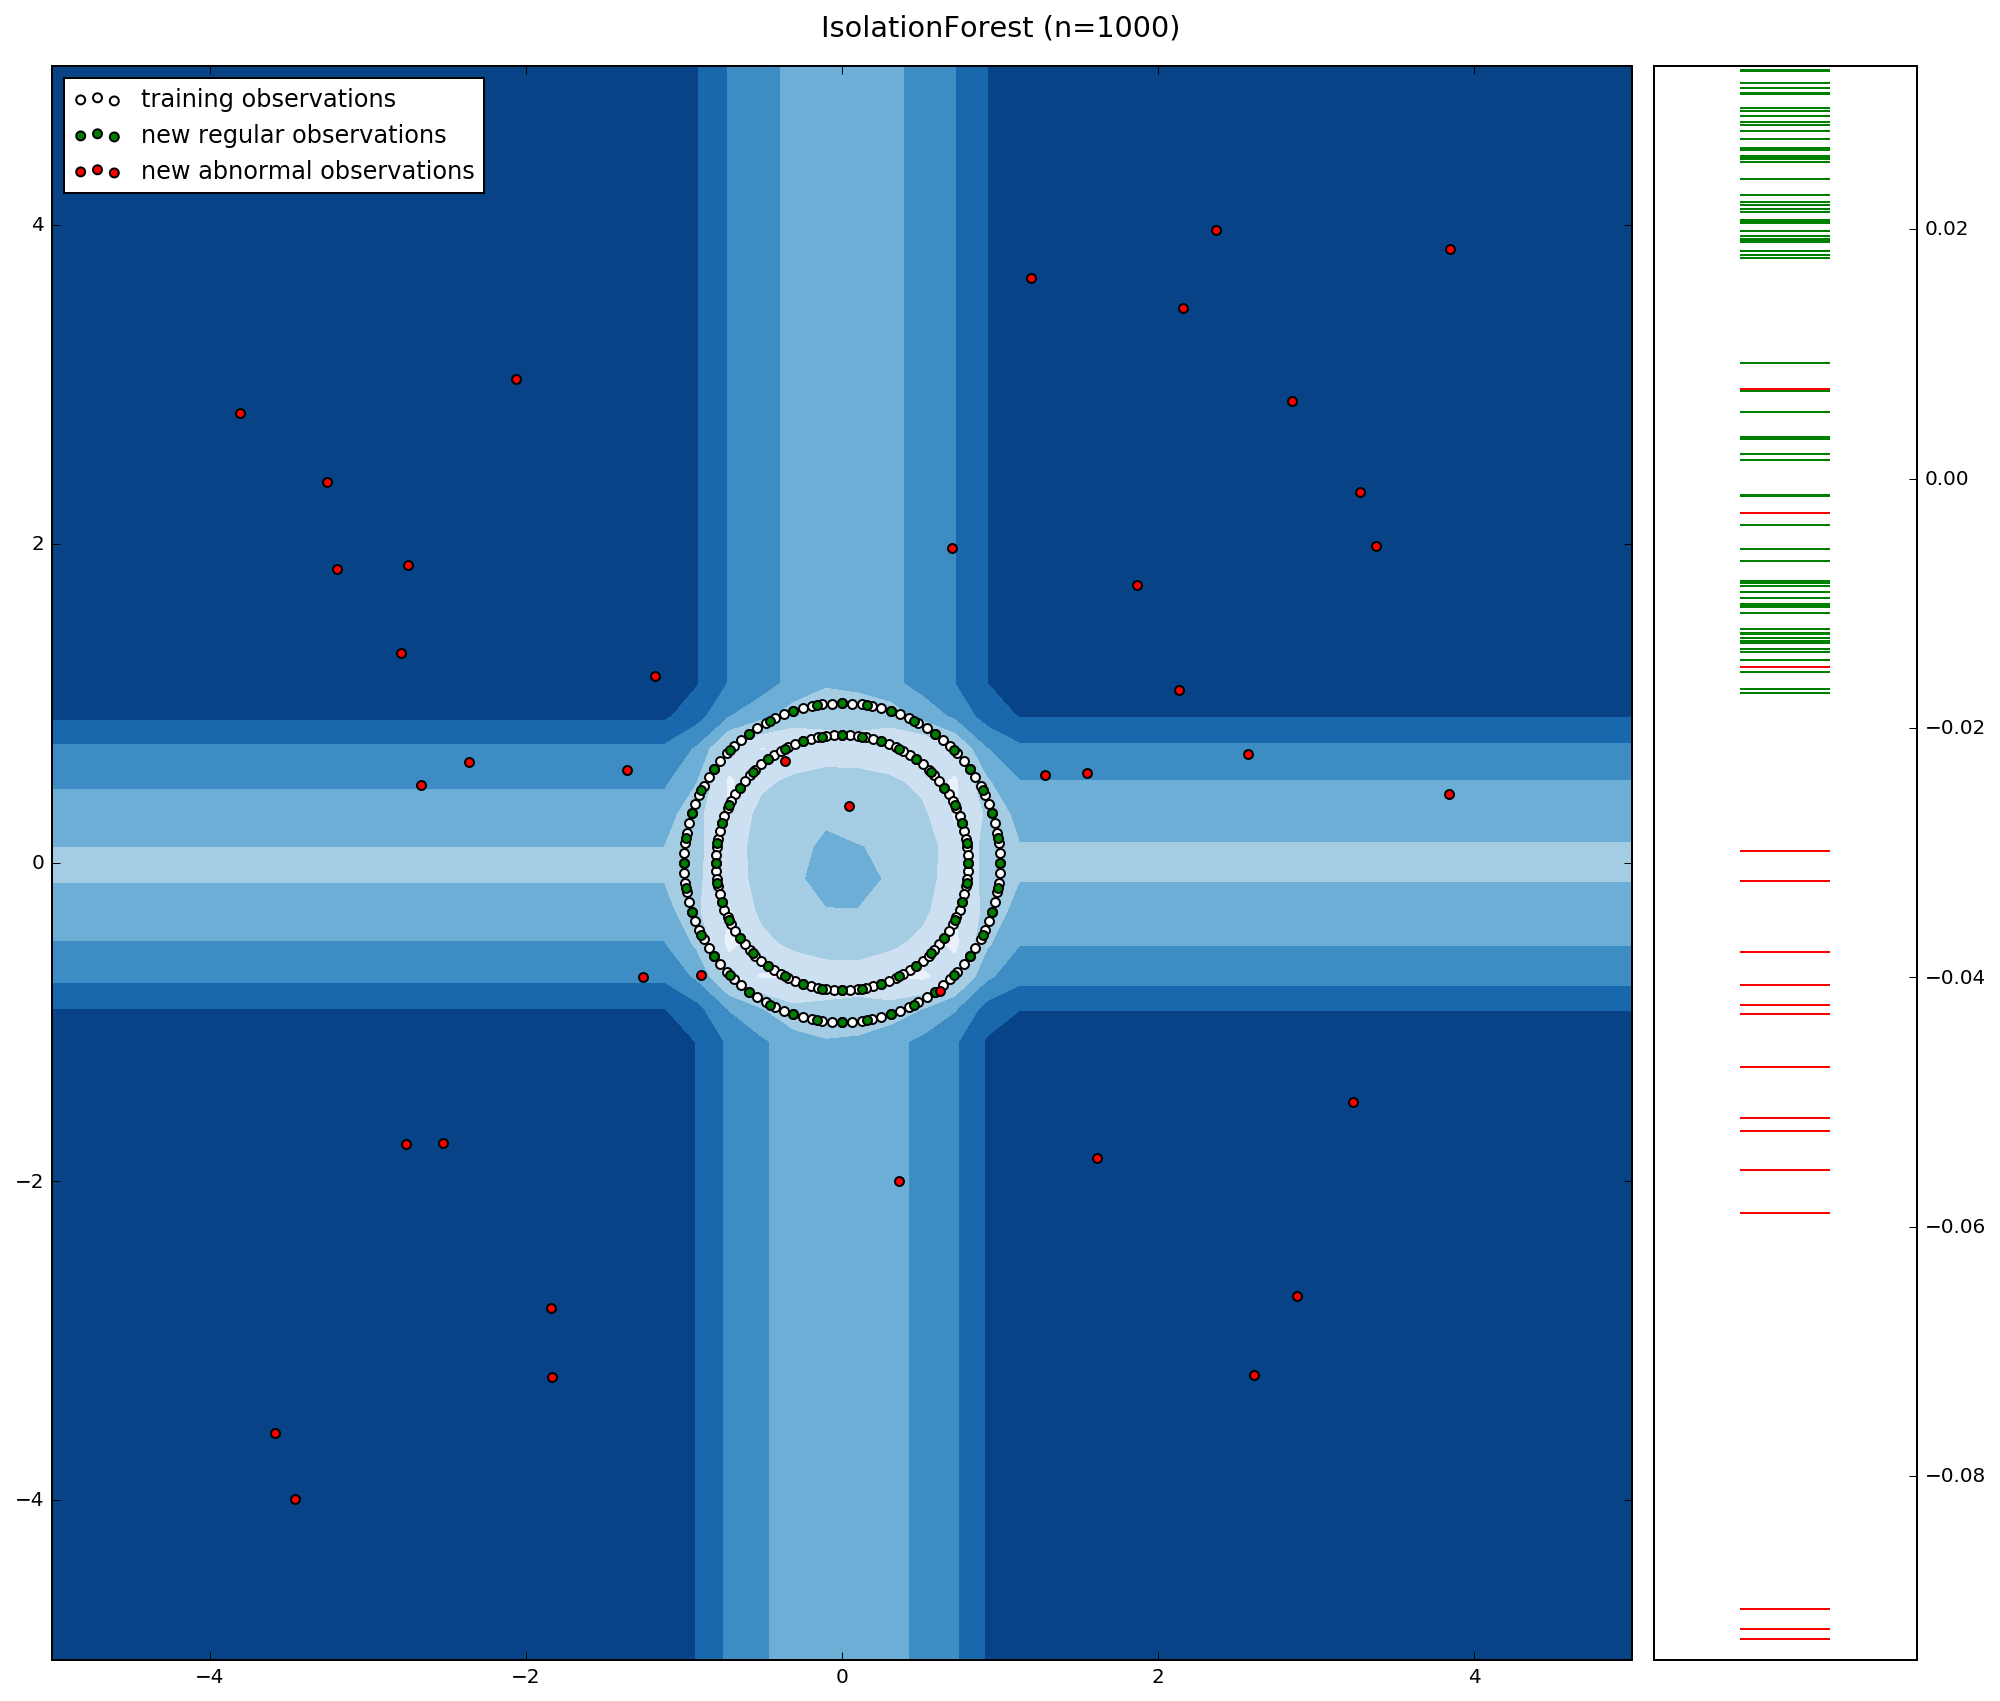

In [12]:
coolPlot("IsolationForest (n=1000)", clf.decision_function, Circle_train, Circle_test, Circle_outliers)

Судя по картинке, "круги" кластера приближаются разрезами, параллельными осям координат, то есть прямоугольниками. В результате, прогноз для правильных объектов теряет в уверенности.

Но главная беда - это полосы, которые остаются и занимают существенную часть пространства, куда может попасть аномальная точка. Попробуем избавиться от них - не будем приближать гиперплоскостями, параллельными осям координат, а какими-то другими! Иначе говоря, можно эти полосы взять и повернуть!

In [13]:
def rot(x, phi = rng.uniform(0, 2*math.pi)):
    cos = math.cos(phi)  # а никак проще нельзя матрицы поворота творить?
    sin = math.sin(phi)
    A = np.array([[cos, sin], [-sin, cos]])
    return x.dot(A)

# Будем обманывать IsolationForest, подсовывая ему на вход повёрнутые координаты
clf = IsolationForest(100)
clf.fit(rot(Circle_train))

y_pred_train = clf.decision_function(rot(Circle_train))
y_pred_test = clf.decision_function(rot(Circle_test))
y_pred_outliers = clf.decision_function(rot(Circle_outliers))

In [14]:
score(y_pred_test, y_pred_outliers)

0.98093750000000002

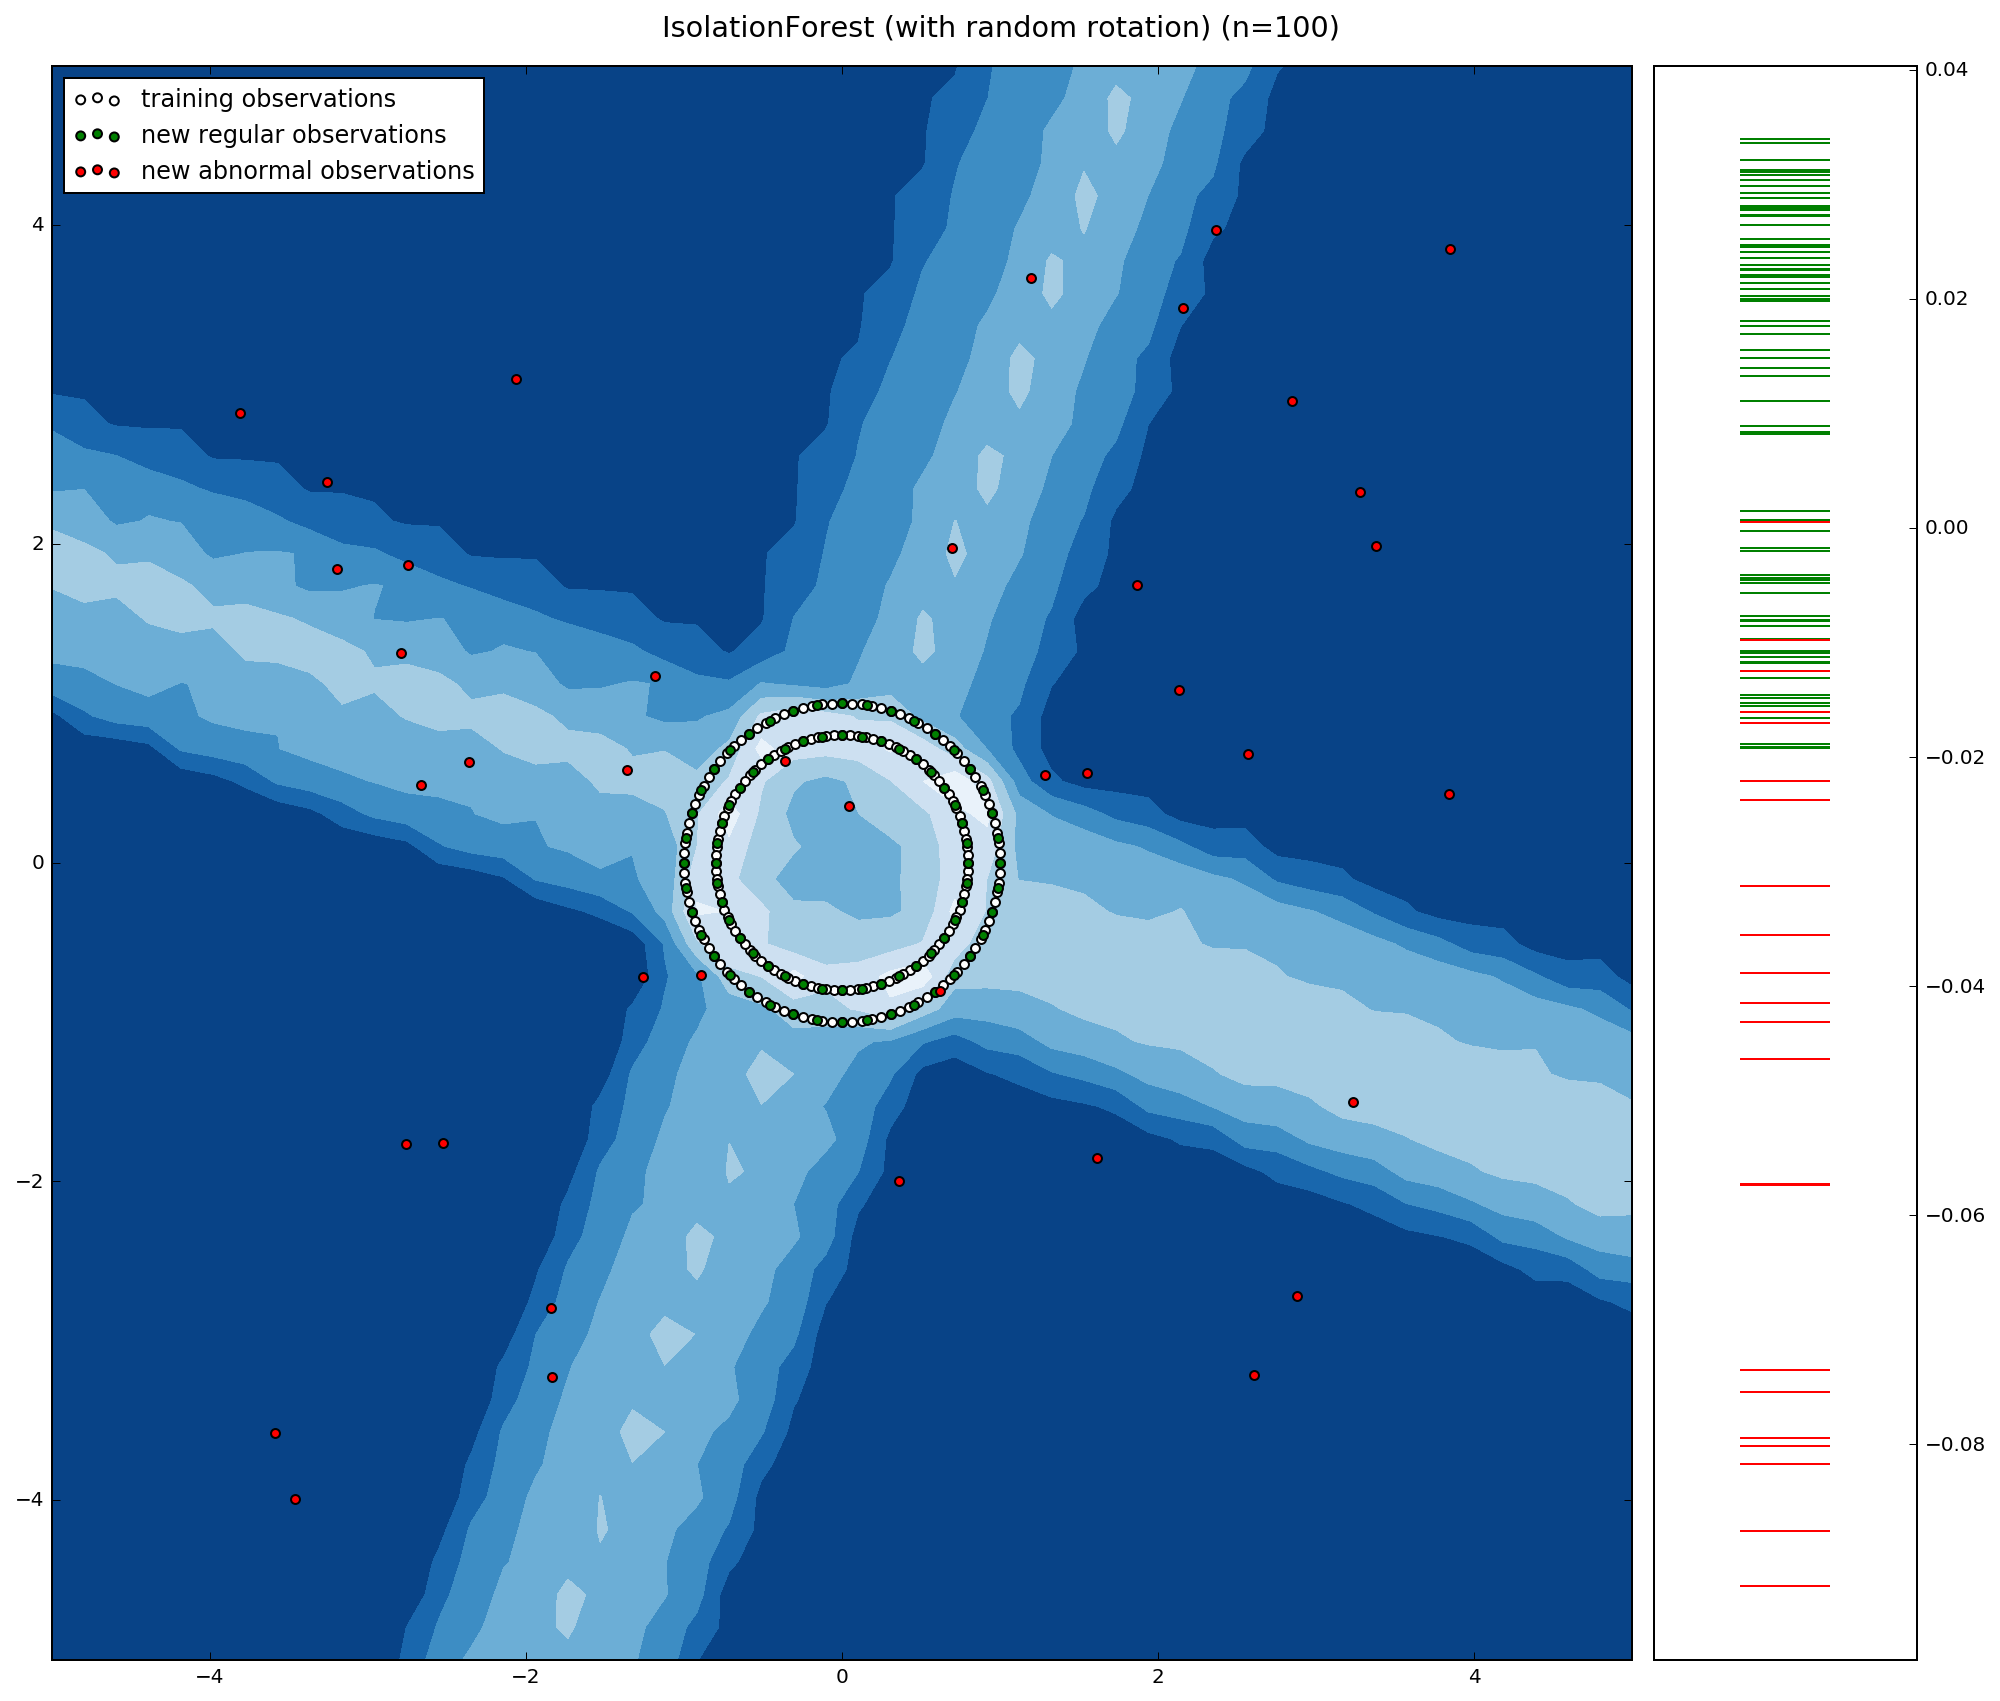

In [15]:
def decision_func(x):
    return clf.decision_function(rot(x))
coolPlot("IsolationForest (with random rotation) (n=100)", decision_func, Circle_train, Circle_test, Circle_outliers)

Полосы остались, конечно, существенно ничего не изменилось, но фишка в другом. Можно сделать несколько случайных поворотов и усреднить результат. Это можно вставить непосредственно в сам алгоритм - у каждого iTree изолирующего дерева добавить случайный поворот пространства признаков. Не заморачиваясь с реализацией, просто попробуем добавить обёртку вокруг sklearn-вской реализации.

In [16]:
class modIsolationTree:
    def __init__(self):
        self.rng = np.random.RandomState()
        self.clf = IsolationForest(n_estimators=1)  # по сути, строим одно дерево с данным поворотом.
        
        phi = rng.uniform(0, 2*math.pi)  # типа случайная матрица поворота
        cos = math.cos(phi)
        sin = math.sin(phi)
        self.A = np.array([[cos, sin], [-sin, cos]])
    
    def mod(self, x):   # просто модифицируем все основные функции алгоритма, подставляя вместо признаков повёрнутые
        return x.dot(self.A)   
    def fit(self, x):
        self.clf.fit(self.mod(x))
        return self
    def decision_function(self, x):
        return self.clf.decision_function(self.mod(x))

In [17]:
class modIsolationForest:  # строим много модифицированных iTree и усредняем
    def __init__(self, n_estimators):
        self.trees = np.array([])
        for i in range(n_estimators):
            self.trees = np.append(self.trees, modIsolationTree())
    def fit(self, x):
        for tree in self.trees:
            tree.fit(x)
        return self
    def decision_function(self, x):
        ans = 0
        for tree in self.trees:
            ans += tree.decision_function(x)
        return ans / len(self.trees)

In [18]:
clf = modIsolationForest(100)  # ладно бы изолирующий, так ещё неизвестно, с какой стороны он подкрадётся!
clf.fit(Circle_train)

y_pred_train = clf.decision_function(Circle_train)
y_pred_test = clf.decision_function(Circle_test)
y_pred_outliers = clf.decision_function(Circle_outliers)

In [19]:
score(y_pred_test, y_pred_outliers)

0.98093750000000002

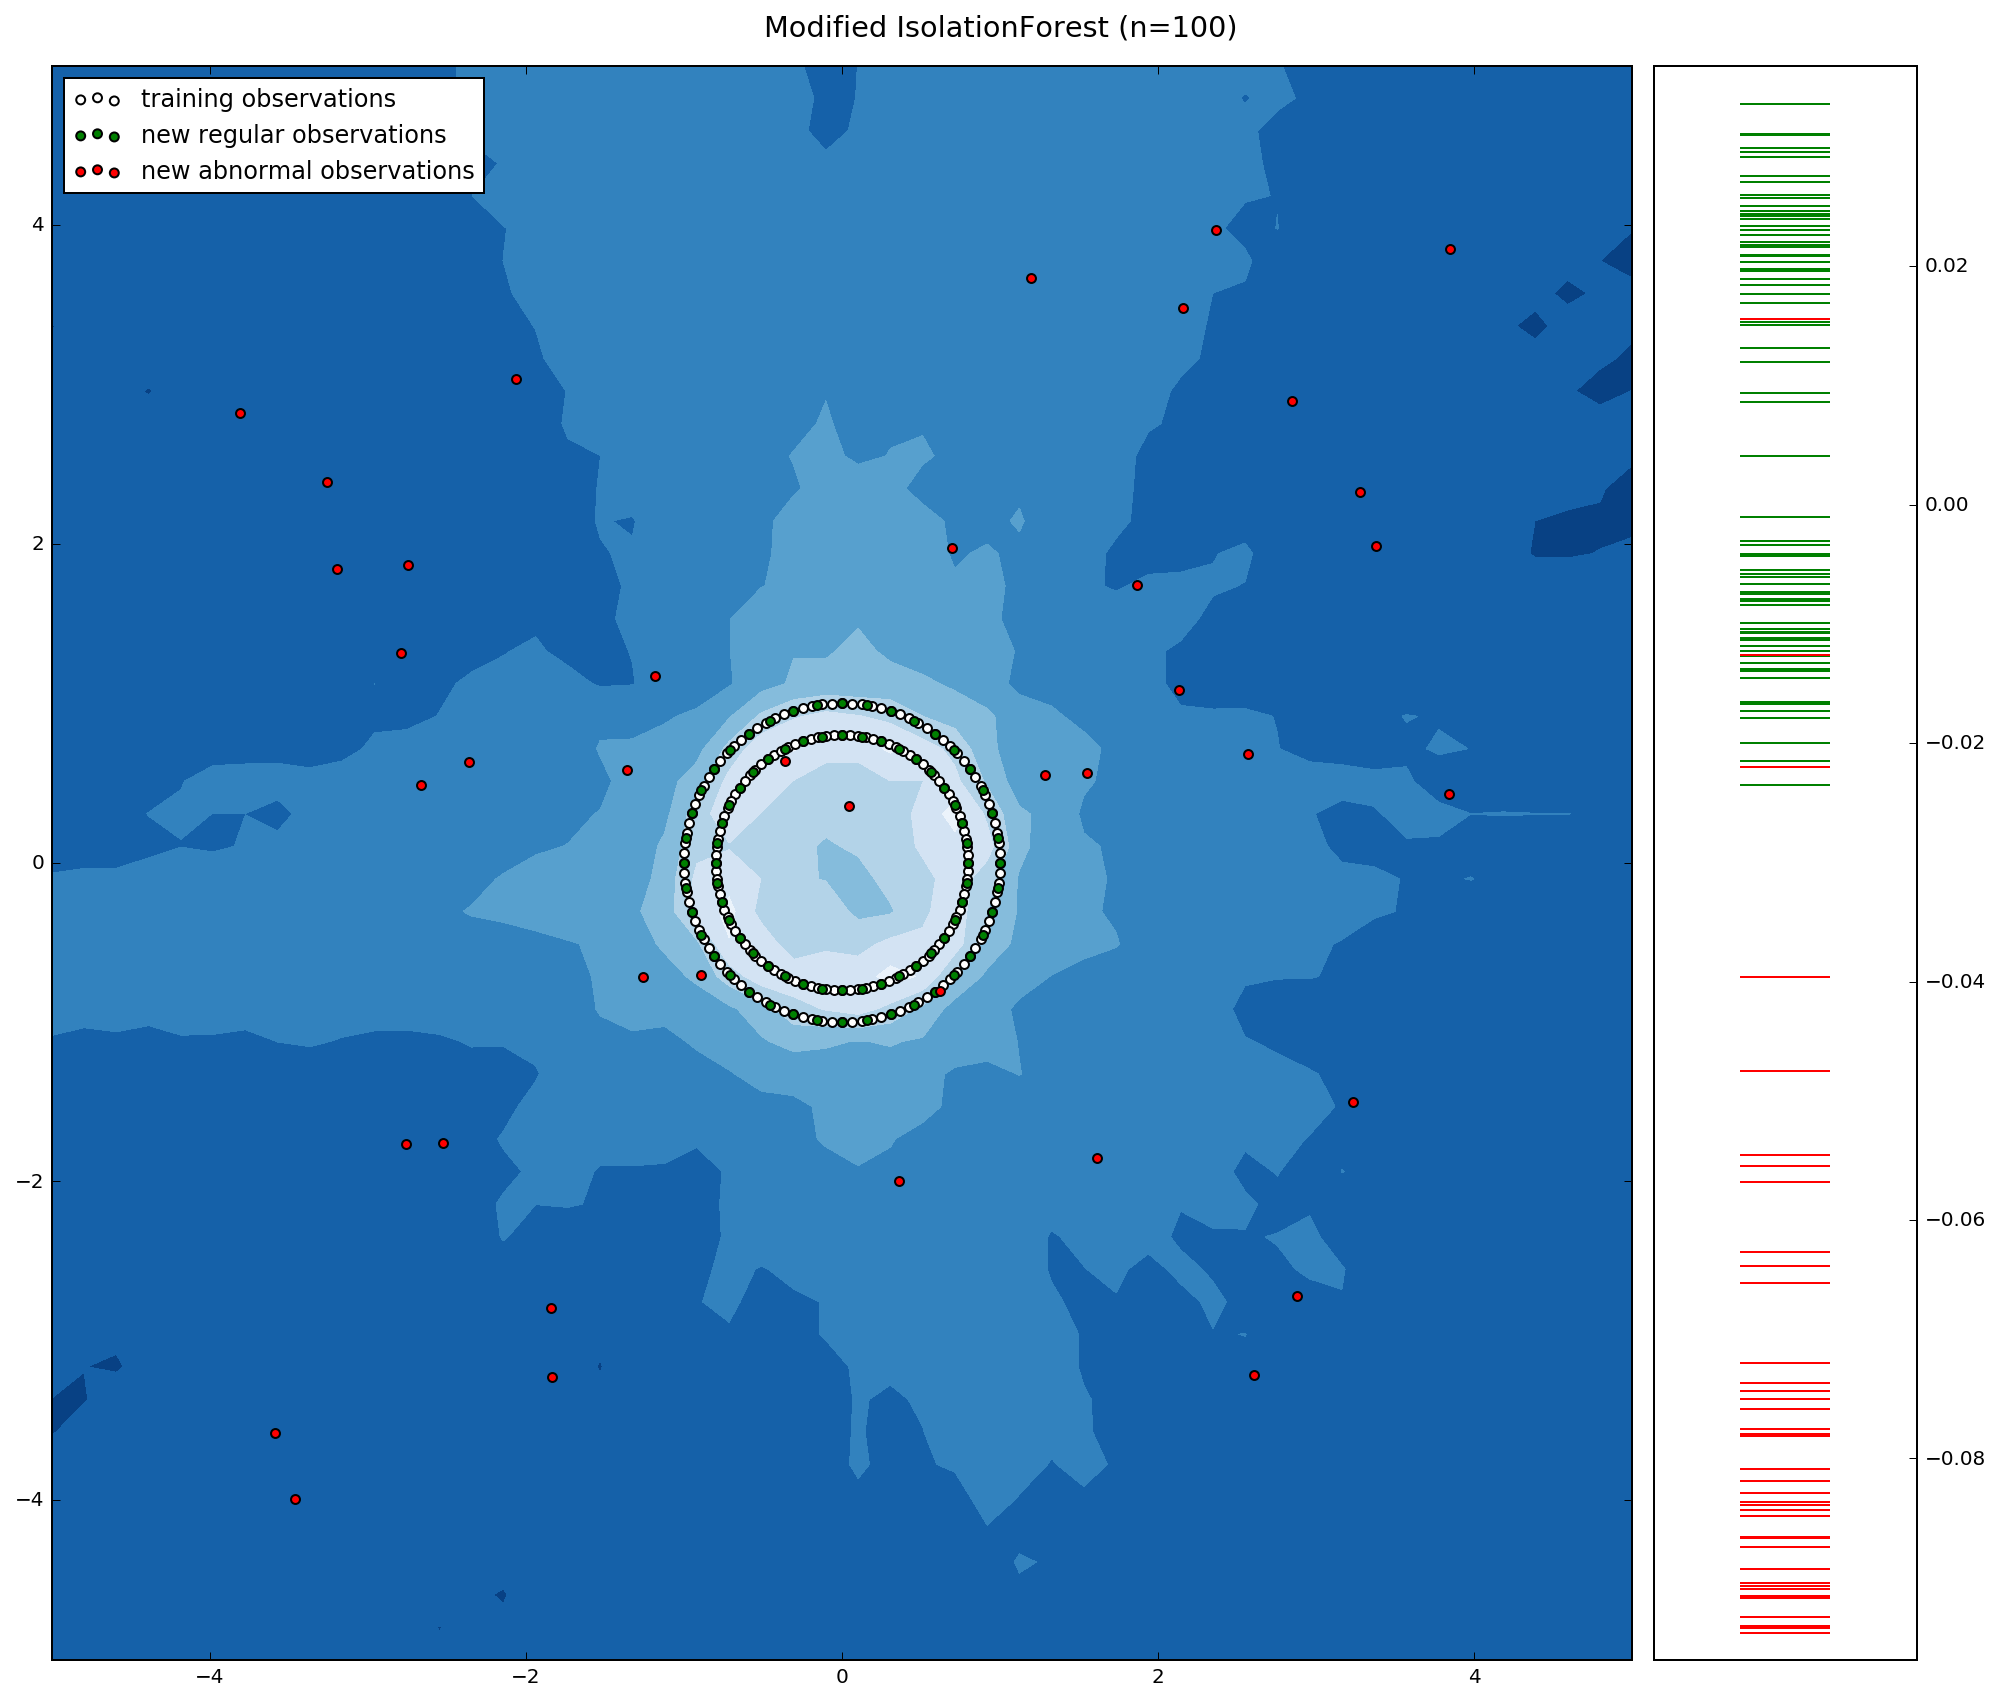

In [20]:
coolPlot("Modified IsolationForest (n=100)", clf.decision_function, Circle_train, Circle_test, Circle_outliers)

Посмотрим, как изменится результат при увеличении числа деревьев

In [21]:
clf = modIsolationForest(1000)
clf.fit(Circle_train)

y_pred_train = clf.decision_function(Circle_train)
y_pred_test = clf.decision_function(Circle_test)
y_pred_outliers = clf.decision_function(Circle_outliers)

In [22]:
score(y_pred_test, y_pred_outliers)

0.98749999999999993

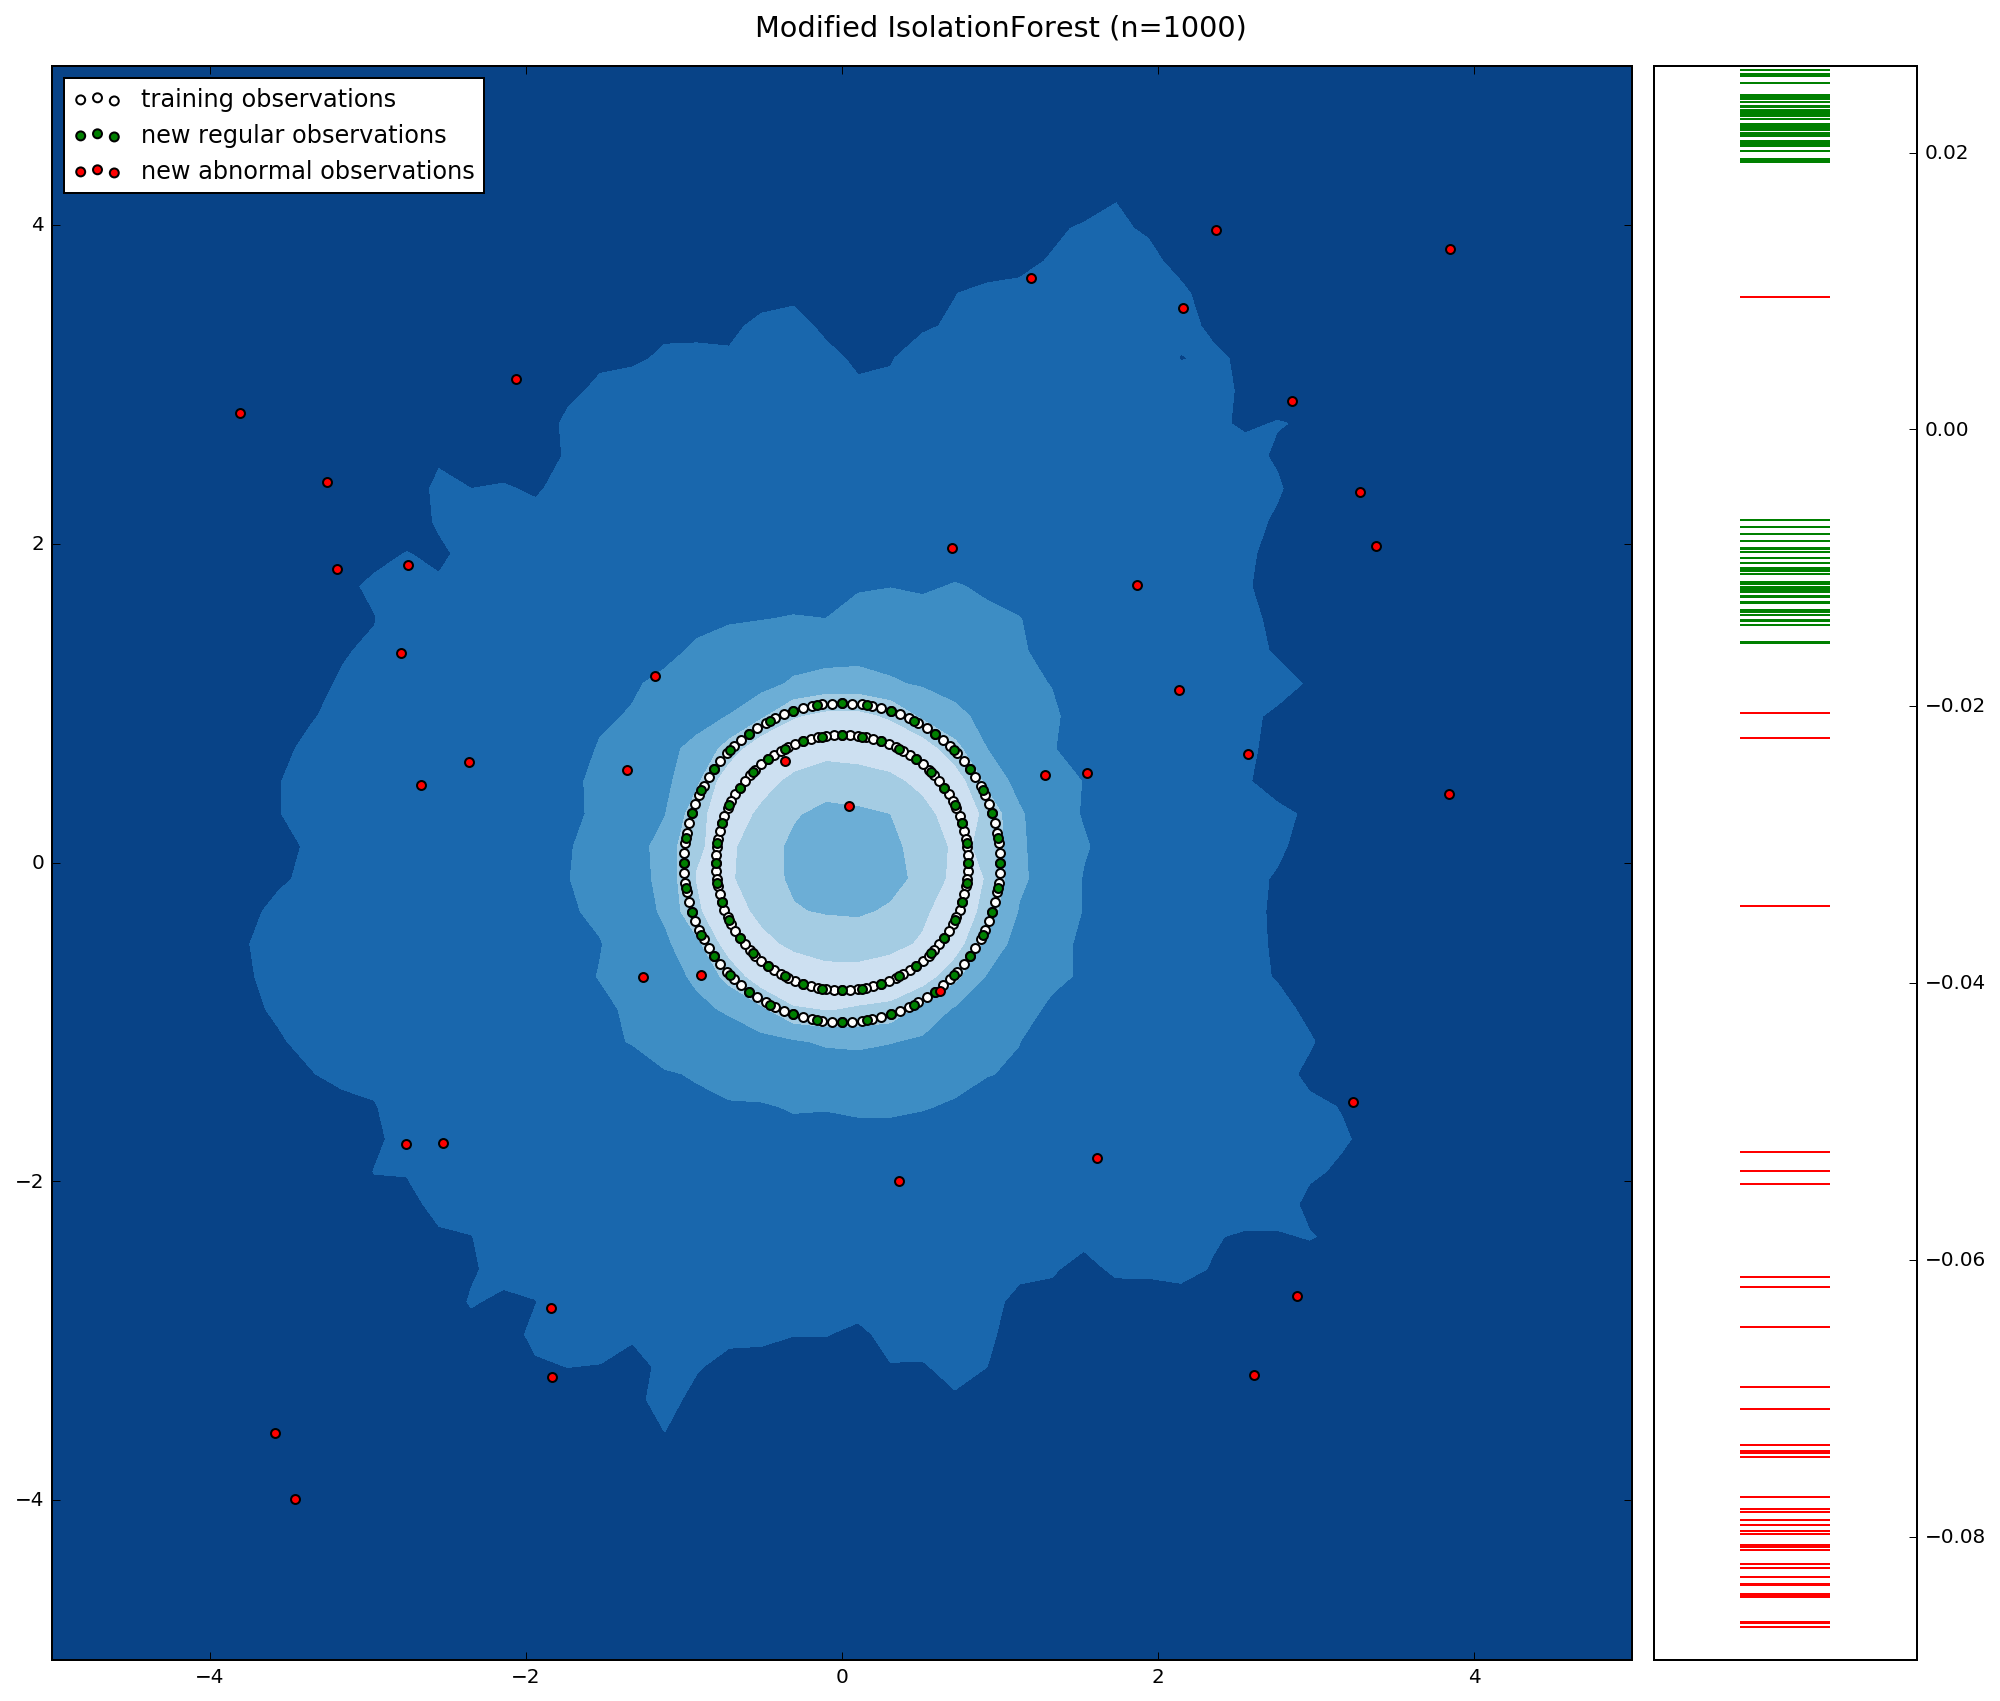

In [23]:
coolPlot("Modified IsolationForest (n=1000)", clf.decision_function, Circle_train, Circle_test, Circle_outliers)

Если мне не изменяет линал, линейное преобразование признаков можно сделать за линию (а точнее - $O(nd)$, где $d$ - размерность пространства). Ну правда надо разбиратся, как грамотно генерить случайный поворот в $N$-мерном пространстве, но вряд ли это сложная задача. Это означает, что такое преобразование в алгоритме повлияет только на константу.

Мне просто интересно, сойдётся ли область, выделенная лесом, к кольцам или нет.

In [24]:
clf = modIsolationForest(10000)
clf.fit(Circle_train)

y_pred_train = clf.decision_function(Circle_train)
y_pred_test = clf.decision_function(Circle_test)
y_pred_outliers = clf.decision_function(Circle_outliers)

In [25]:
score(y_pred_test, y_pred_outliers)

0.98749999999999993

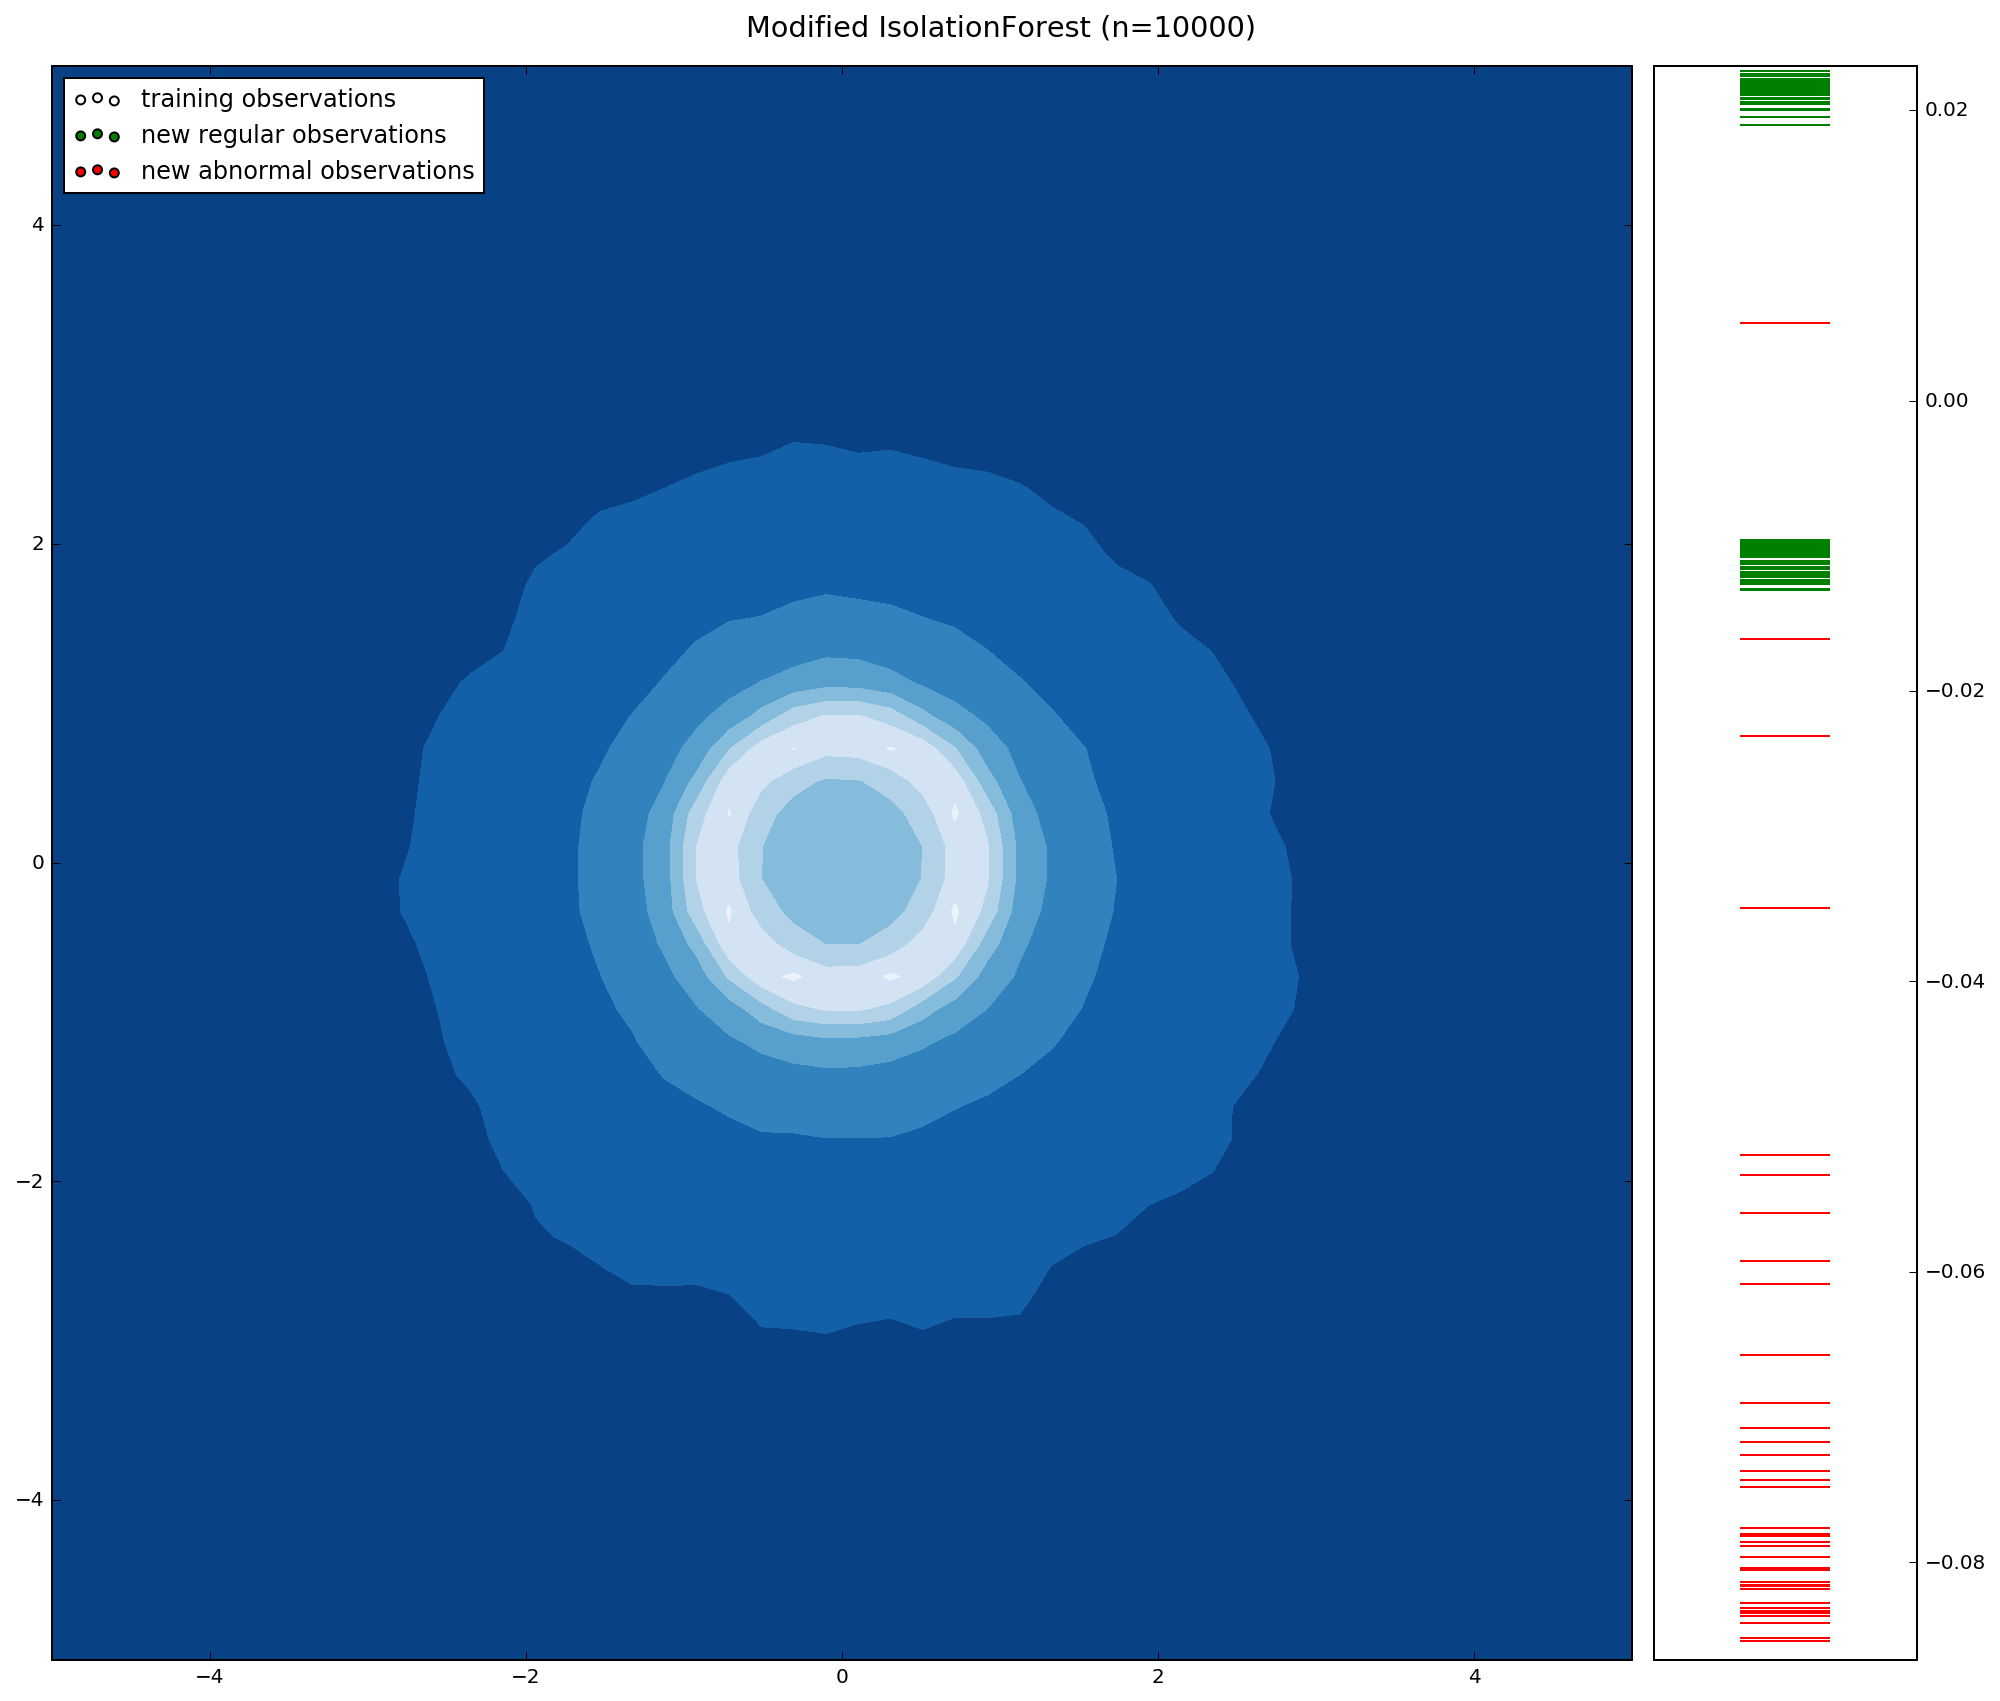

In [26]:
coolPlot("Modified IsolationForest (n=10000)", clf.decision_function)

Для сравнения запустим модифицированный алгоритм и на тесте с двумя кластерами. Классический алгоритм, правда, без подбора параметров (n_estimators=100) давал 0.96375.

In [27]:
clf = modIsolationForest(100)
clf.fit(X_train)

y_pred_train = clf.decision_function(X_train)
y_pred_test = clf.decision_function(X_test)
y_pred_outliers = clf.decision_function(X_outliers)

In [28]:
score(y_pred_test, y_pred_outliers)

0.96749999999999992

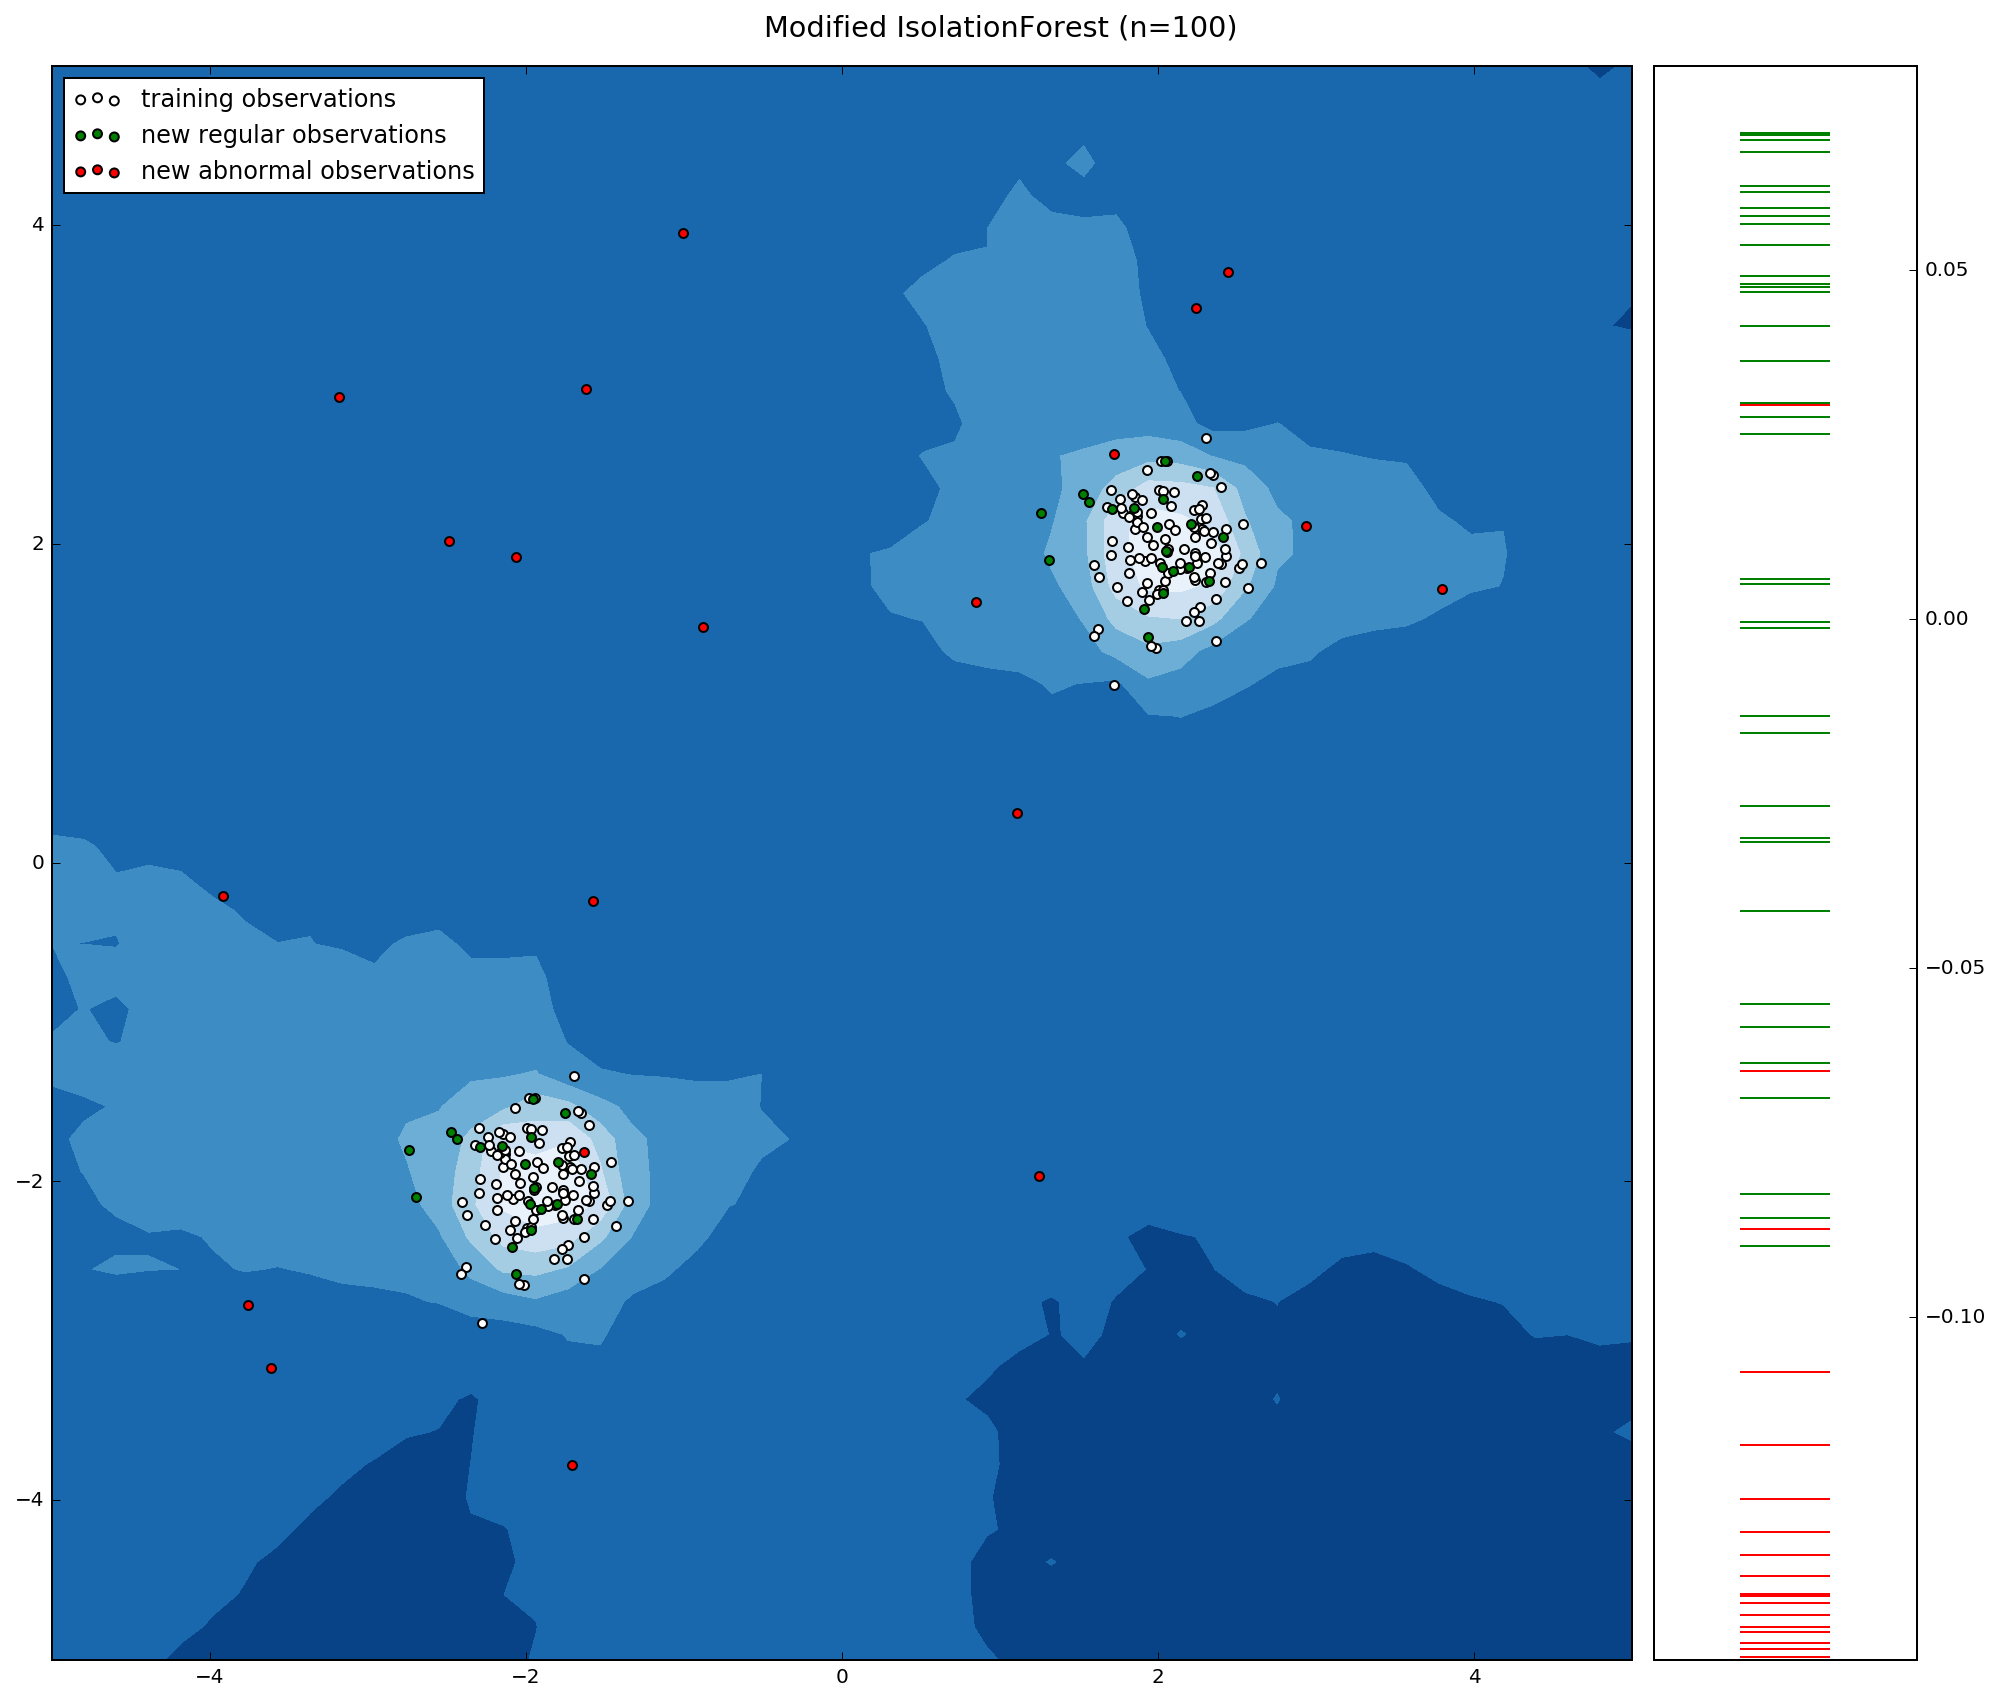

In [29]:
coolPlot("Modified IsolationForest (n=100)", clf.decision_function, X_train, X_test, X_outliers)

Ещё поигрушечки.
Добавим аномалии в обучение и сравним в этом случае. Данных возьмём побольше, а то 20 аномалий это несерьёзно

In [30]:
rng = np.random.RandomState()
# Данные обучения - нормальные + аномалии
X = 0.3 * rng.randn(1000, 2)
Xnoised_train = np.vstack([np.r_[X + 2, X - 2], rng.uniform(low=-4, high=4, size=(200, 2))])

# Дл теста: создаём ещё нормальных данных 
X = 0.3 * rng.randn(200, 2)
Xnoised_test = np.r_[X + 2, X - 2]
# 200 аномалий!
Xnoised_outliers = rng.uniform(low=-4, high=4, size=(200, 2))

0.983725


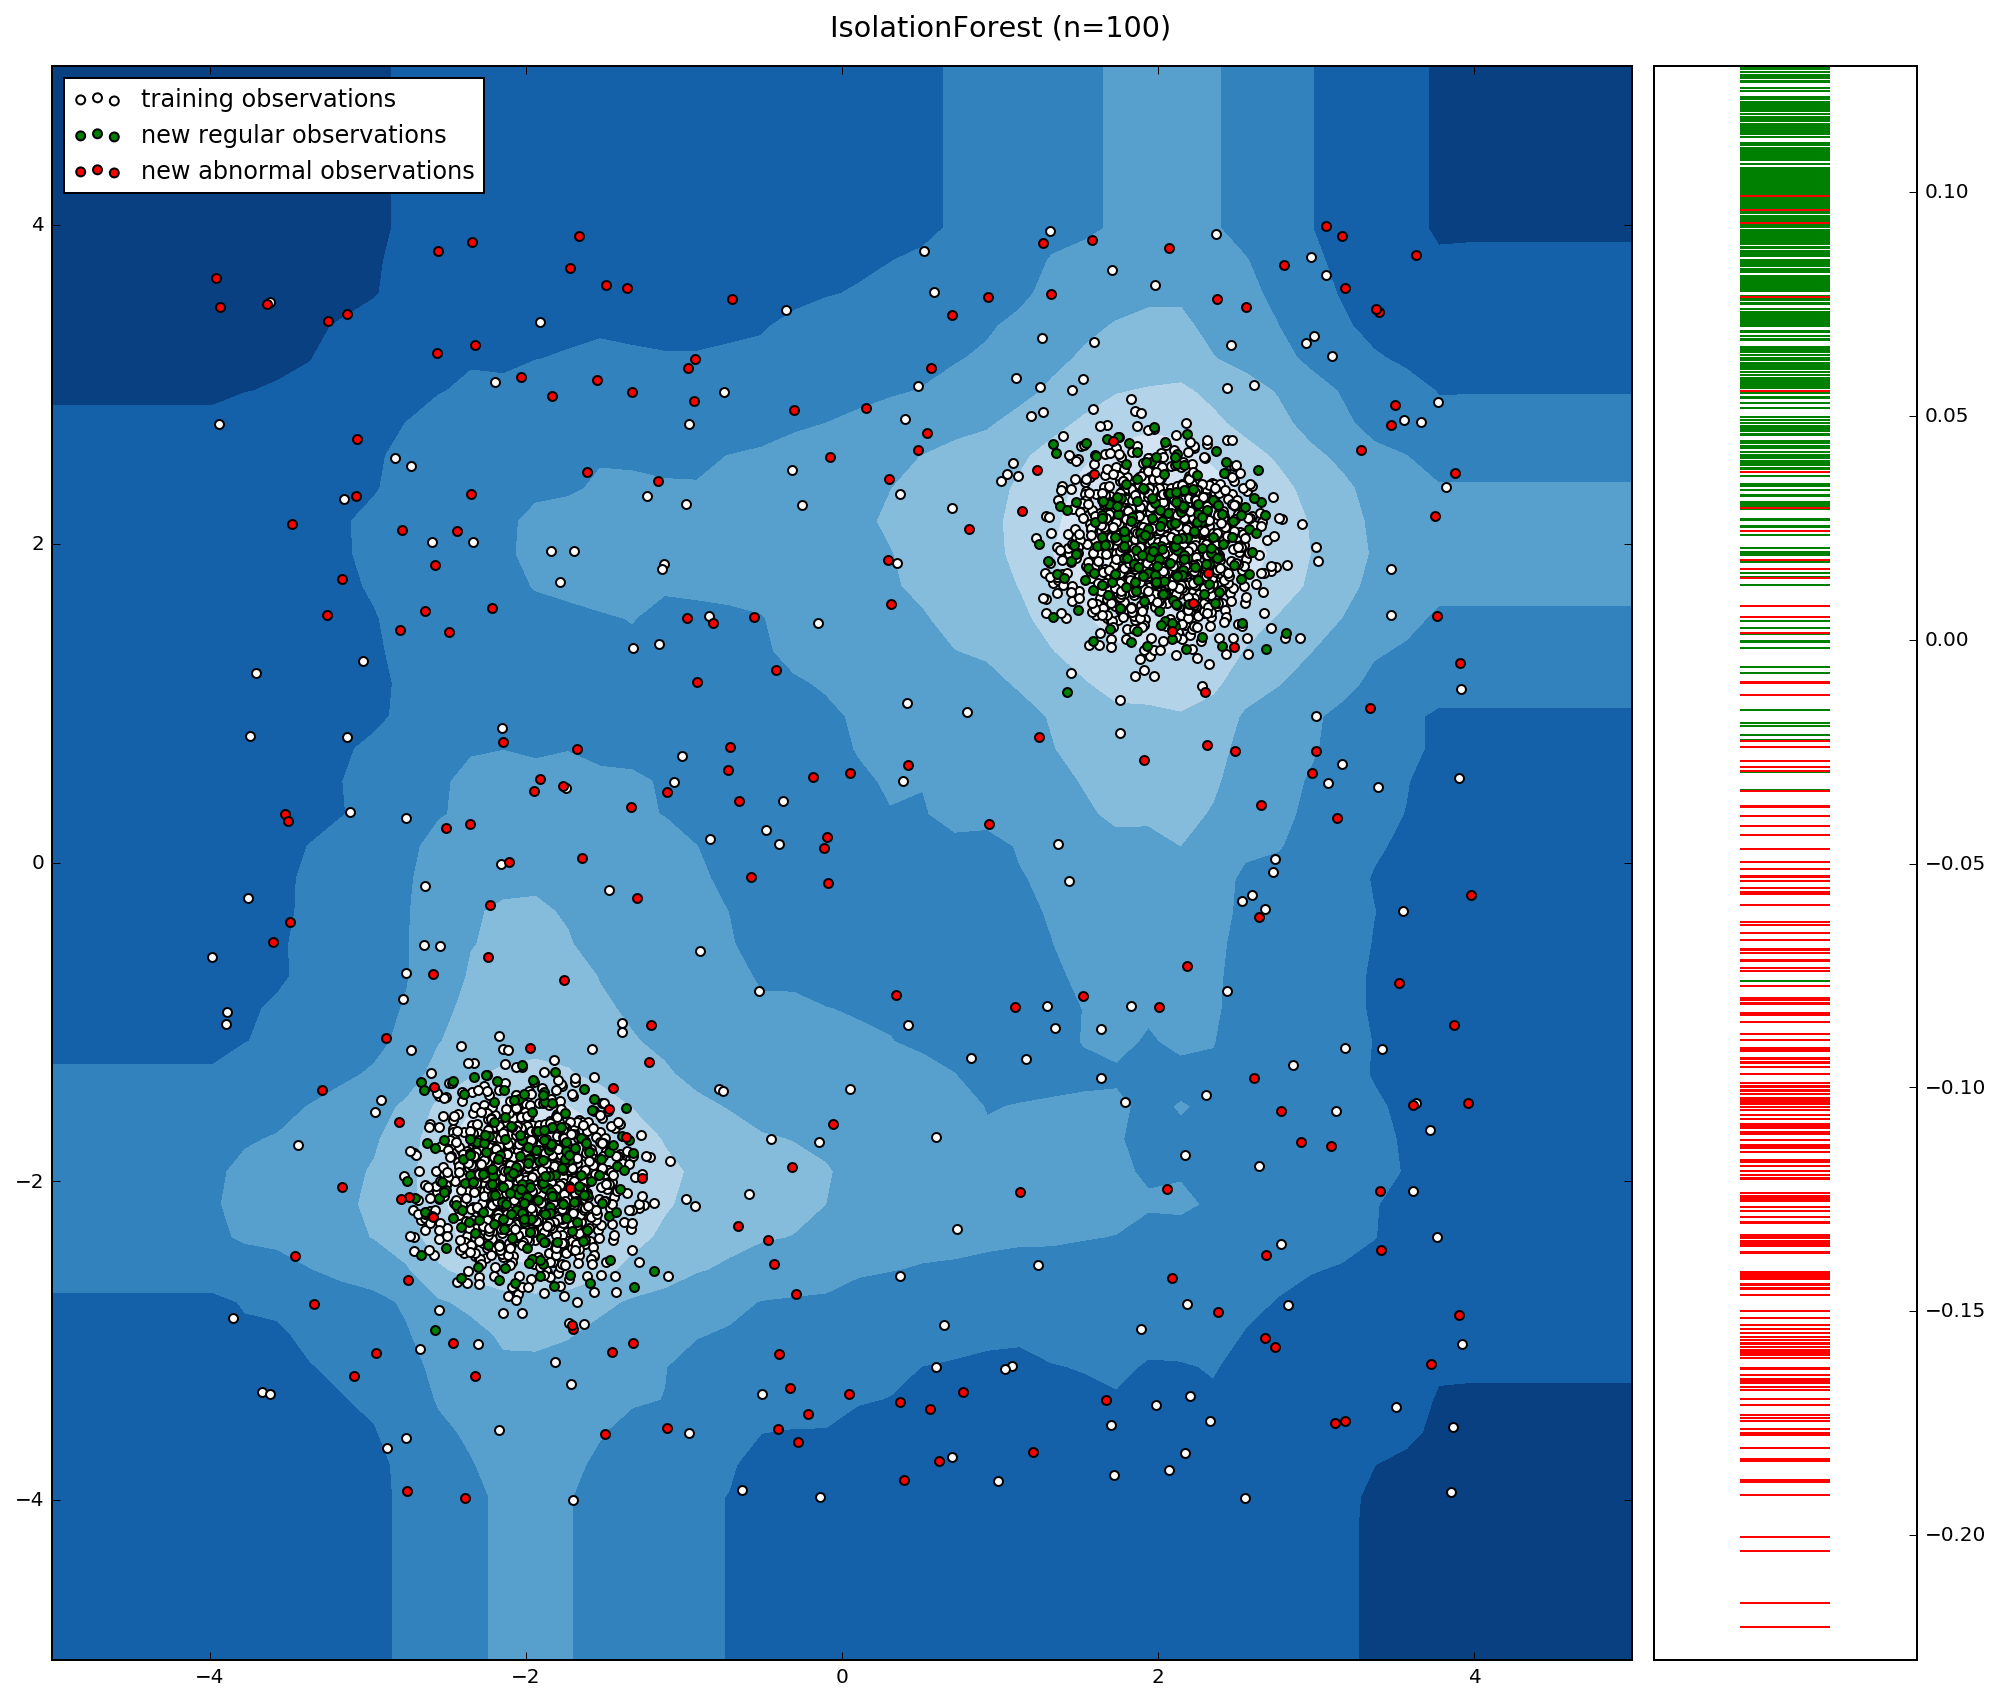

In [31]:
# Применим классический IsolationForest
clf = IsolationForest(100)
clf.fit(Xnoised_train)
y_pred_train = clf.decision_function(Xnoised_train)
y_pred_test = clf.decision_function(Xnoised_test)
y_pred_outliers = clf.decision_function(Xnoised_outliers)

print(score(y_pred_test, y_pred_outliers))
coolPlot("IsolationForest (n=100)", clf.decision_function, Xnoised_train, Xnoised_test, Xnoised_outliers)

0.9841375


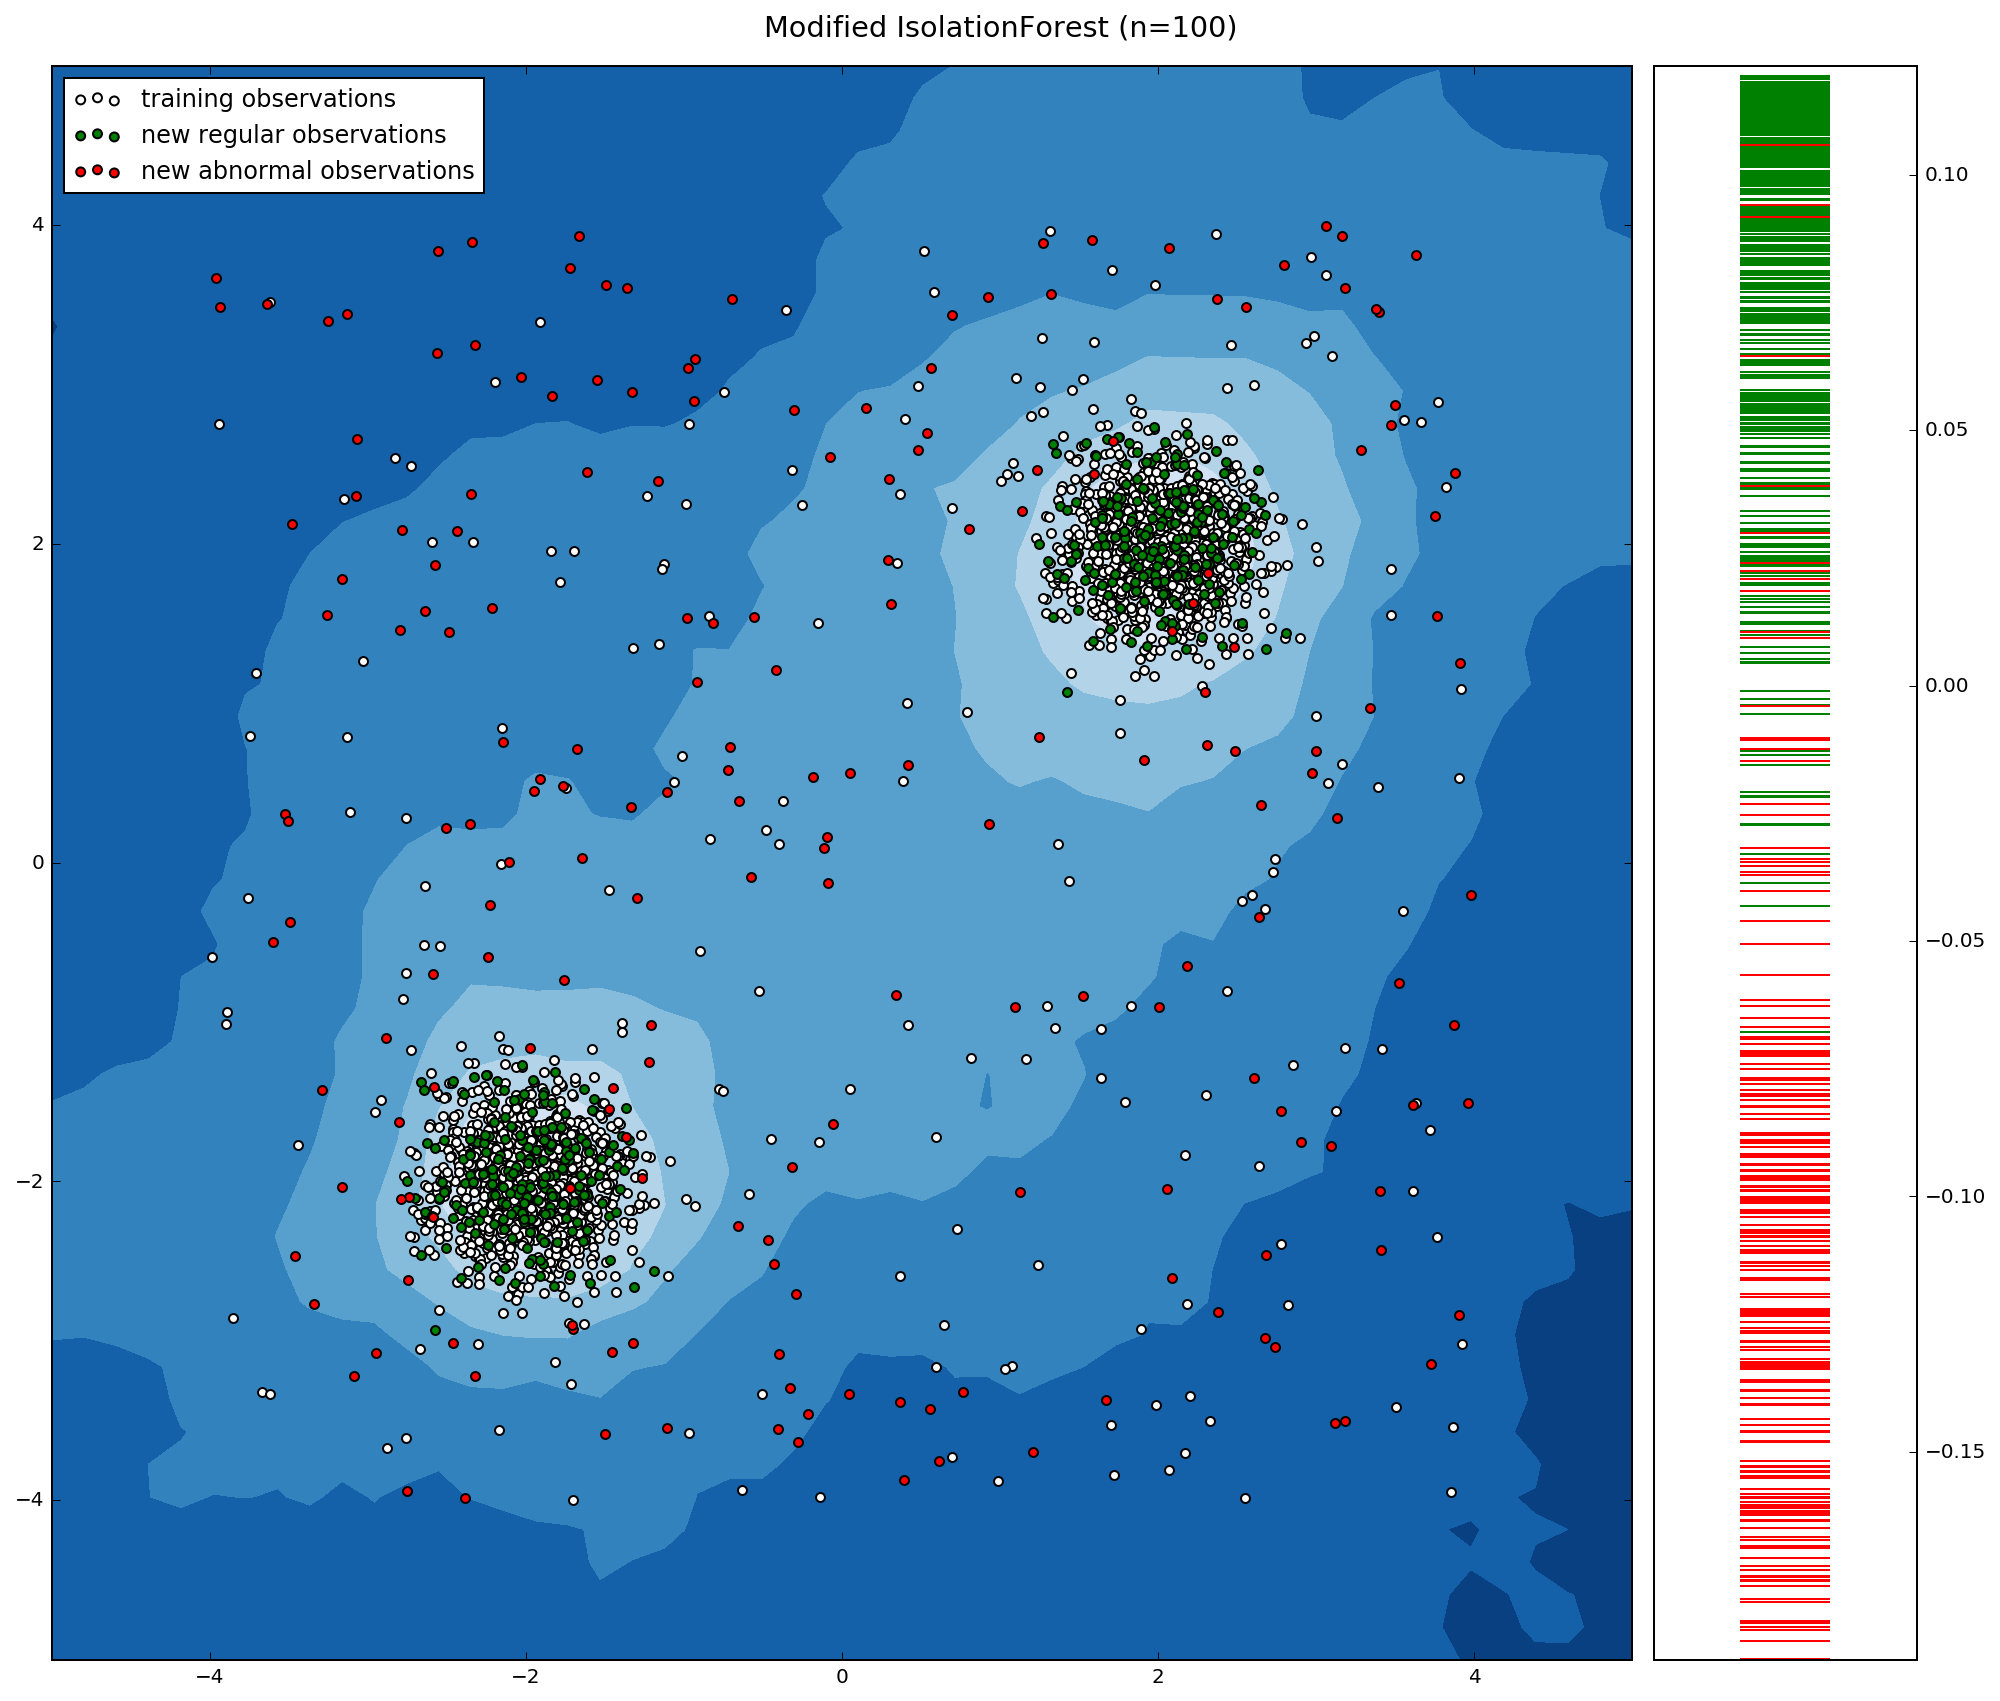

In [32]:
# Применим модифицированный IsolationForest
clf = modIsolationForest(100)
clf.fit(Xnoised_train)
y_pred_train = clf.decision_function(Xnoised_train)
y_pred_test = clf.decision_function(Xnoised_test)
y_pred_outliers = clf.decision_function(Xnoised_outliers)

print(score(y_pred_test, y_pred_outliers))
coolPlot("Modified IsolationForest (n=100)", clf.decision_function, Xnoised_train, Xnoised_test, Xnoised_outliers)

0.9843625


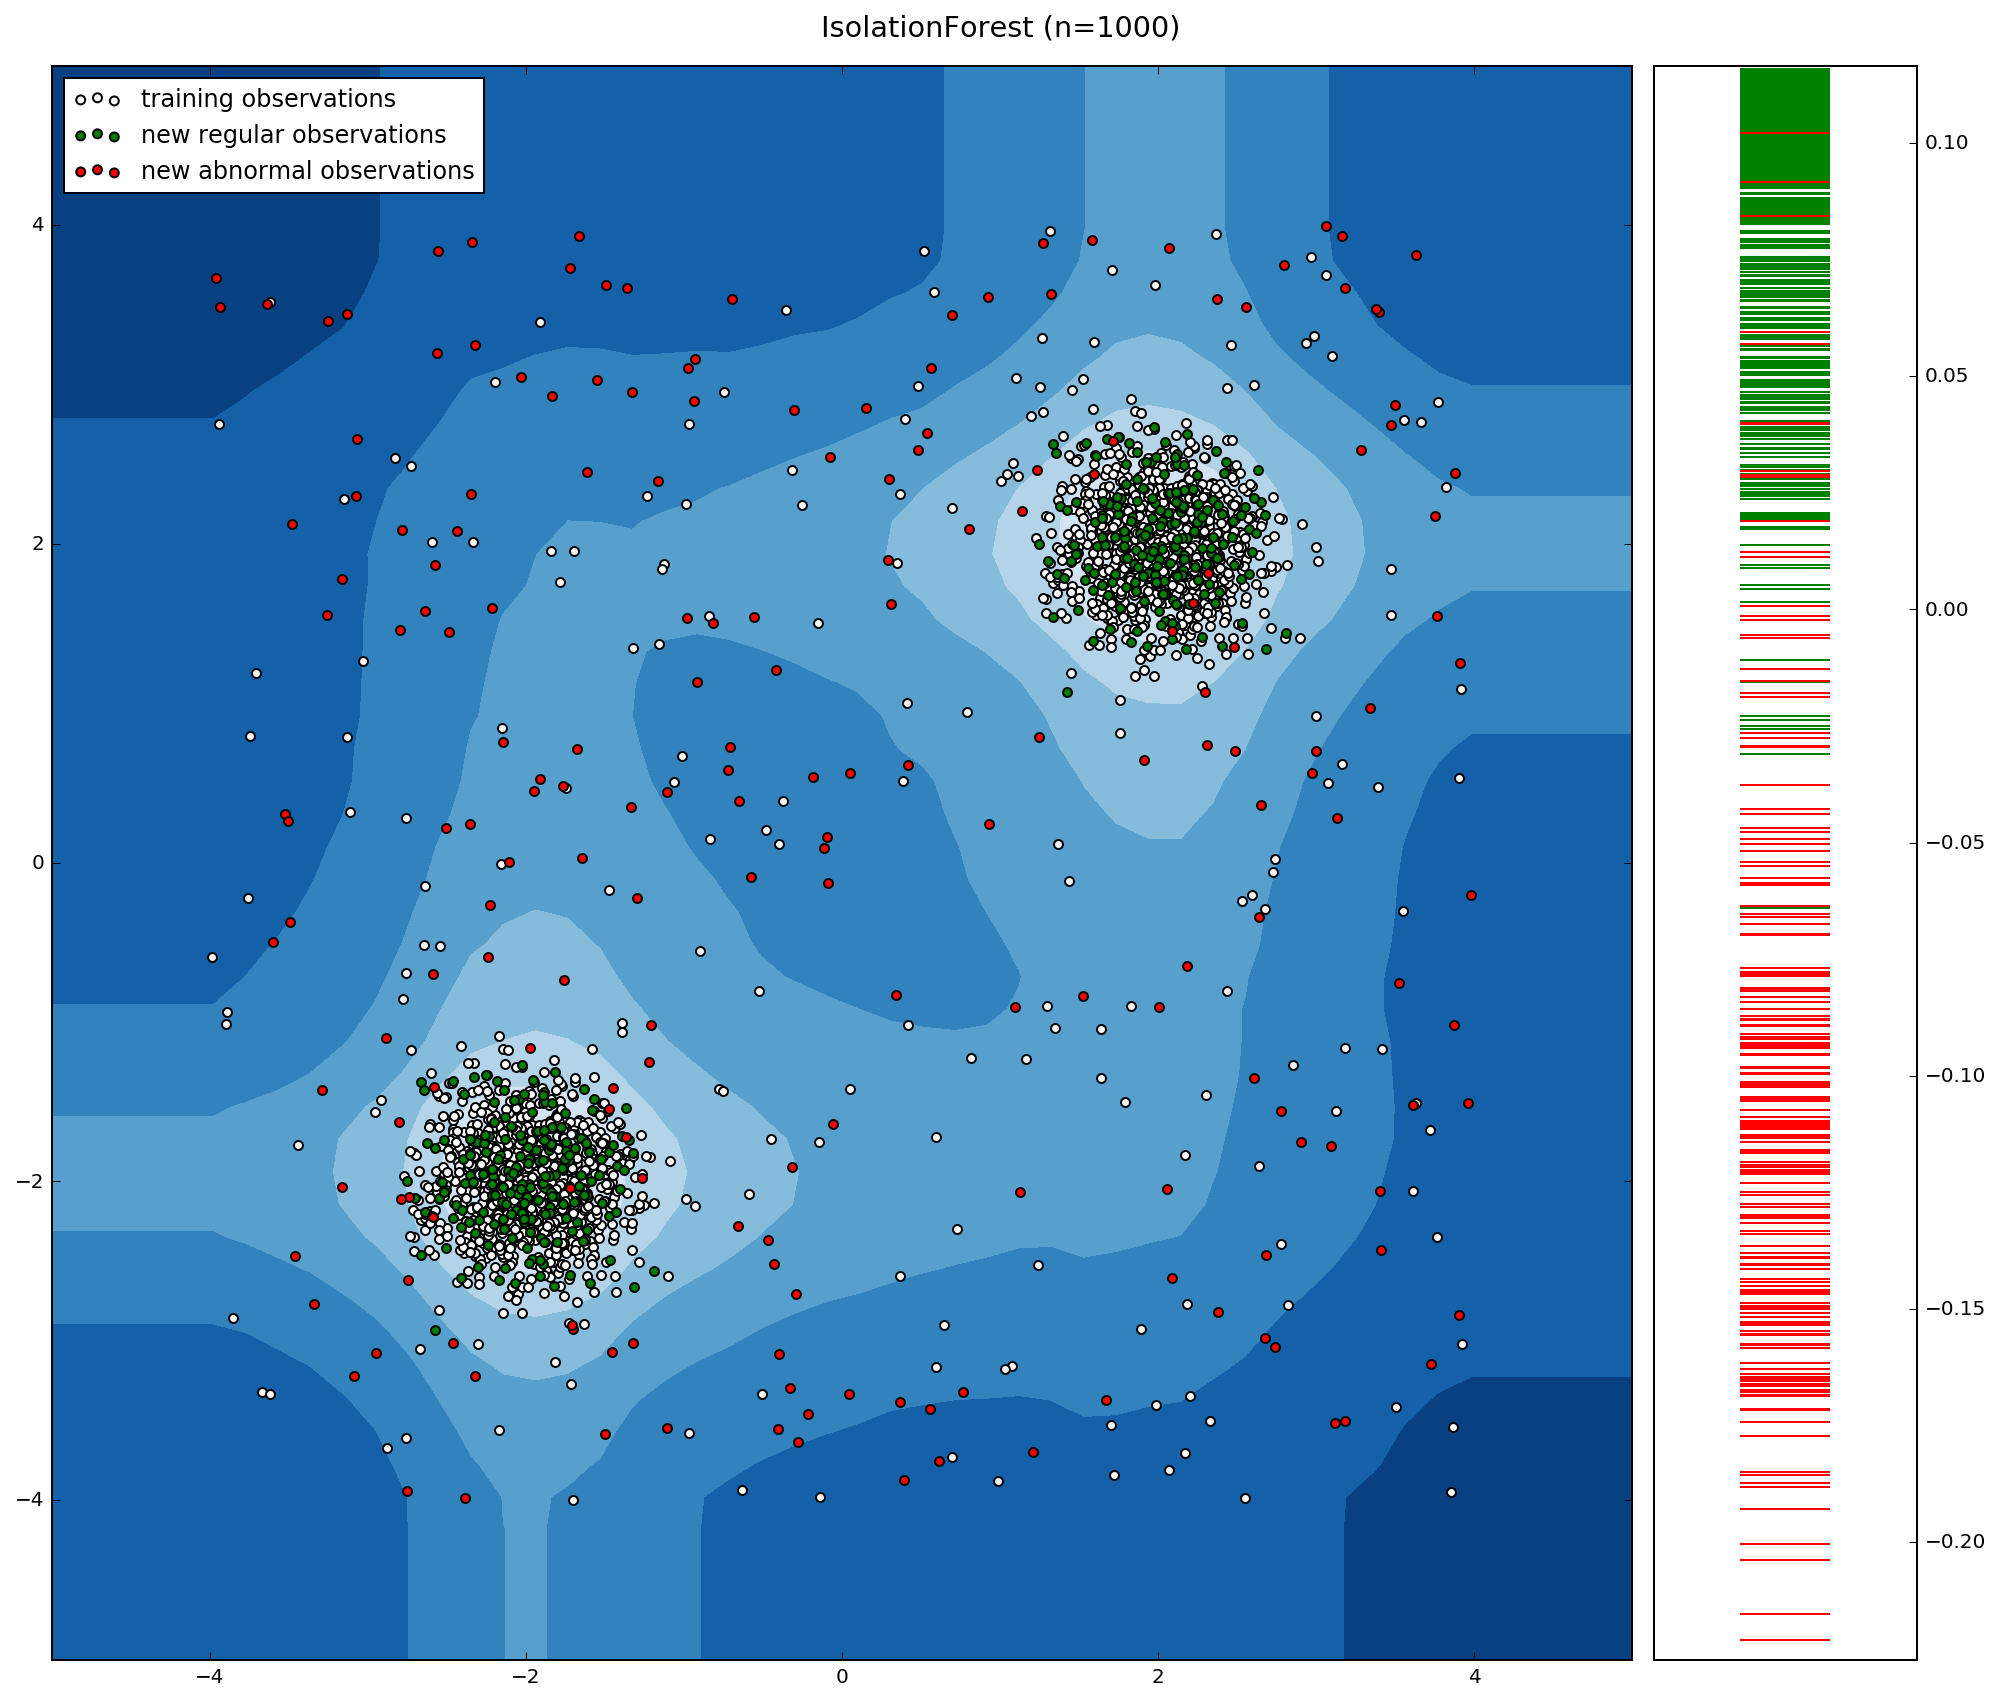

In [33]:
clf = IsolationForest(1000)
clf.fit(Xnoised_train)
y_pred_train = clf.decision_function(Xnoised_train)
y_pred_test = clf.decision_function(Xnoised_test)
y_pred_outliers = clf.decision_function(Xnoised_outliers)

print(score(y_pred_test, y_pred_outliers))
coolPlot("IsolationForest (n=1000)", clf.decision_function, Xnoised_train, Xnoised_test, Xnoised_outliers)

0.983975


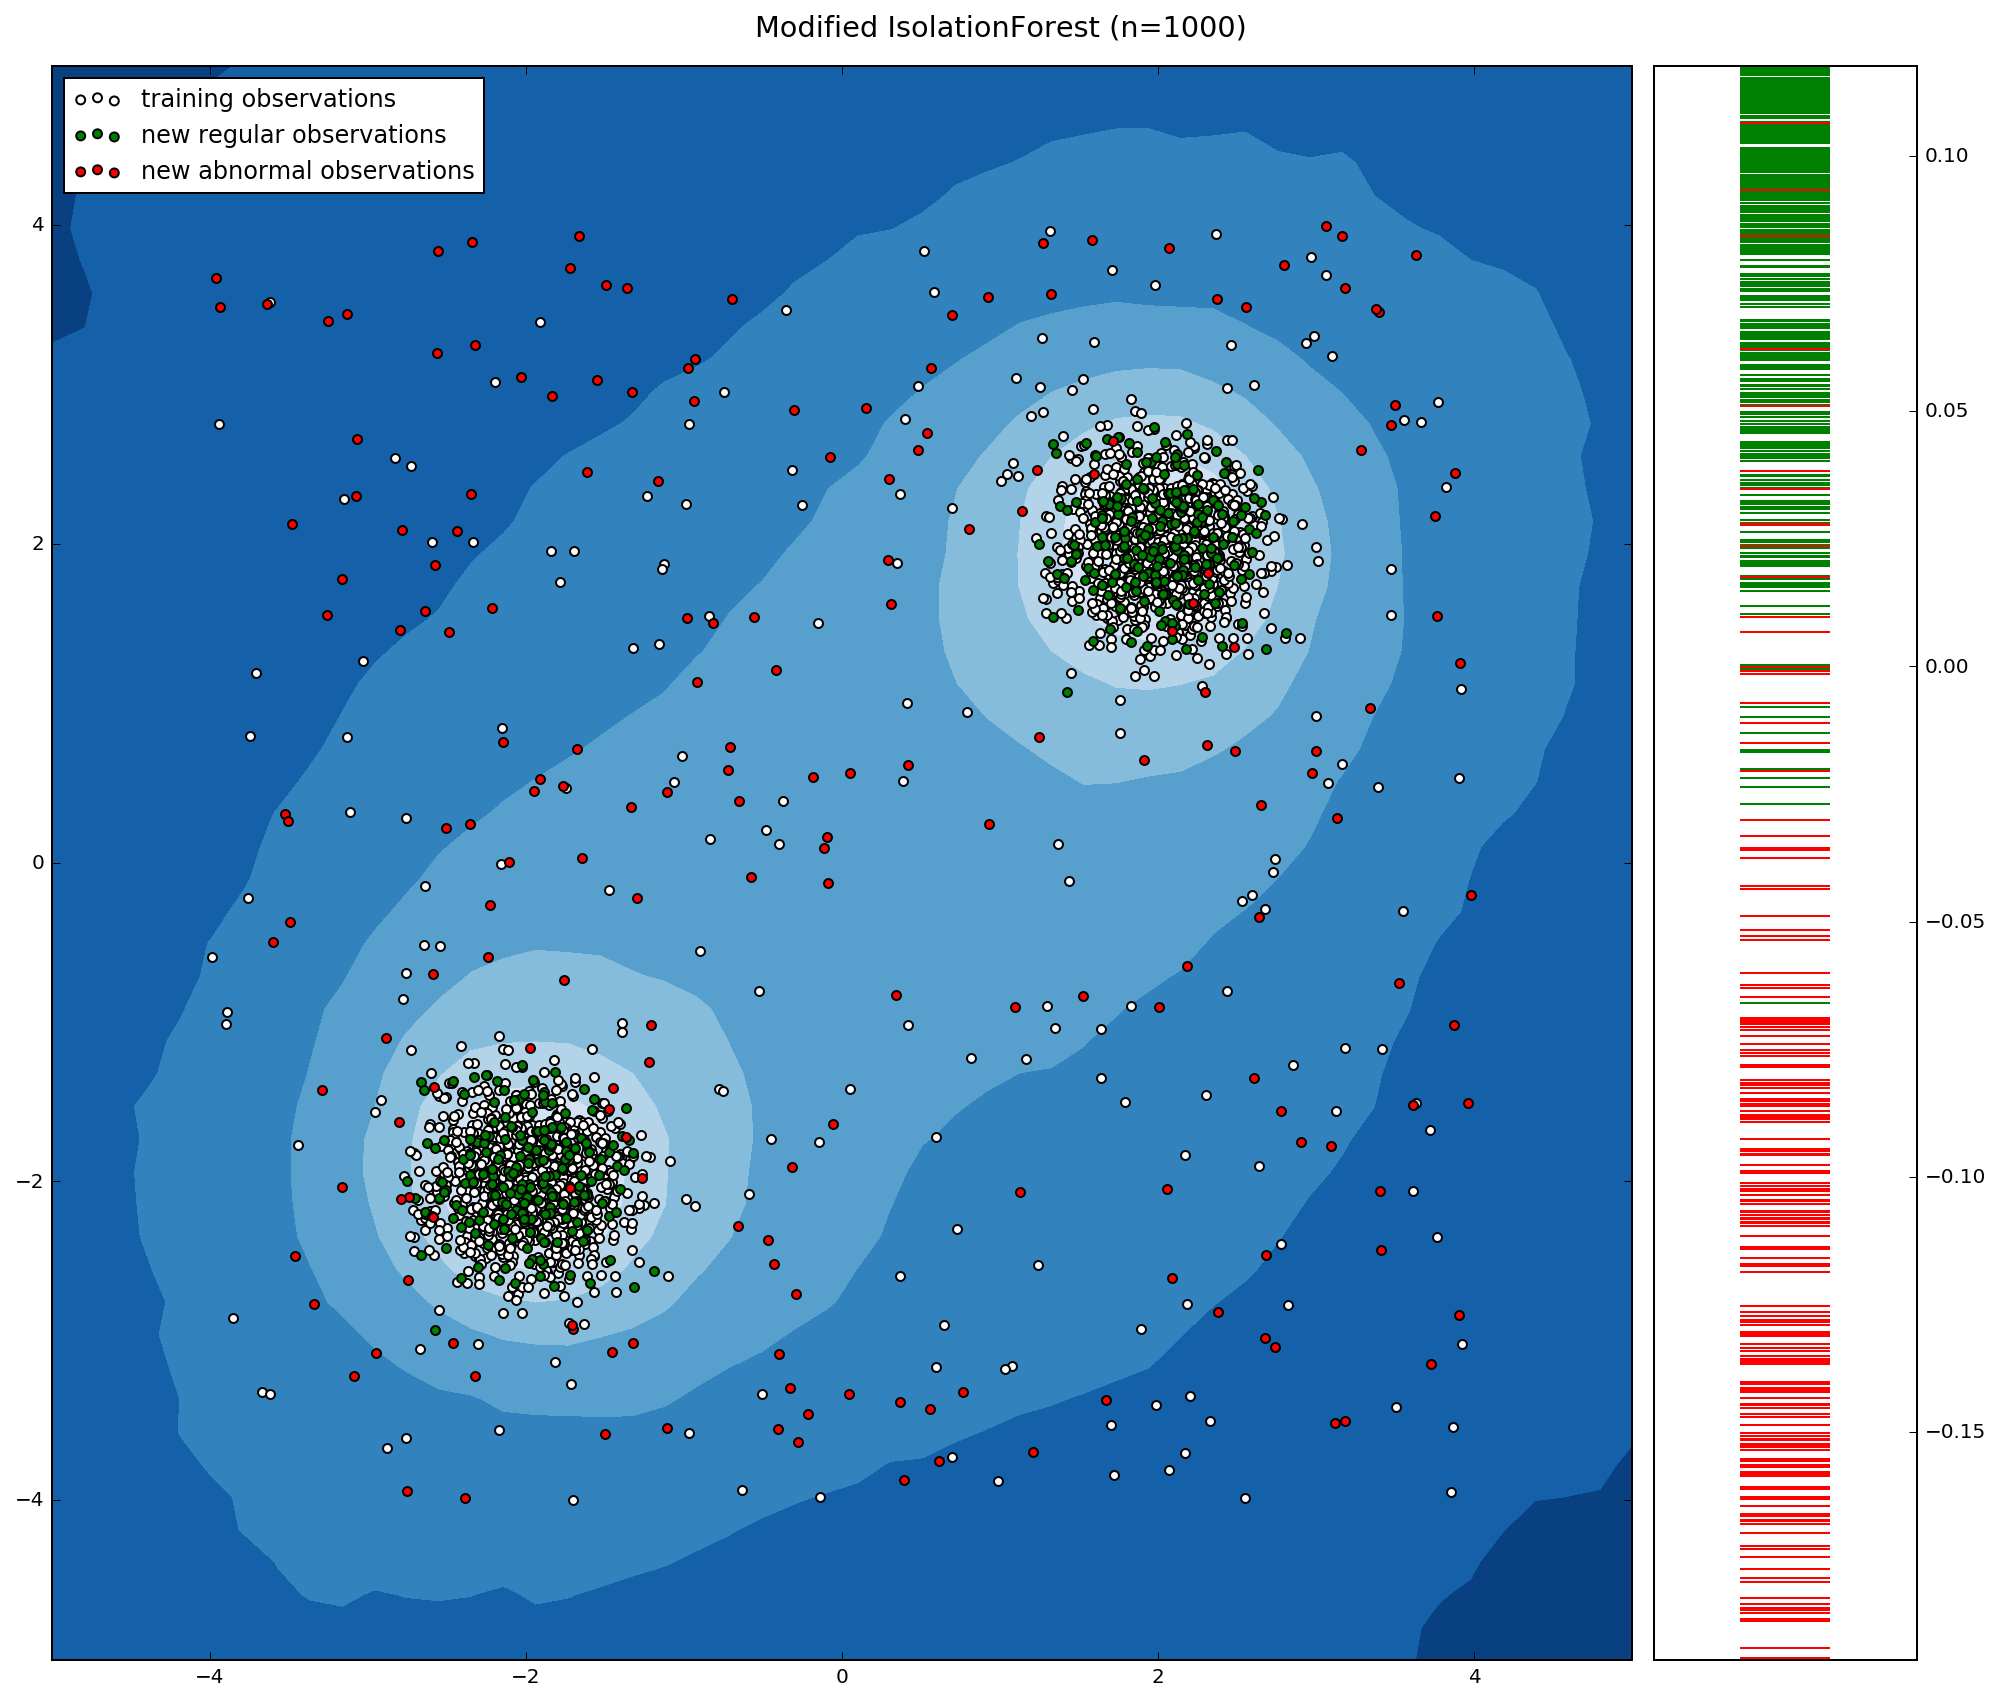

In [34]:
clf = modIsolationForest(1000)
clf.fit(Xnoised_train)
y_pred_train = clf.decision_function(Xnoised_train)
y_pred_test = clf.decision_function(Xnoised_test)
y_pred_outliers = clf.decision_function(Xnoised_outliers)

print(score(y_pred_test, y_pred_outliers))
coolPlot("Modified IsolationForest (n=1000)", clf.decision_function, Xnoised_train, Xnoised_test, Xnoised_outliers)

0.984


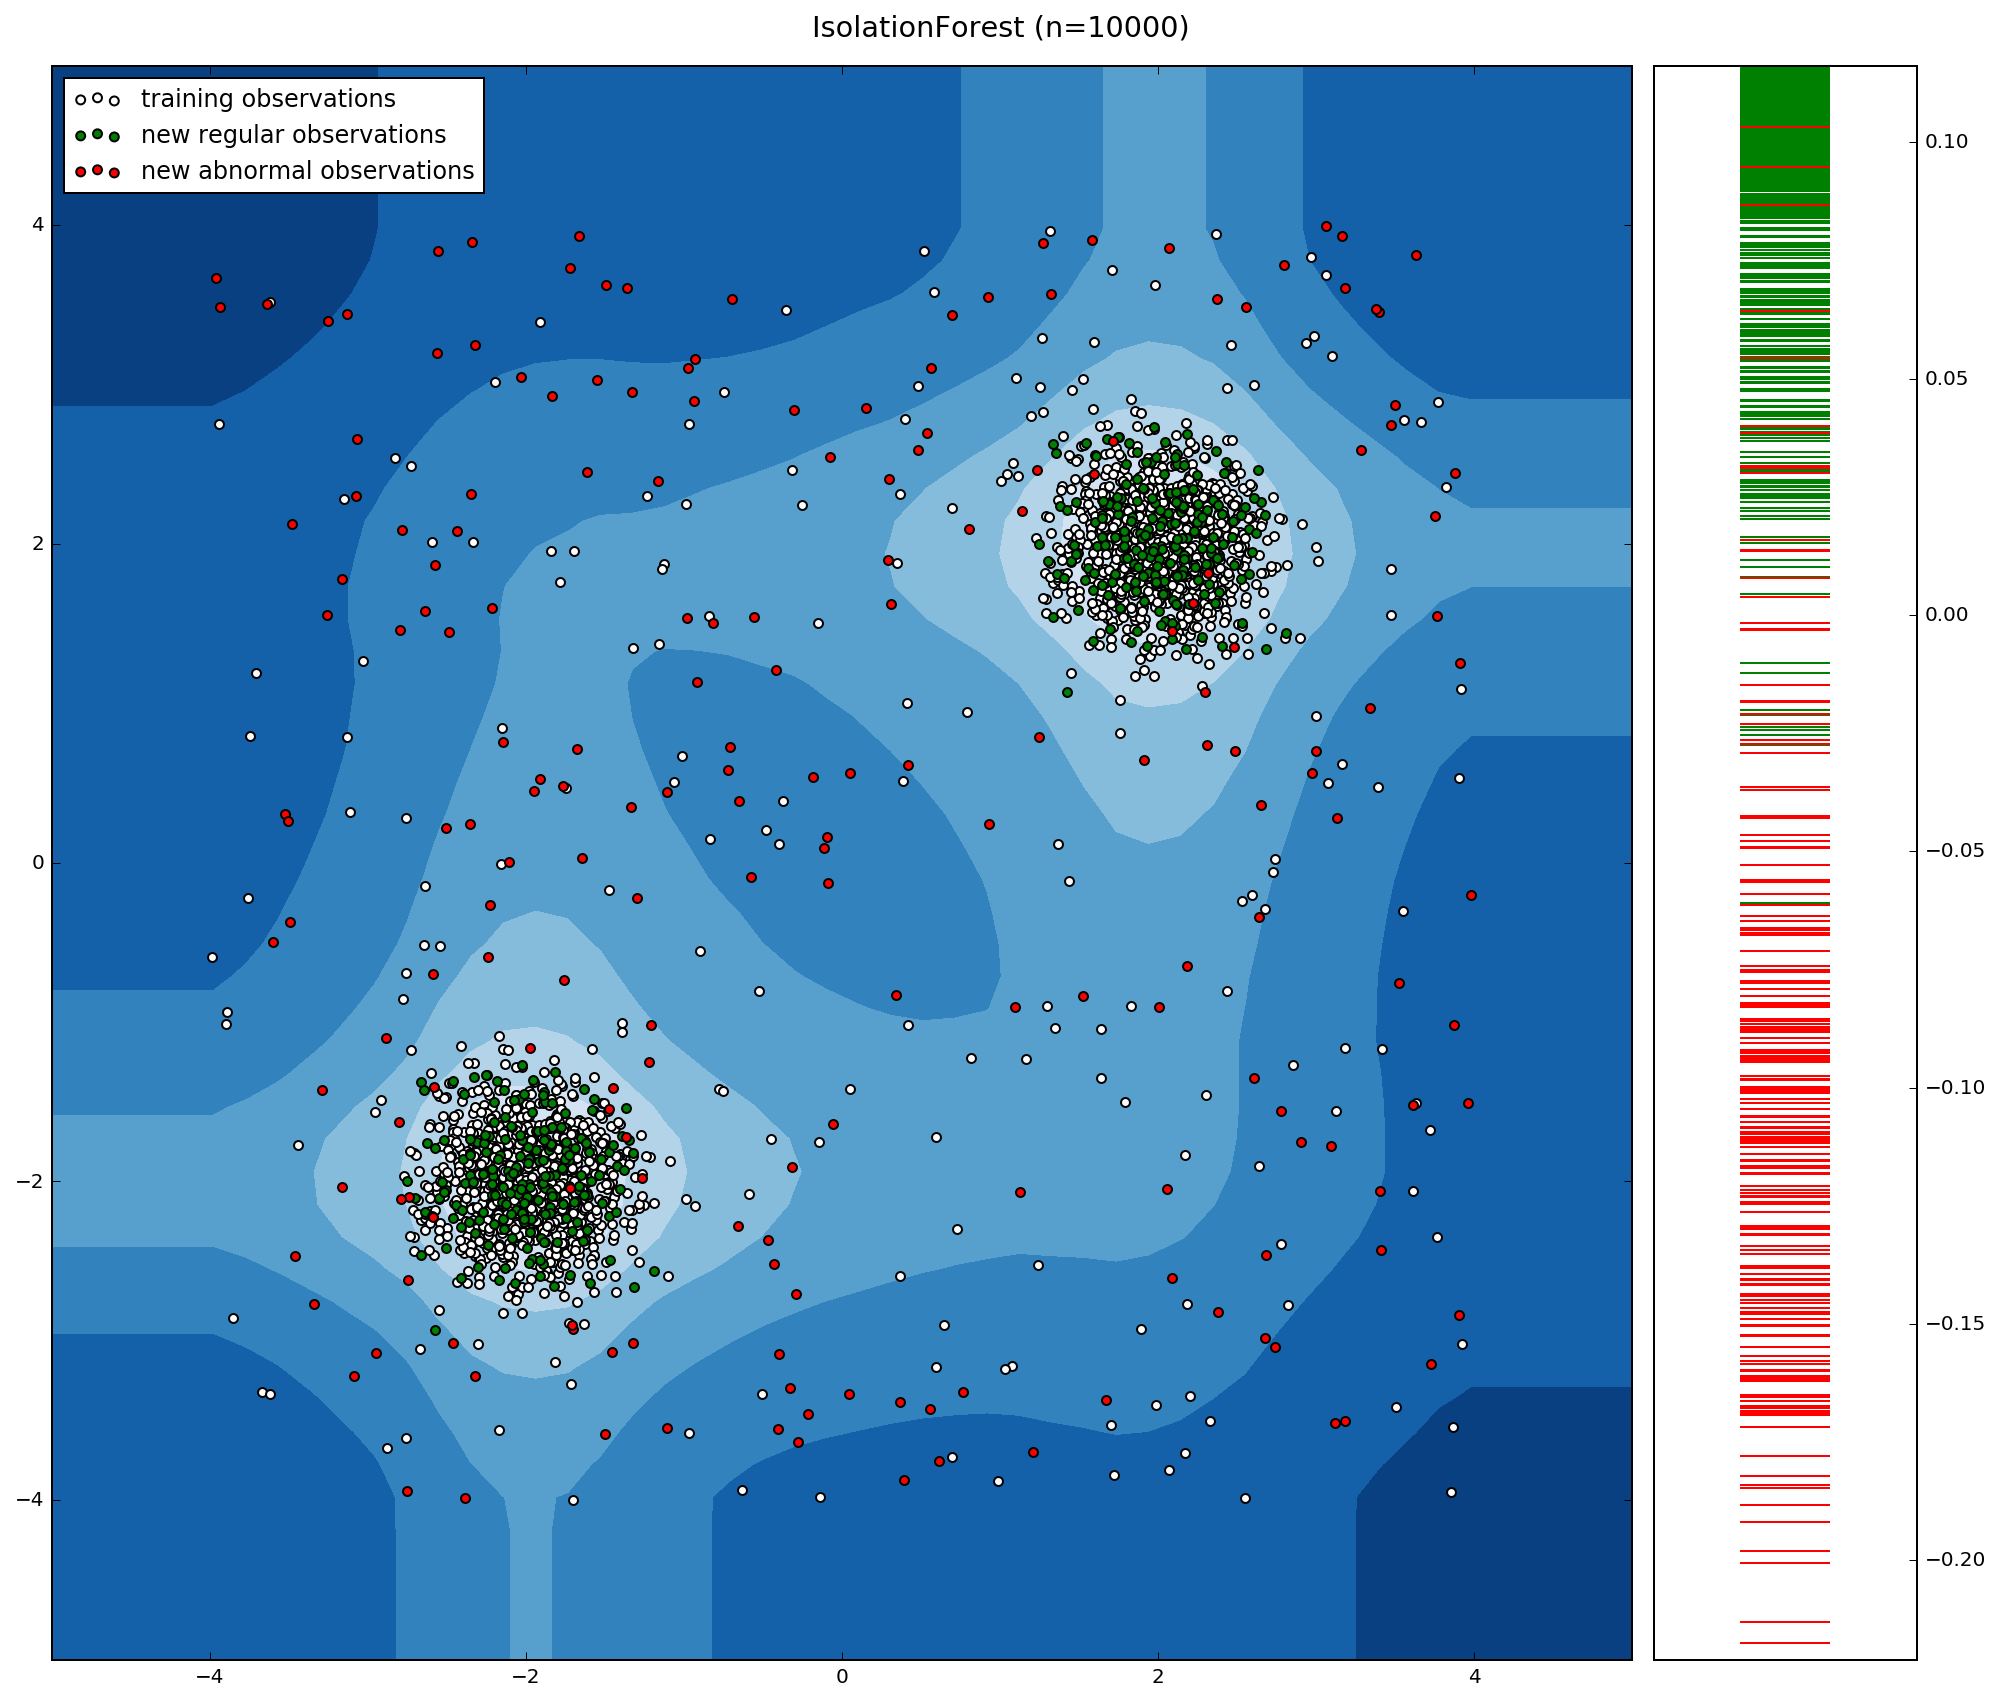

In [35]:
clf = IsolationForest(10000)
clf.fit(Xnoised_train)
y_pred_train = clf.decision_function(Xnoised_train)
y_pred_test = clf.decision_function(Xnoised_test)
y_pred_outliers = clf.decision_function(Xnoised_outliers)

print(score(y_pred_test, y_pred_outliers))
coolPlot("IsolationForest (n=10000)", clf.decision_function, Xnoised_train, Xnoised_test, Xnoised_outliers)

0.9845125


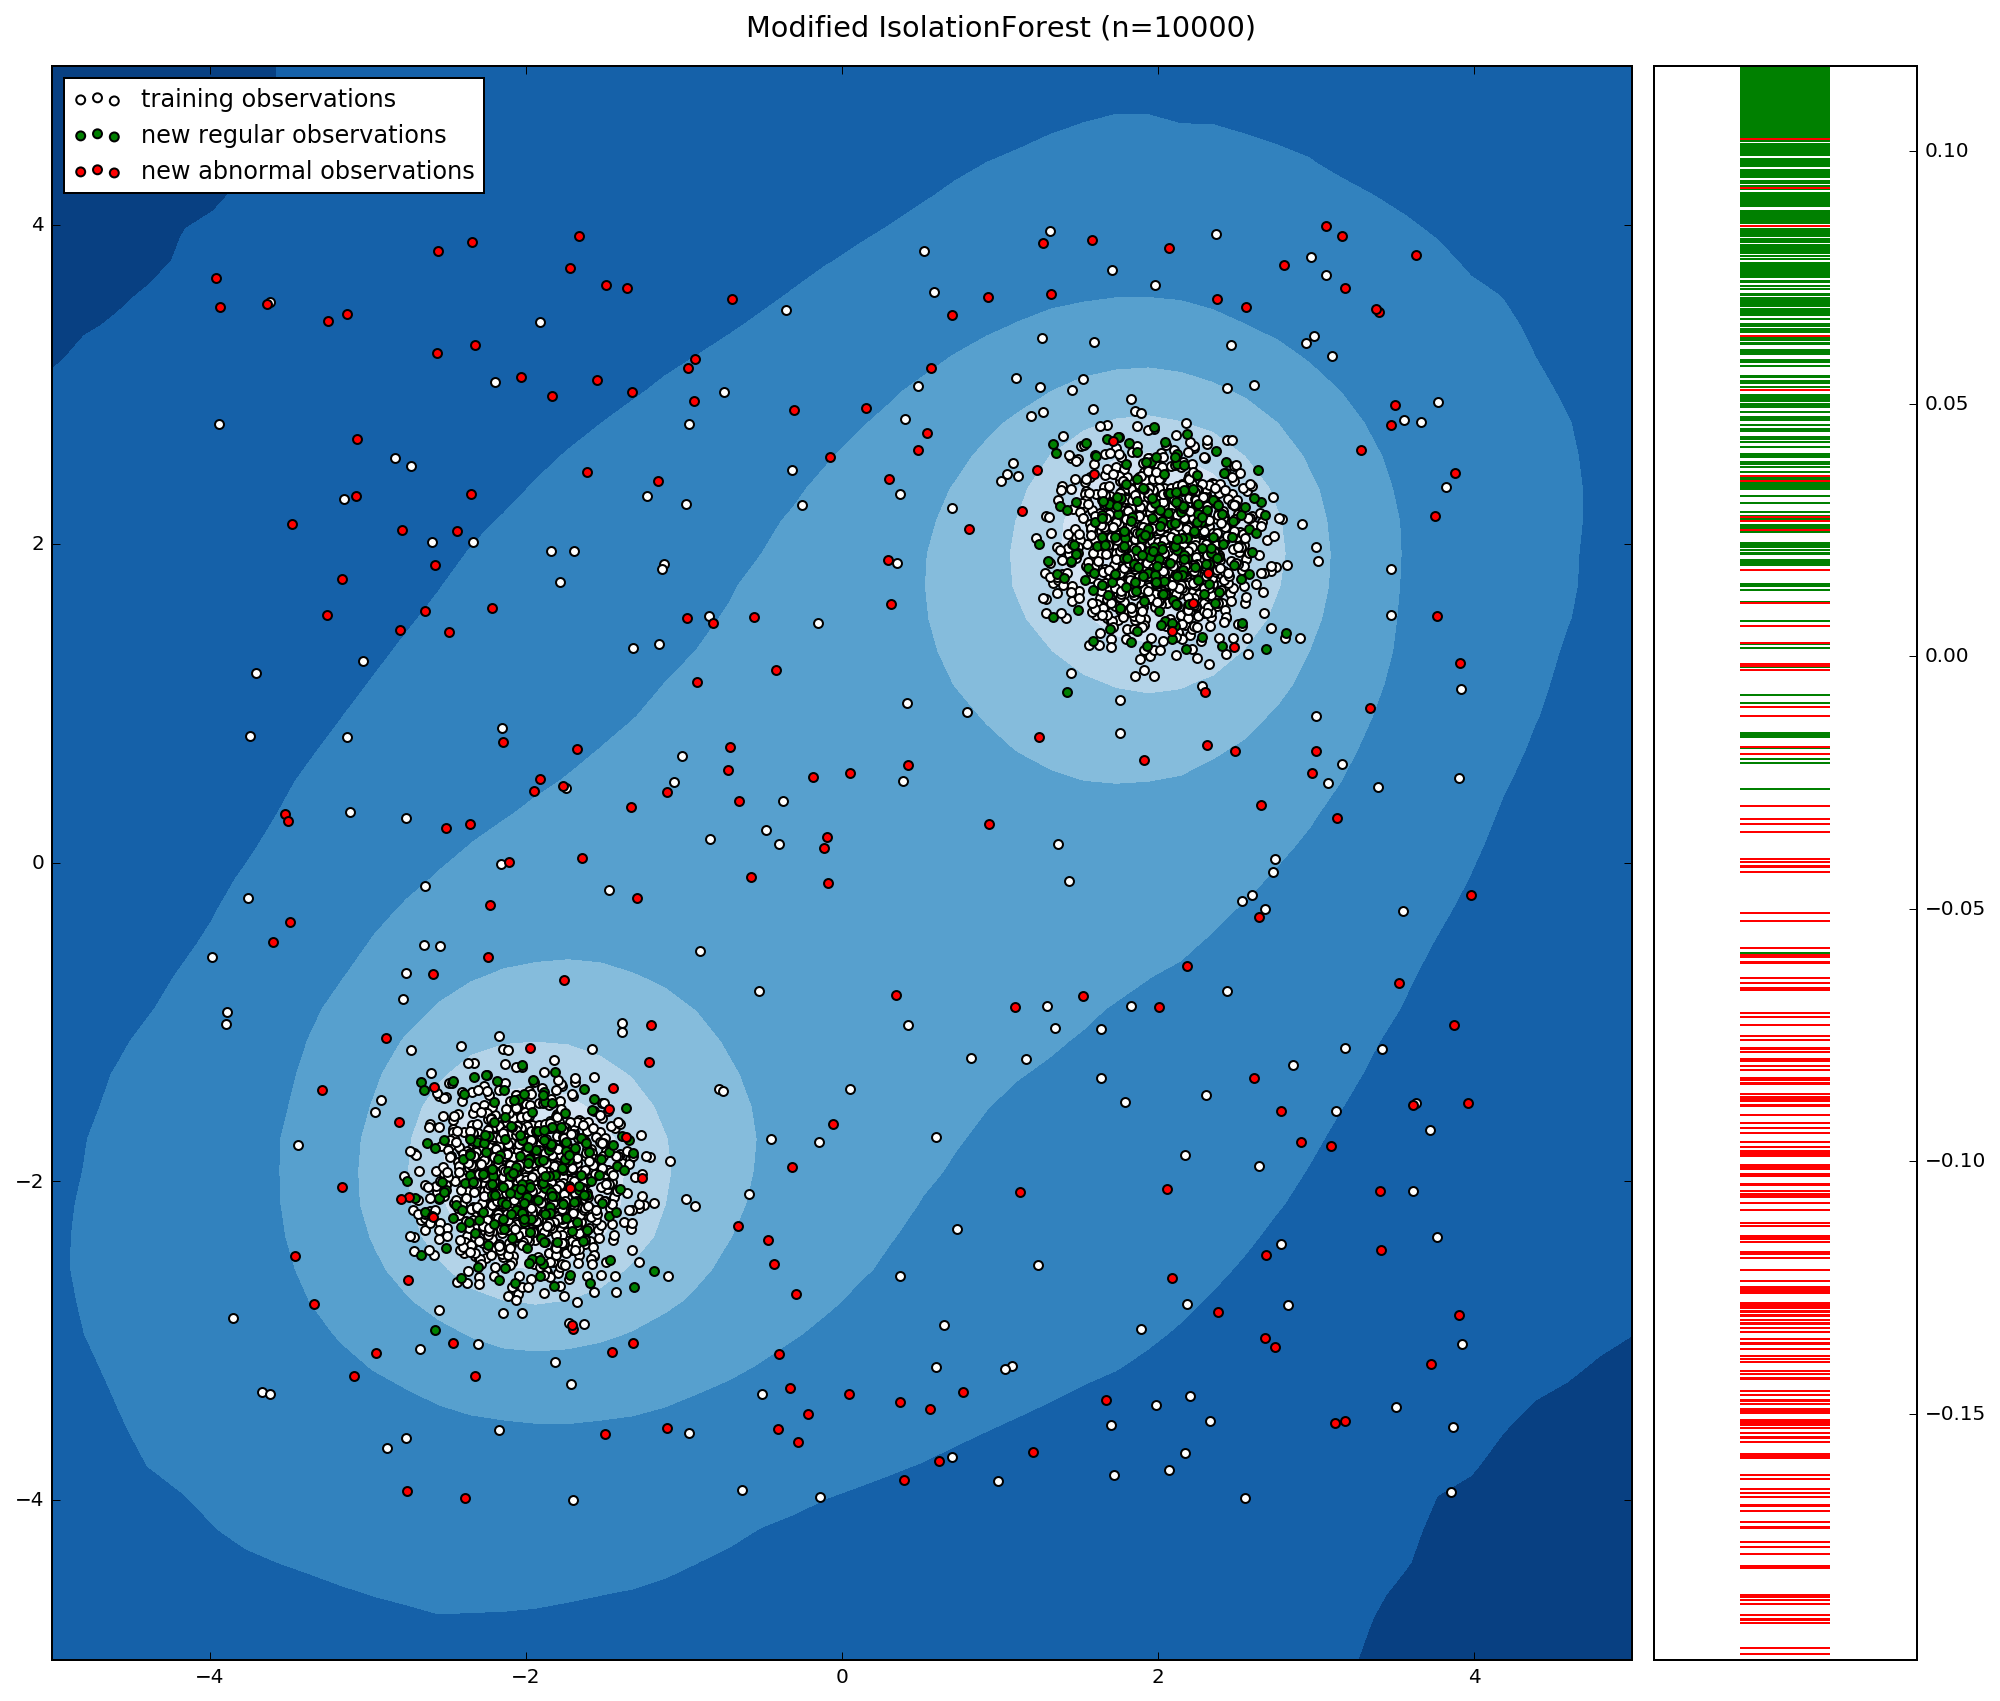

In [36]:
clf = modIsolationForest(10000)
clf.fit(Xnoised_train)
y_pred_train = clf.decision_function(Xnoised_train)
y_pred_test = clf.decision_function(Xnoised_test)
y_pred_outliers = clf.decision_function(Xnoised_outliers)

print(score(y_pred_test, y_pred_outliers))
coolPlot("Modified IsolationForest (n=10000)", clf.decision_function, Xnoised_train, Xnoised_test, Xnoised_outliers)

Интересно, нельзя ли так плотность распределения "за линию" аппроксимировать?

Попробуем что-нибудь ещё, например, синус.

In [37]:
# Создаём синус
x = rng.uniform(low=-4, high=4, size=1000)
sin_train = np.column_stack((x, 2 * np.sin(x)))
# Создаём ещё синуса
x = rng.uniform(low=-4, high=4, size=100)
sin_test = np.column_stack((x, 2 * np.sin(x)))
# Не синус
sin_outliers = rng.uniform(low=-4, high=4, size=(100, 2))

0.9083


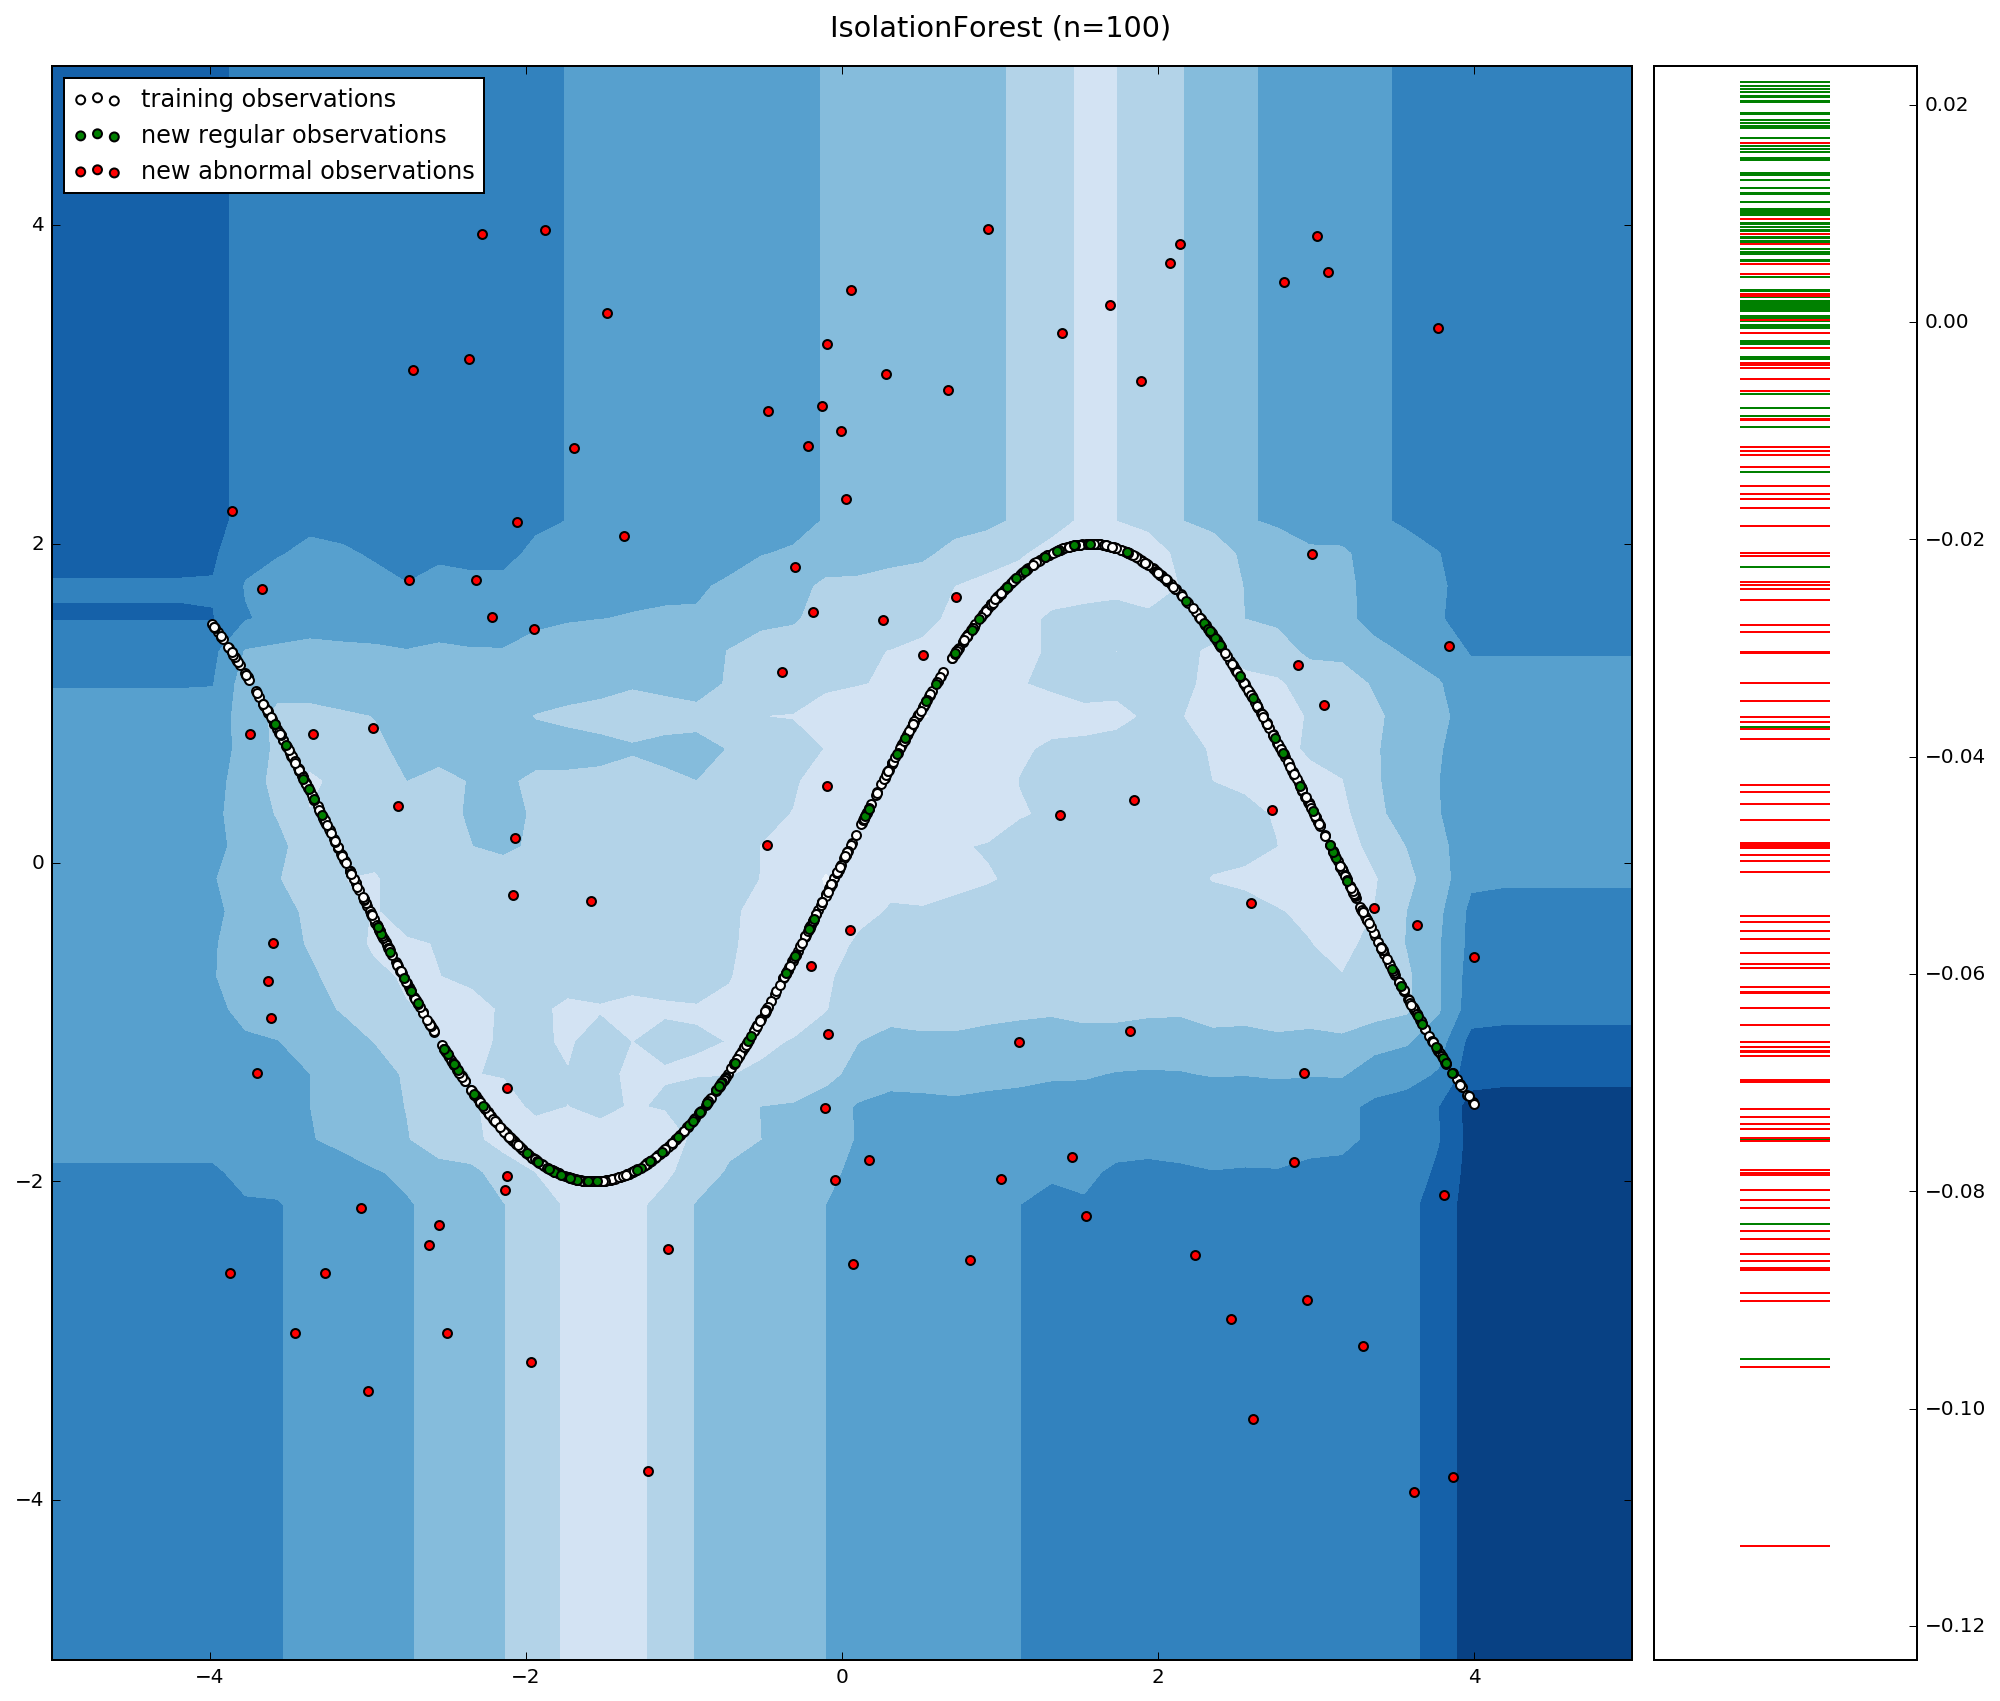

In [38]:
# Применим классический IsolationForest
clf = IsolationForest(100)
clf.fit(sin_train)
y_pred_train = clf.decision_function(sin_train)
y_pred_test = clf.decision_function(sin_test)
y_pred_outliers = clf.decision_function(sin_outliers)

print(score(y_pred_test, y_pred_outliers))
coolPlot("IsolationForest (n=100)", clf.decision_function, sin_train, sin_test, sin_outliers)

0.9135


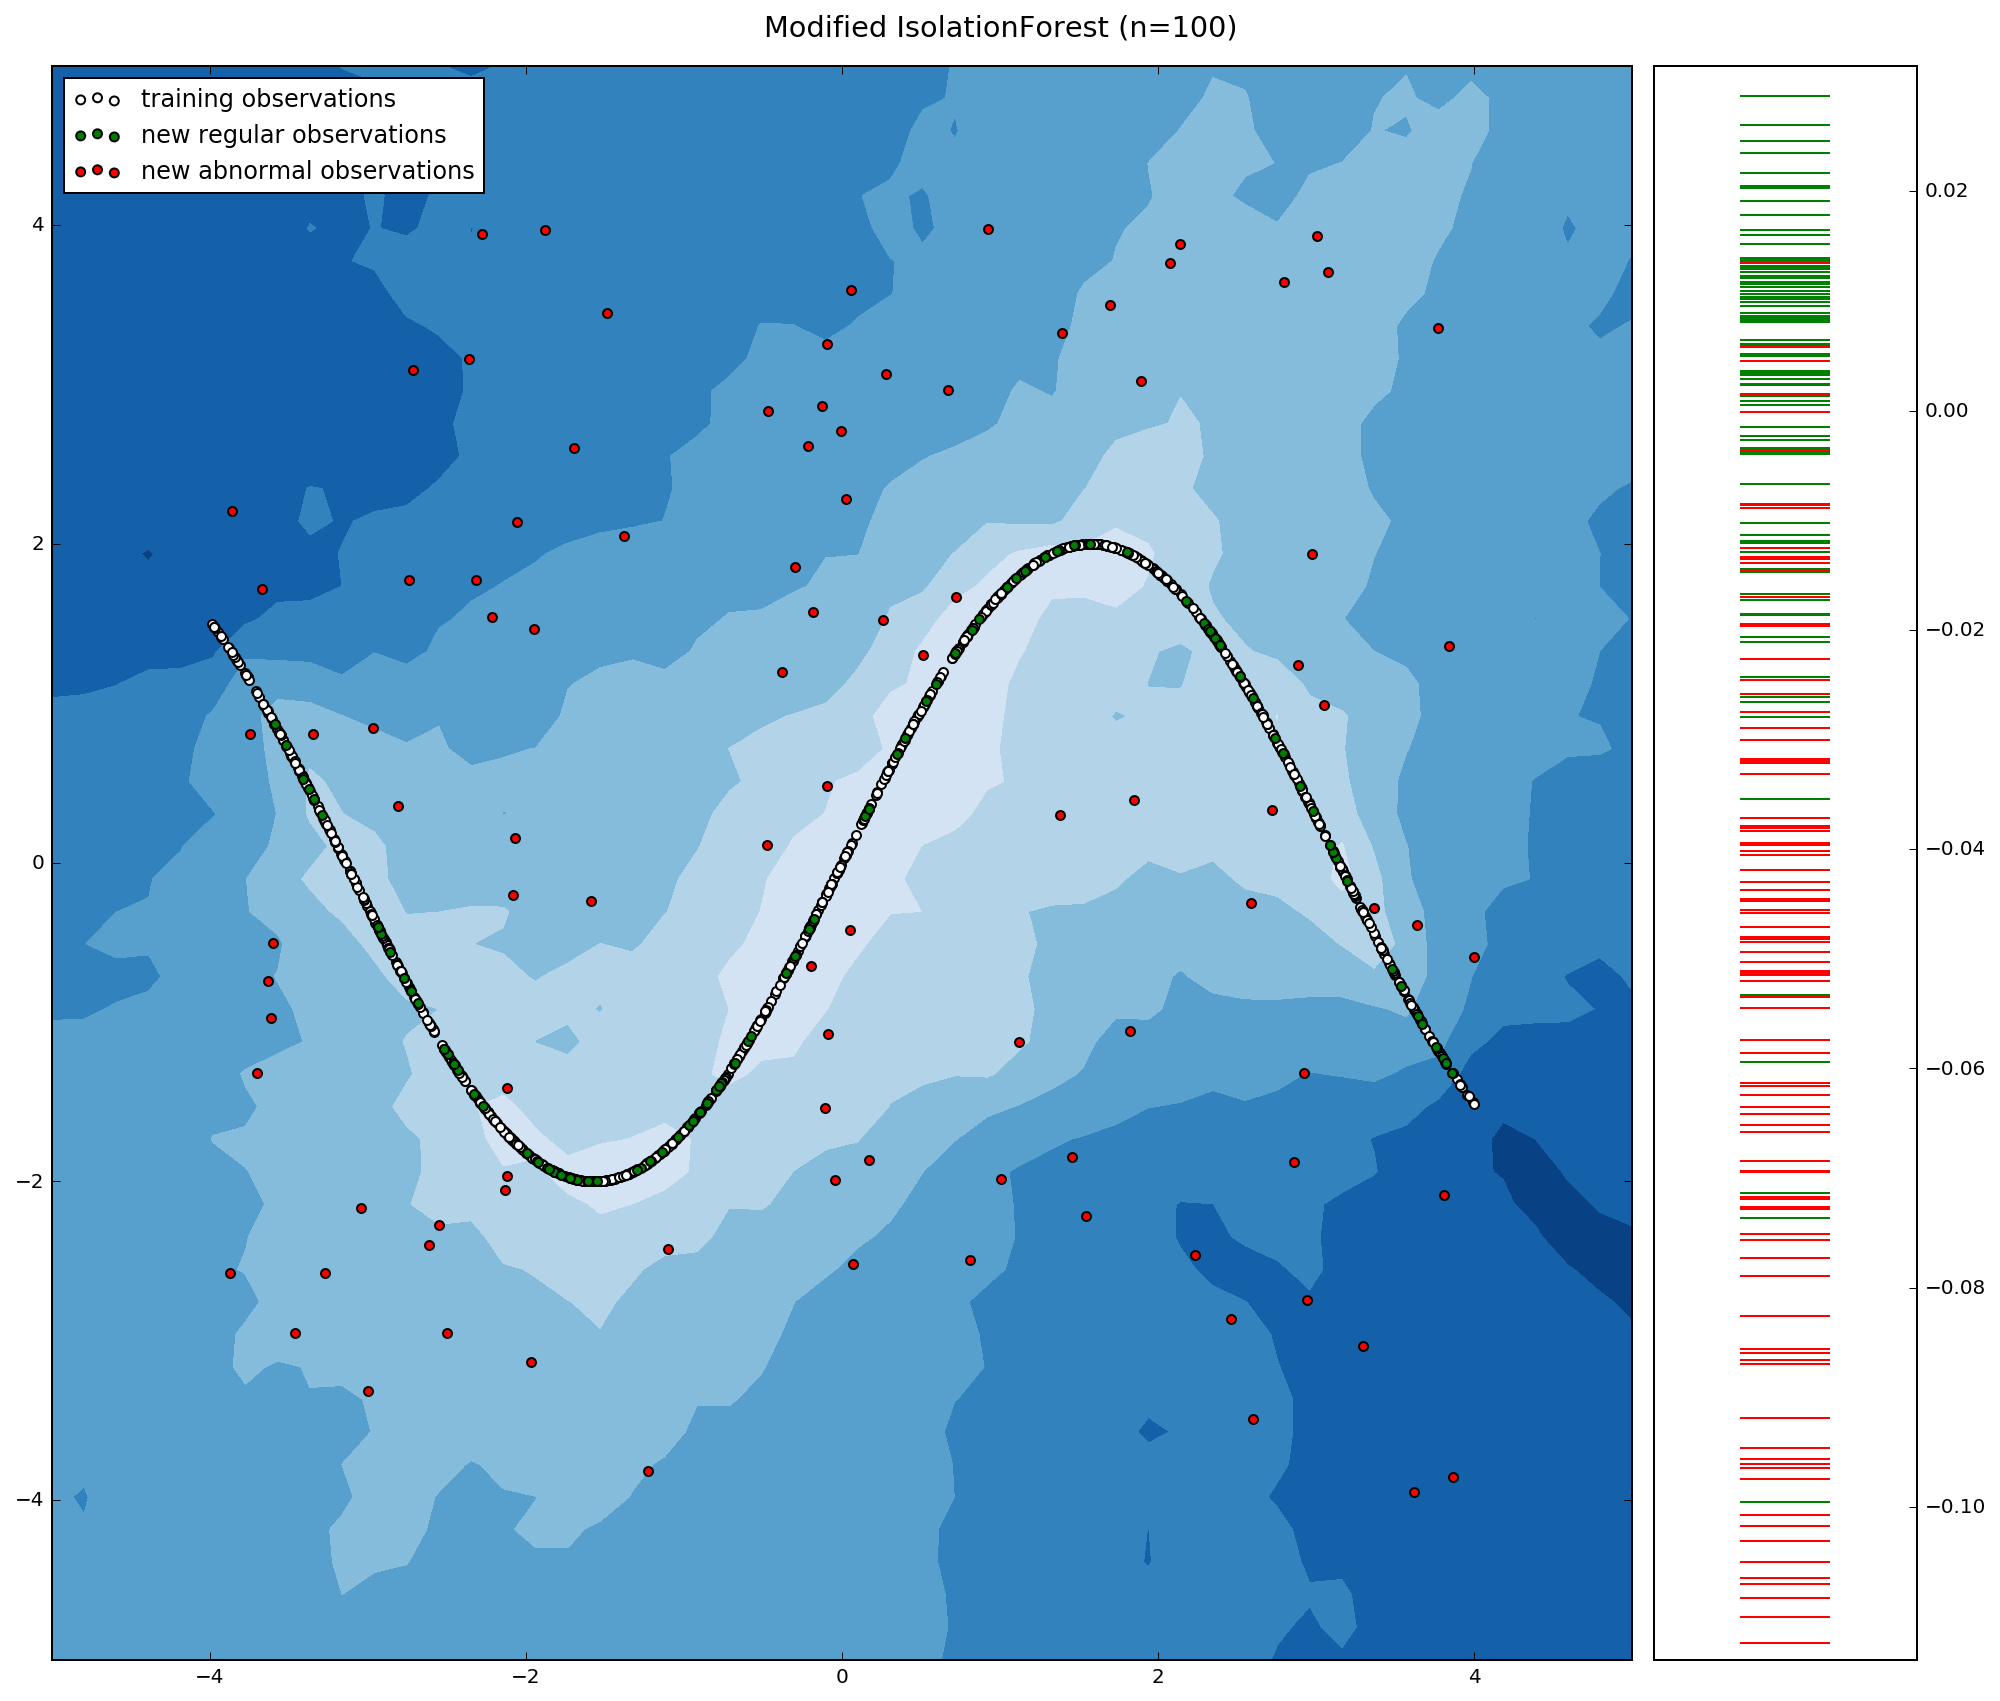

In [39]:
# Применим модифицированный IsolationForest
clf = modIsolationForest(100)
clf.fit(sin_train)
y_pred_train = clf.decision_function(sin_train)
y_pred_test = clf.decision_function(sin_test)
y_pred_outliers = clf.decision_function(sin_outliers)

print(score(y_pred_test, y_pred_outliers))
coolPlot("Modified IsolationForest (n=100)", clf.decision_function, sin_train, sin_test, sin_outliers)

Немного шума в нашей жизни!

In [40]:
# Создаём синус
x = rng.uniform(low=-4, high=4, size=1000)
sin_train = np.column_stack((x, 2 * np.sin(x))) + rng.randn(1000, 2)*0.2
# Создаём ещё синуса
x = rng.uniform(low=-4, high=4, size=100)
sin_test = np.column_stack((x, 2 * np.sin(x))) + rng.randn(100, 2)*0.2
# Не синус
sin_outliers = rng.uniform(low=-4, high=4, size=(100, 2))

0.8974


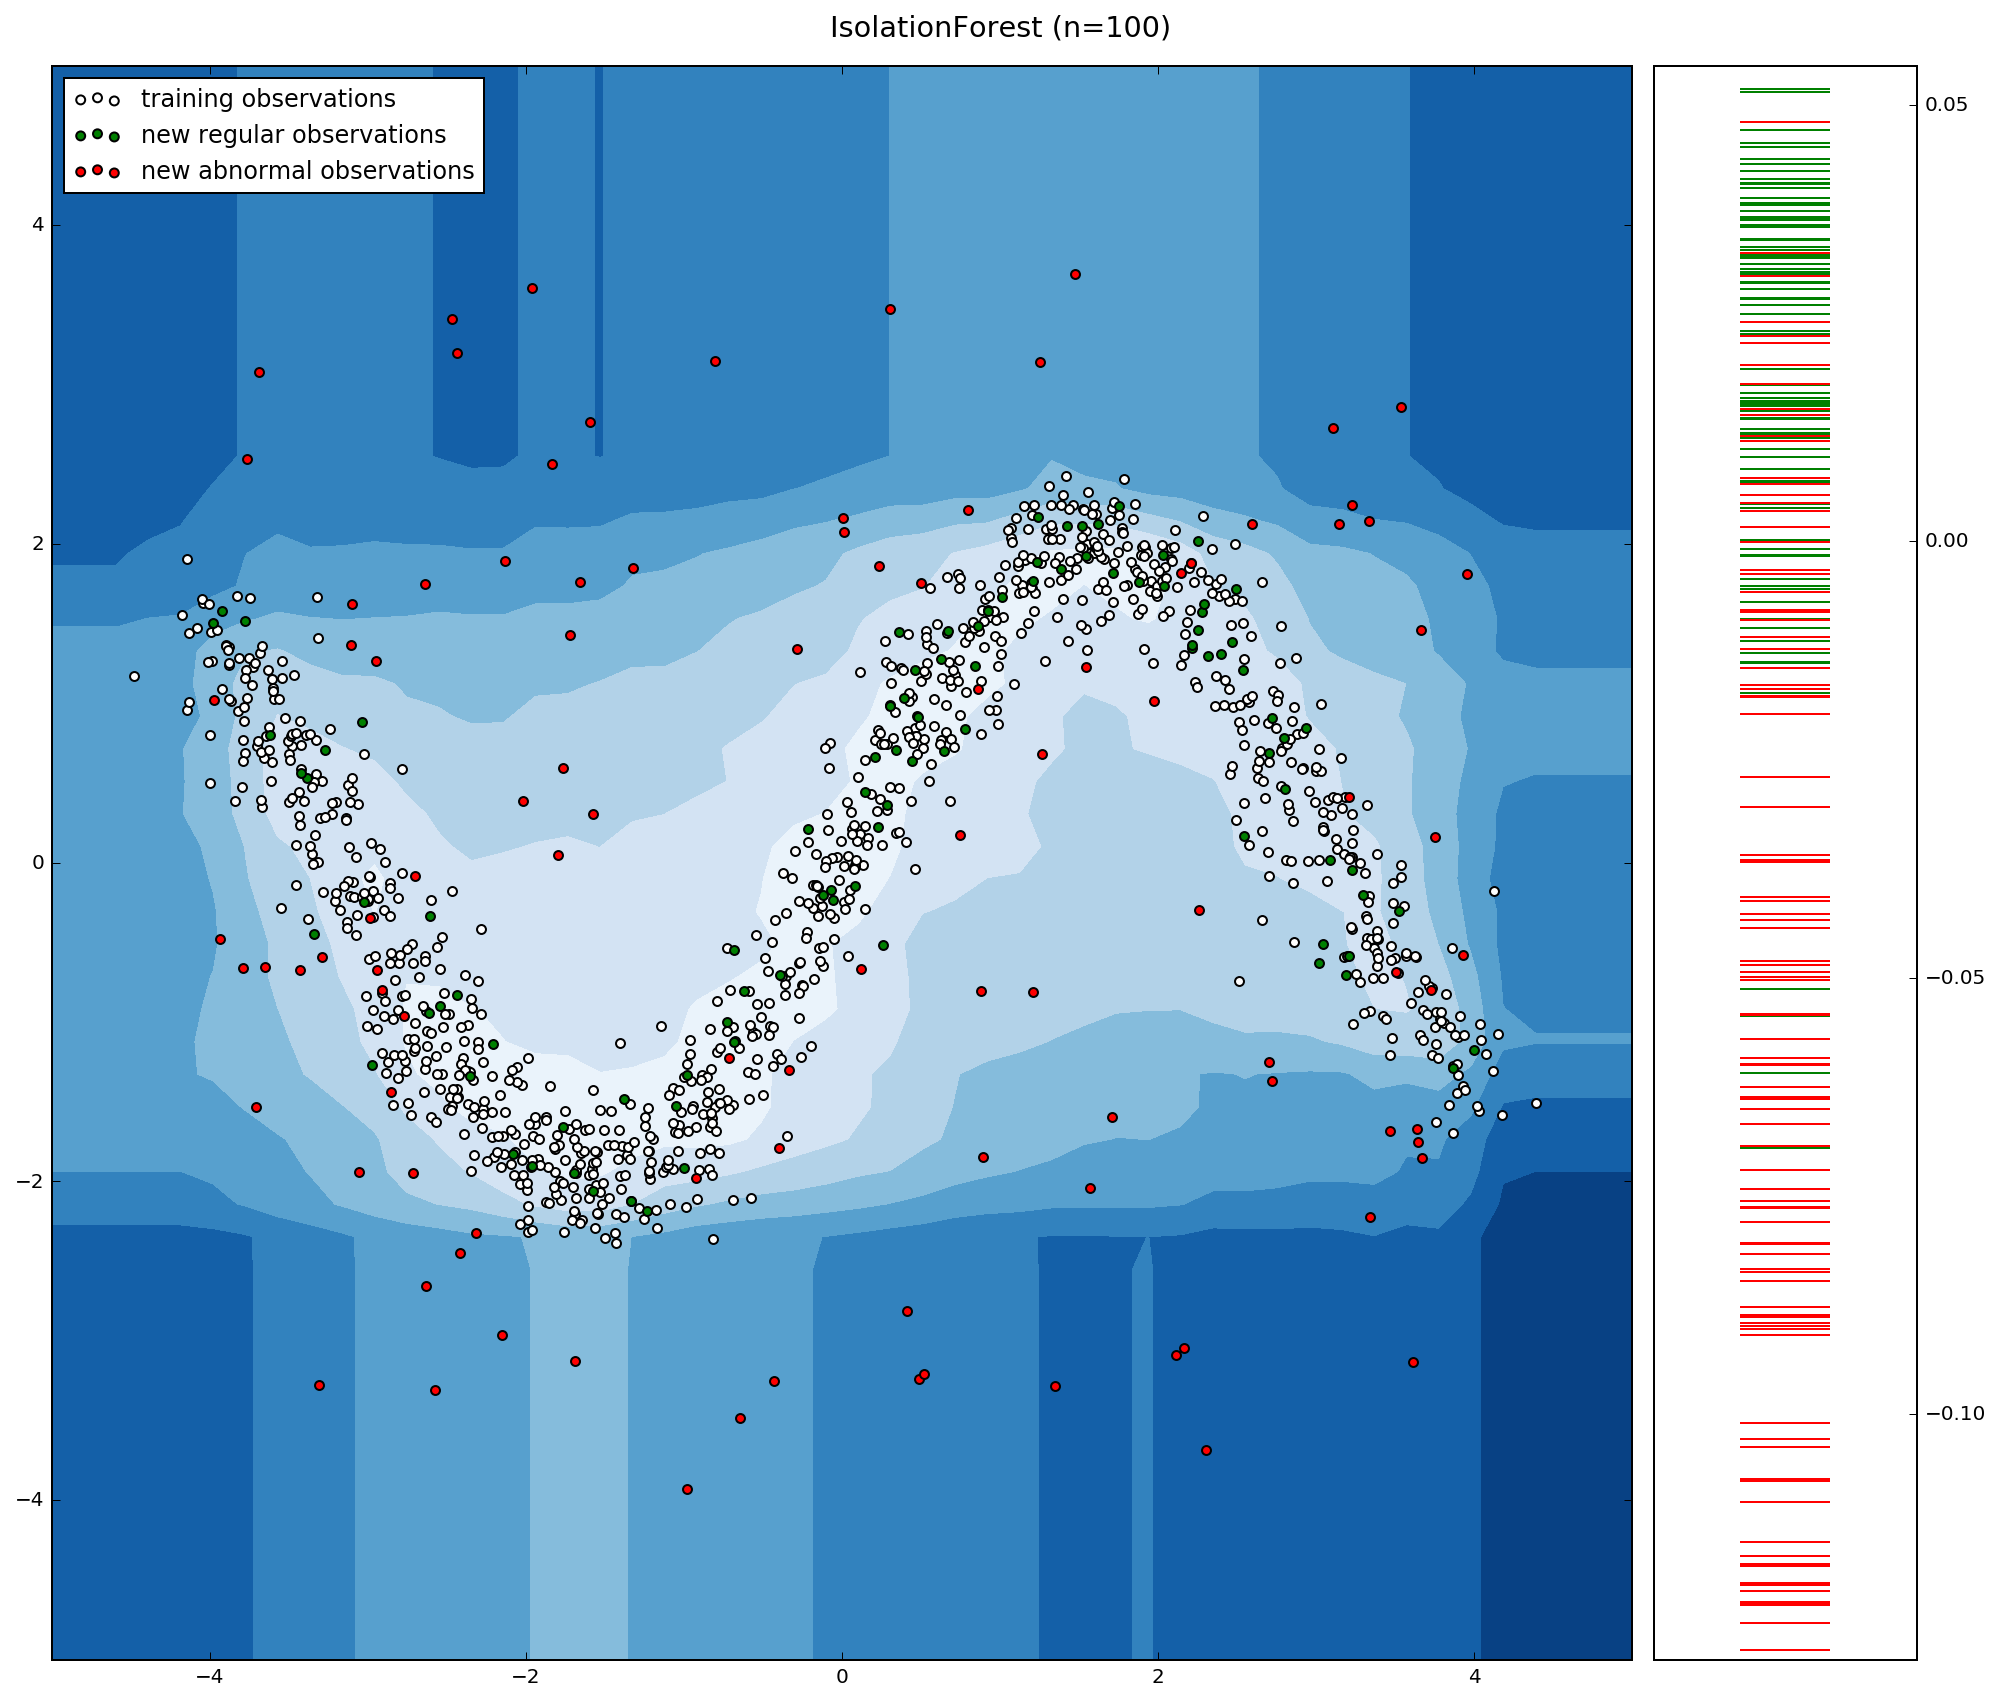

In [41]:
clf = IsolationForest(100)
clf.fit(sin_train)
y_pred_train = clf.decision_function(sin_train)
y_pred_test = clf.decision_function(sin_test)
y_pred_outliers = clf.decision_function(sin_outliers)

print(score(y_pred_test, y_pred_outliers))
coolPlot("IsolationForest (n=100)", clf.decision_function, sin_train, sin_test, sin_outliers)

0.9149


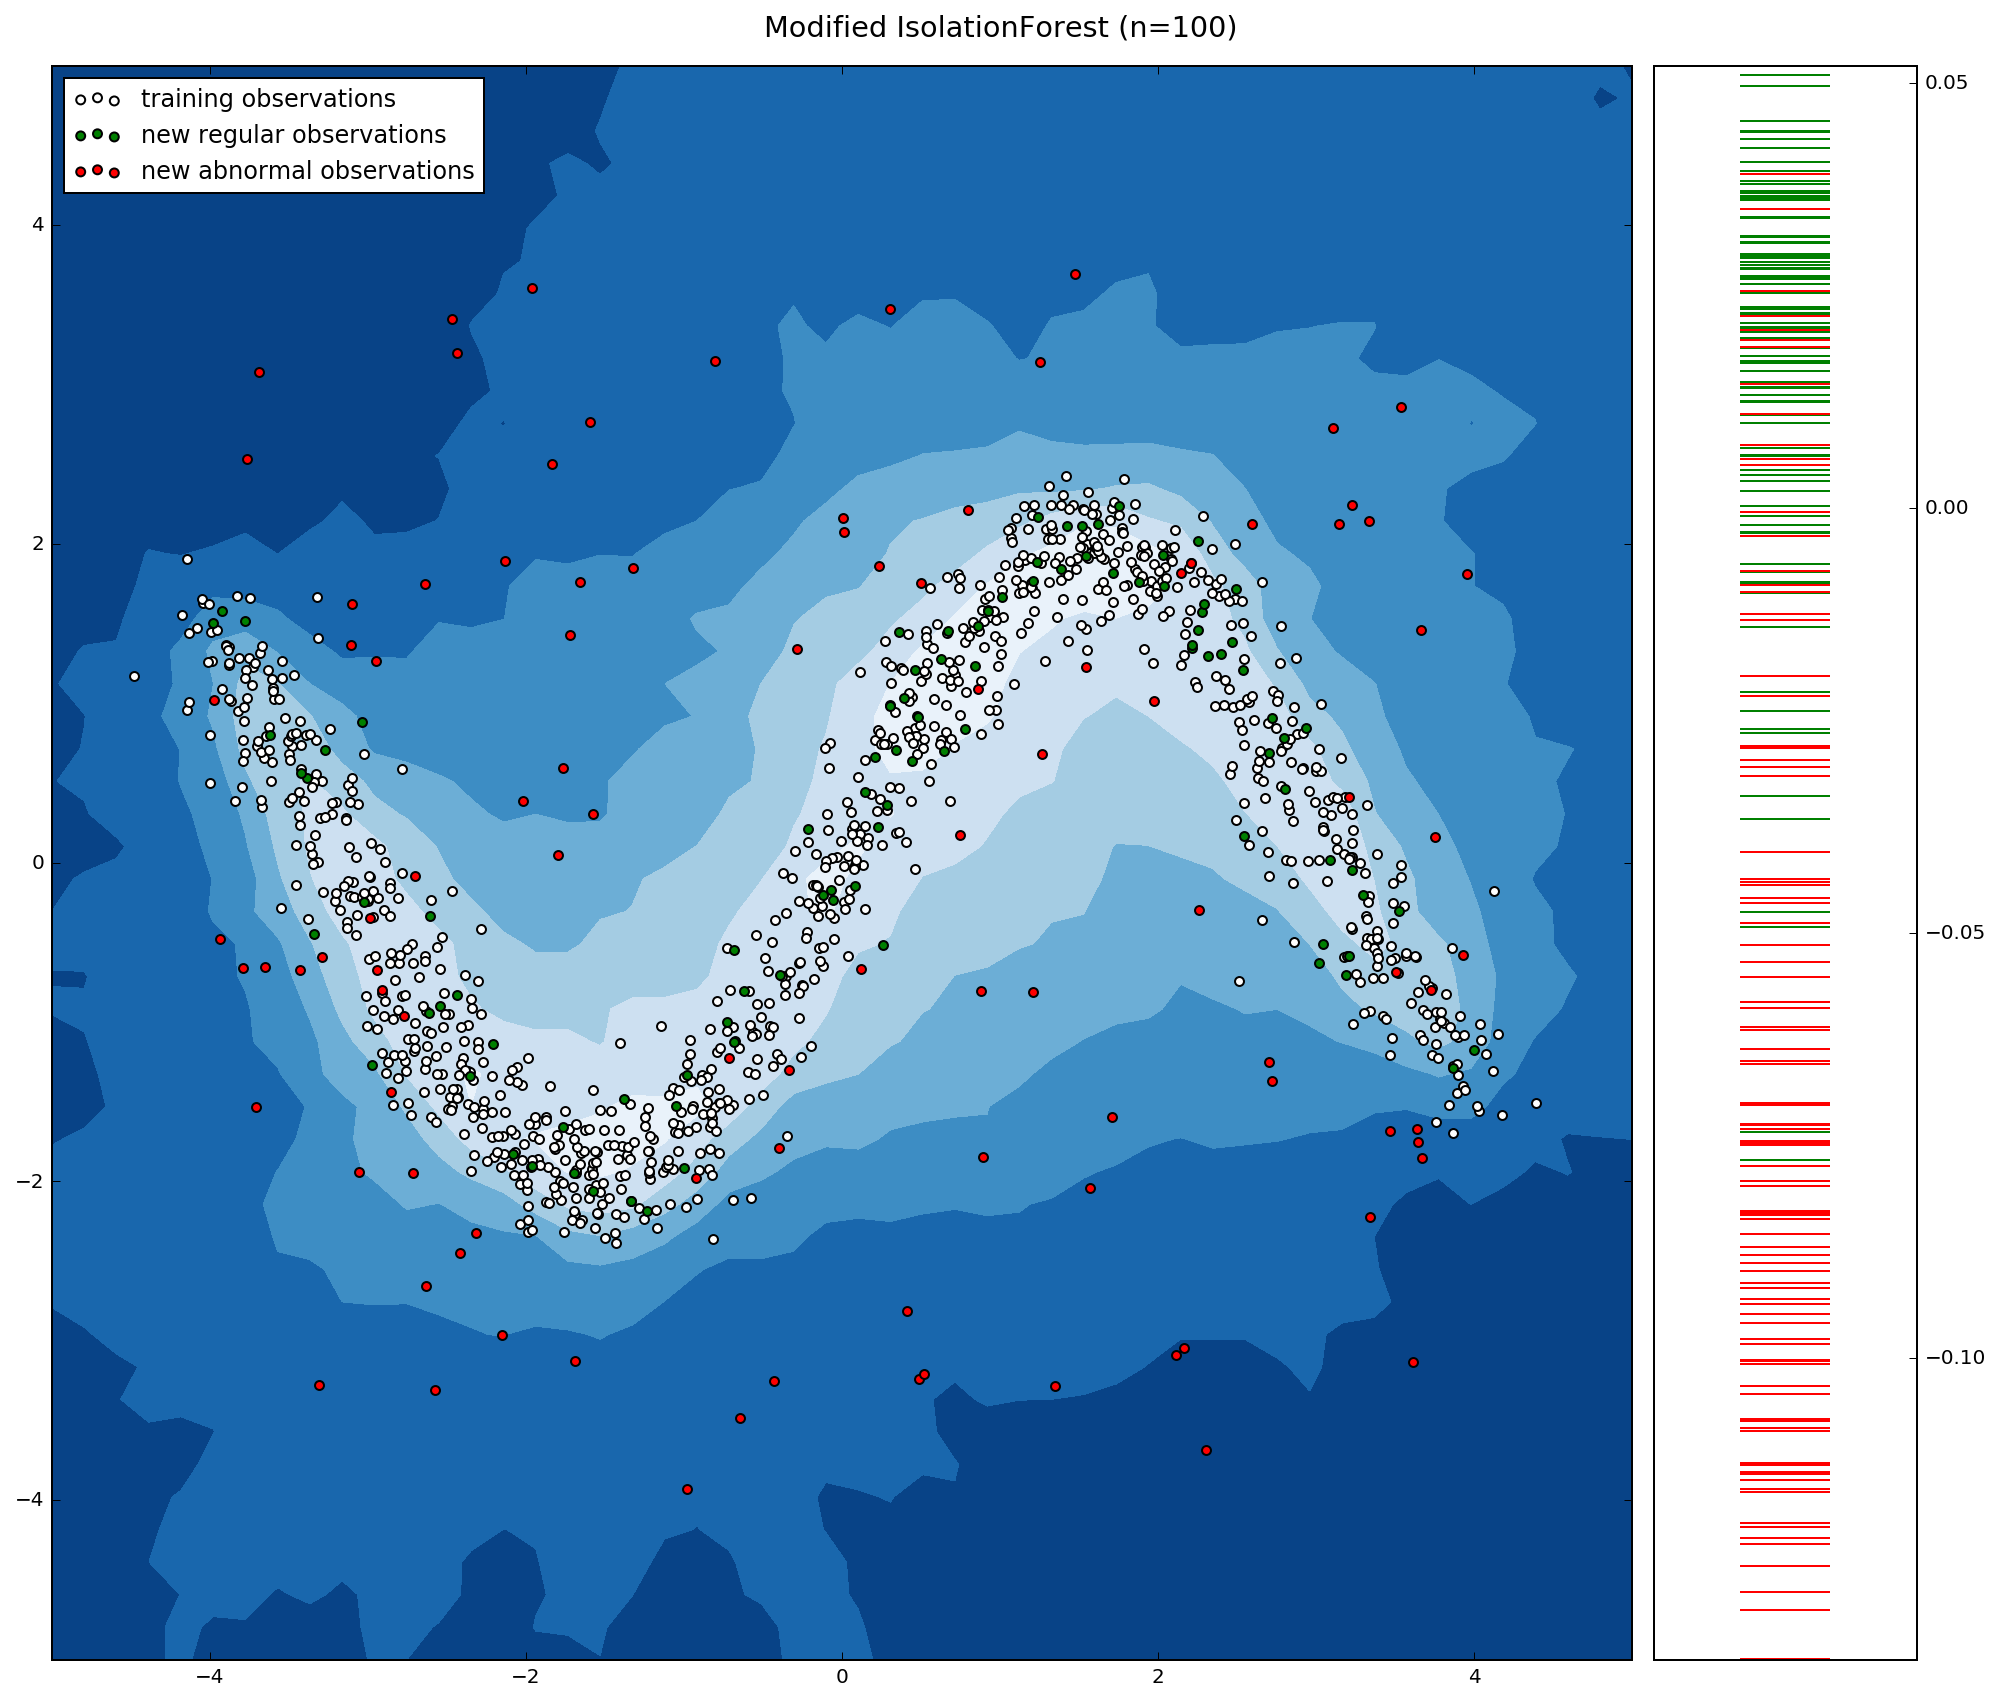

In [42]:
clf = modIsolationForest(100)
clf.fit(sin_train)
y_pred_train = clf.decision_function(sin_train)
y_pred_test = clf.decision_function(sin_test)
y_pred_outliers = clf.decision_function(sin_outliers)

print(score(y_pred_test, y_pred_outliers))
coolPlot("Modified IsolationForest (n=100)", clf.decision_function, sin_train, sin_test, sin_outliers)

0.9101


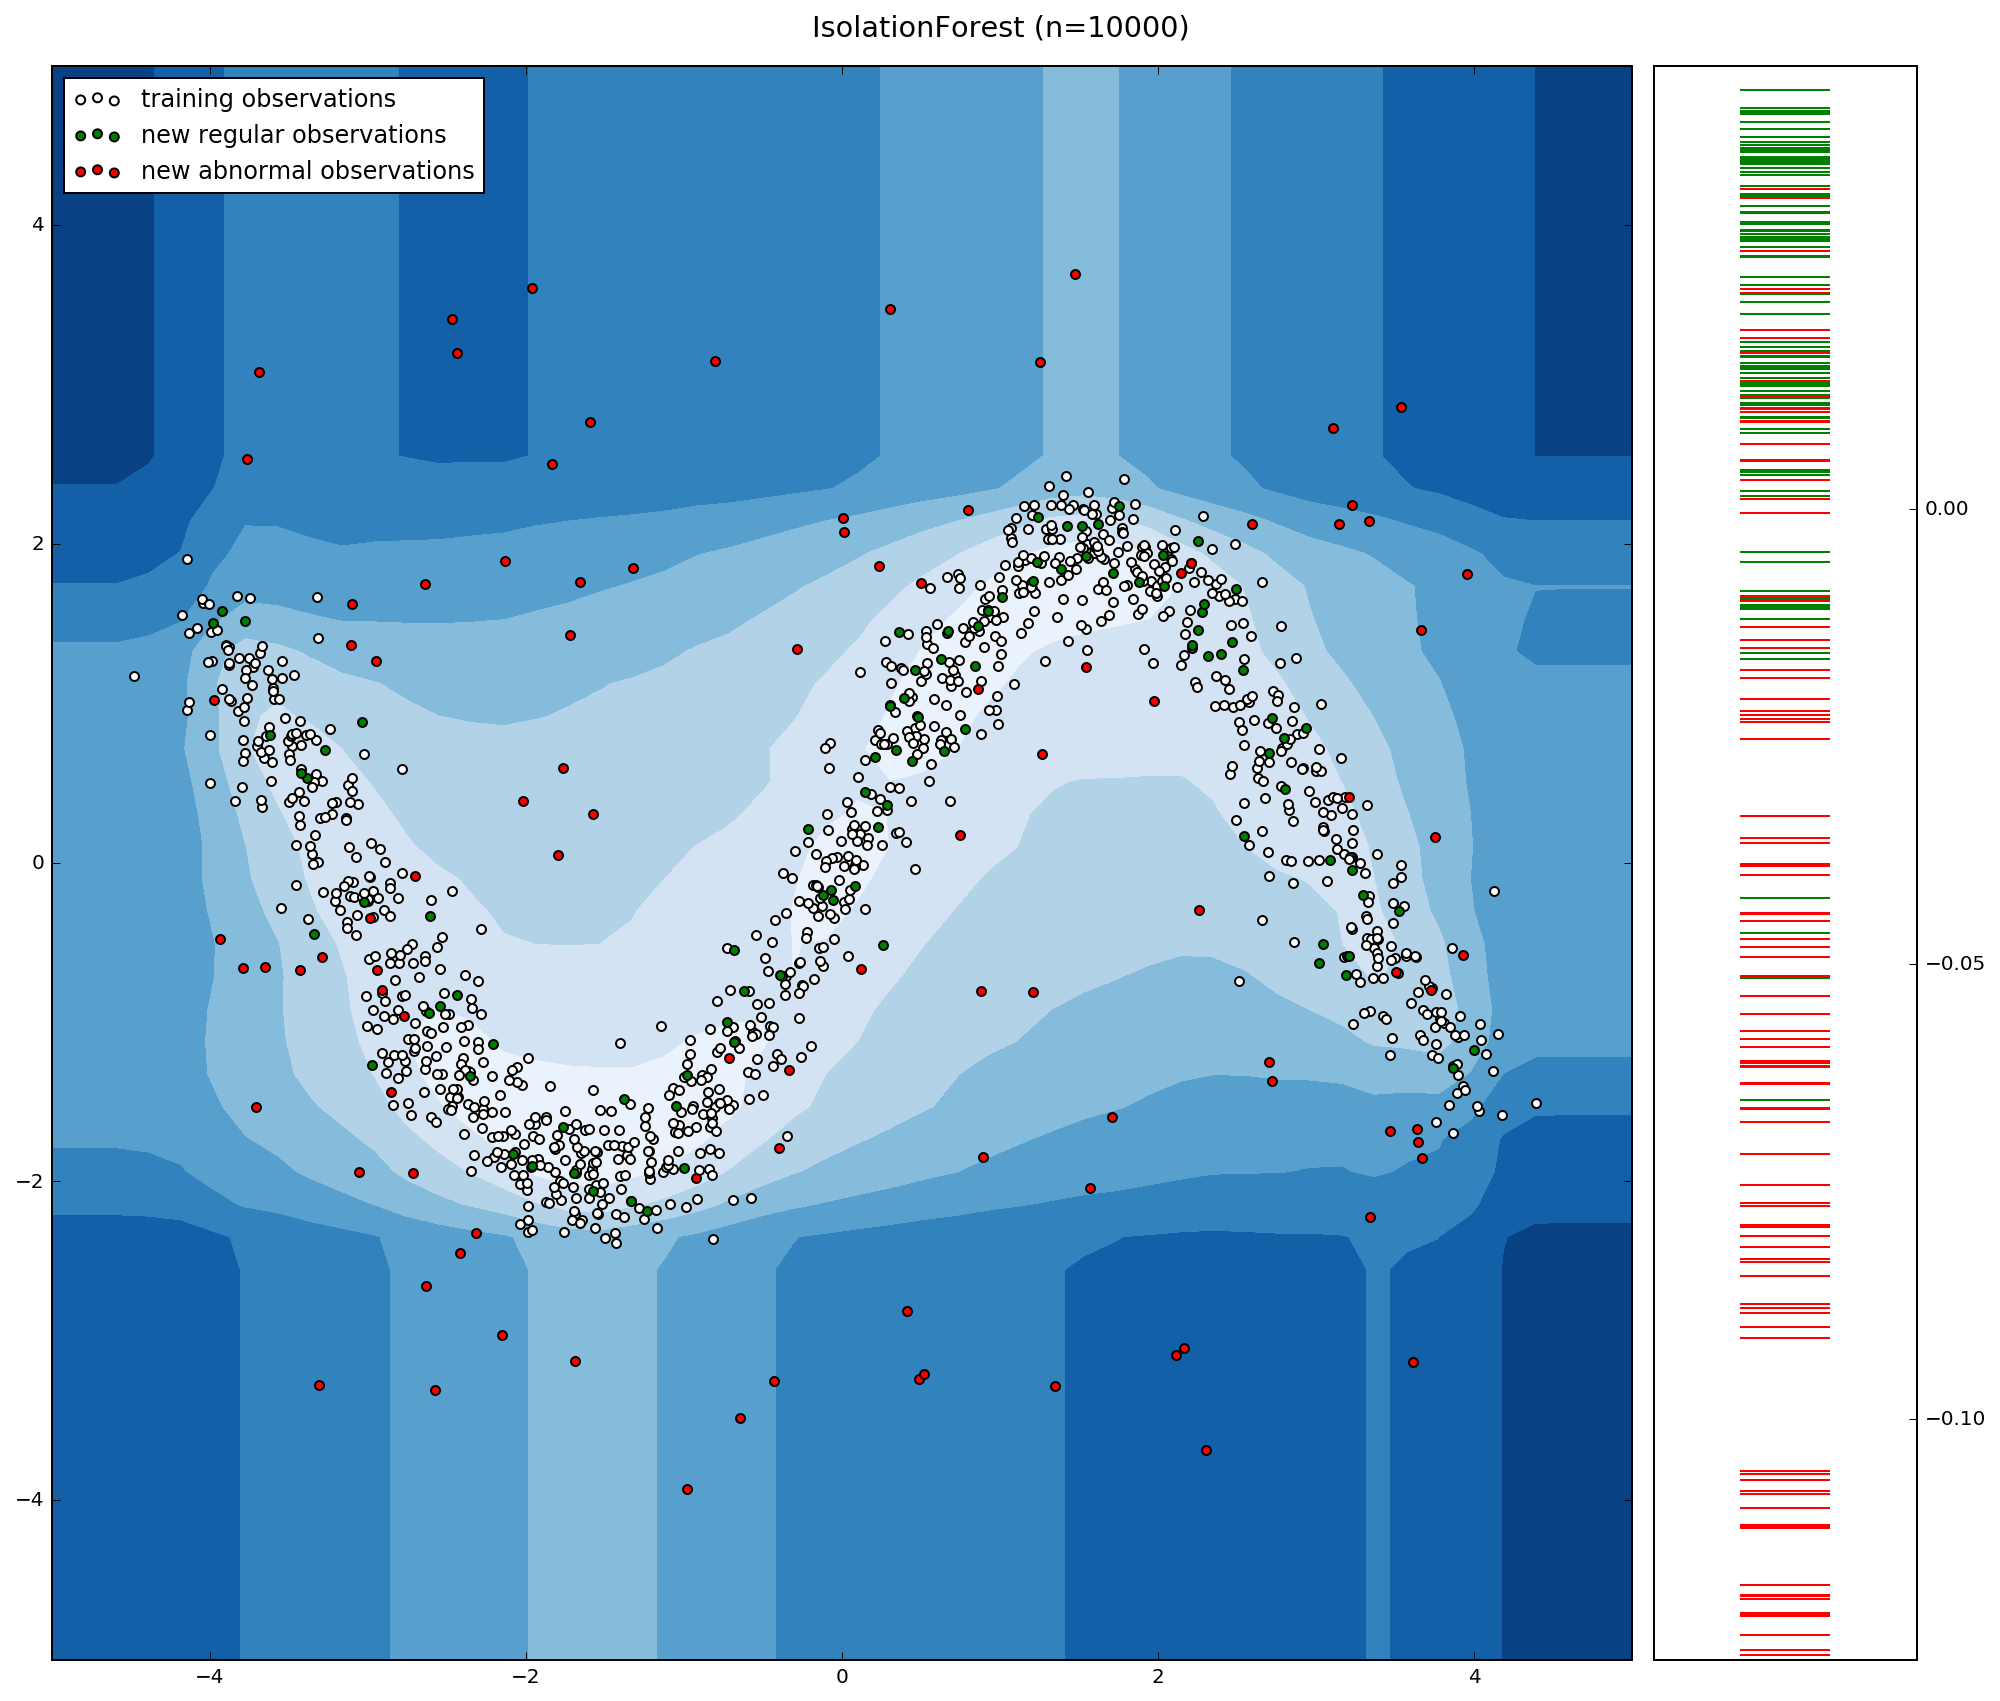

In [43]:
clf = IsolationForest(10000)
clf.fit(sin_train)
y_pred_train = clf.decision_function(sin_train)
y_pred_test = clf.decision_function(sin_test)
y_pred_outliers = clf.decision_function(sin_outliers)

print(score(y_pred_test, y_pred_outliers))
coolPlot("IsolationForest (n=10000)", clf.decision_function, sin_train, sin_test, sin_outliers)

0.9222


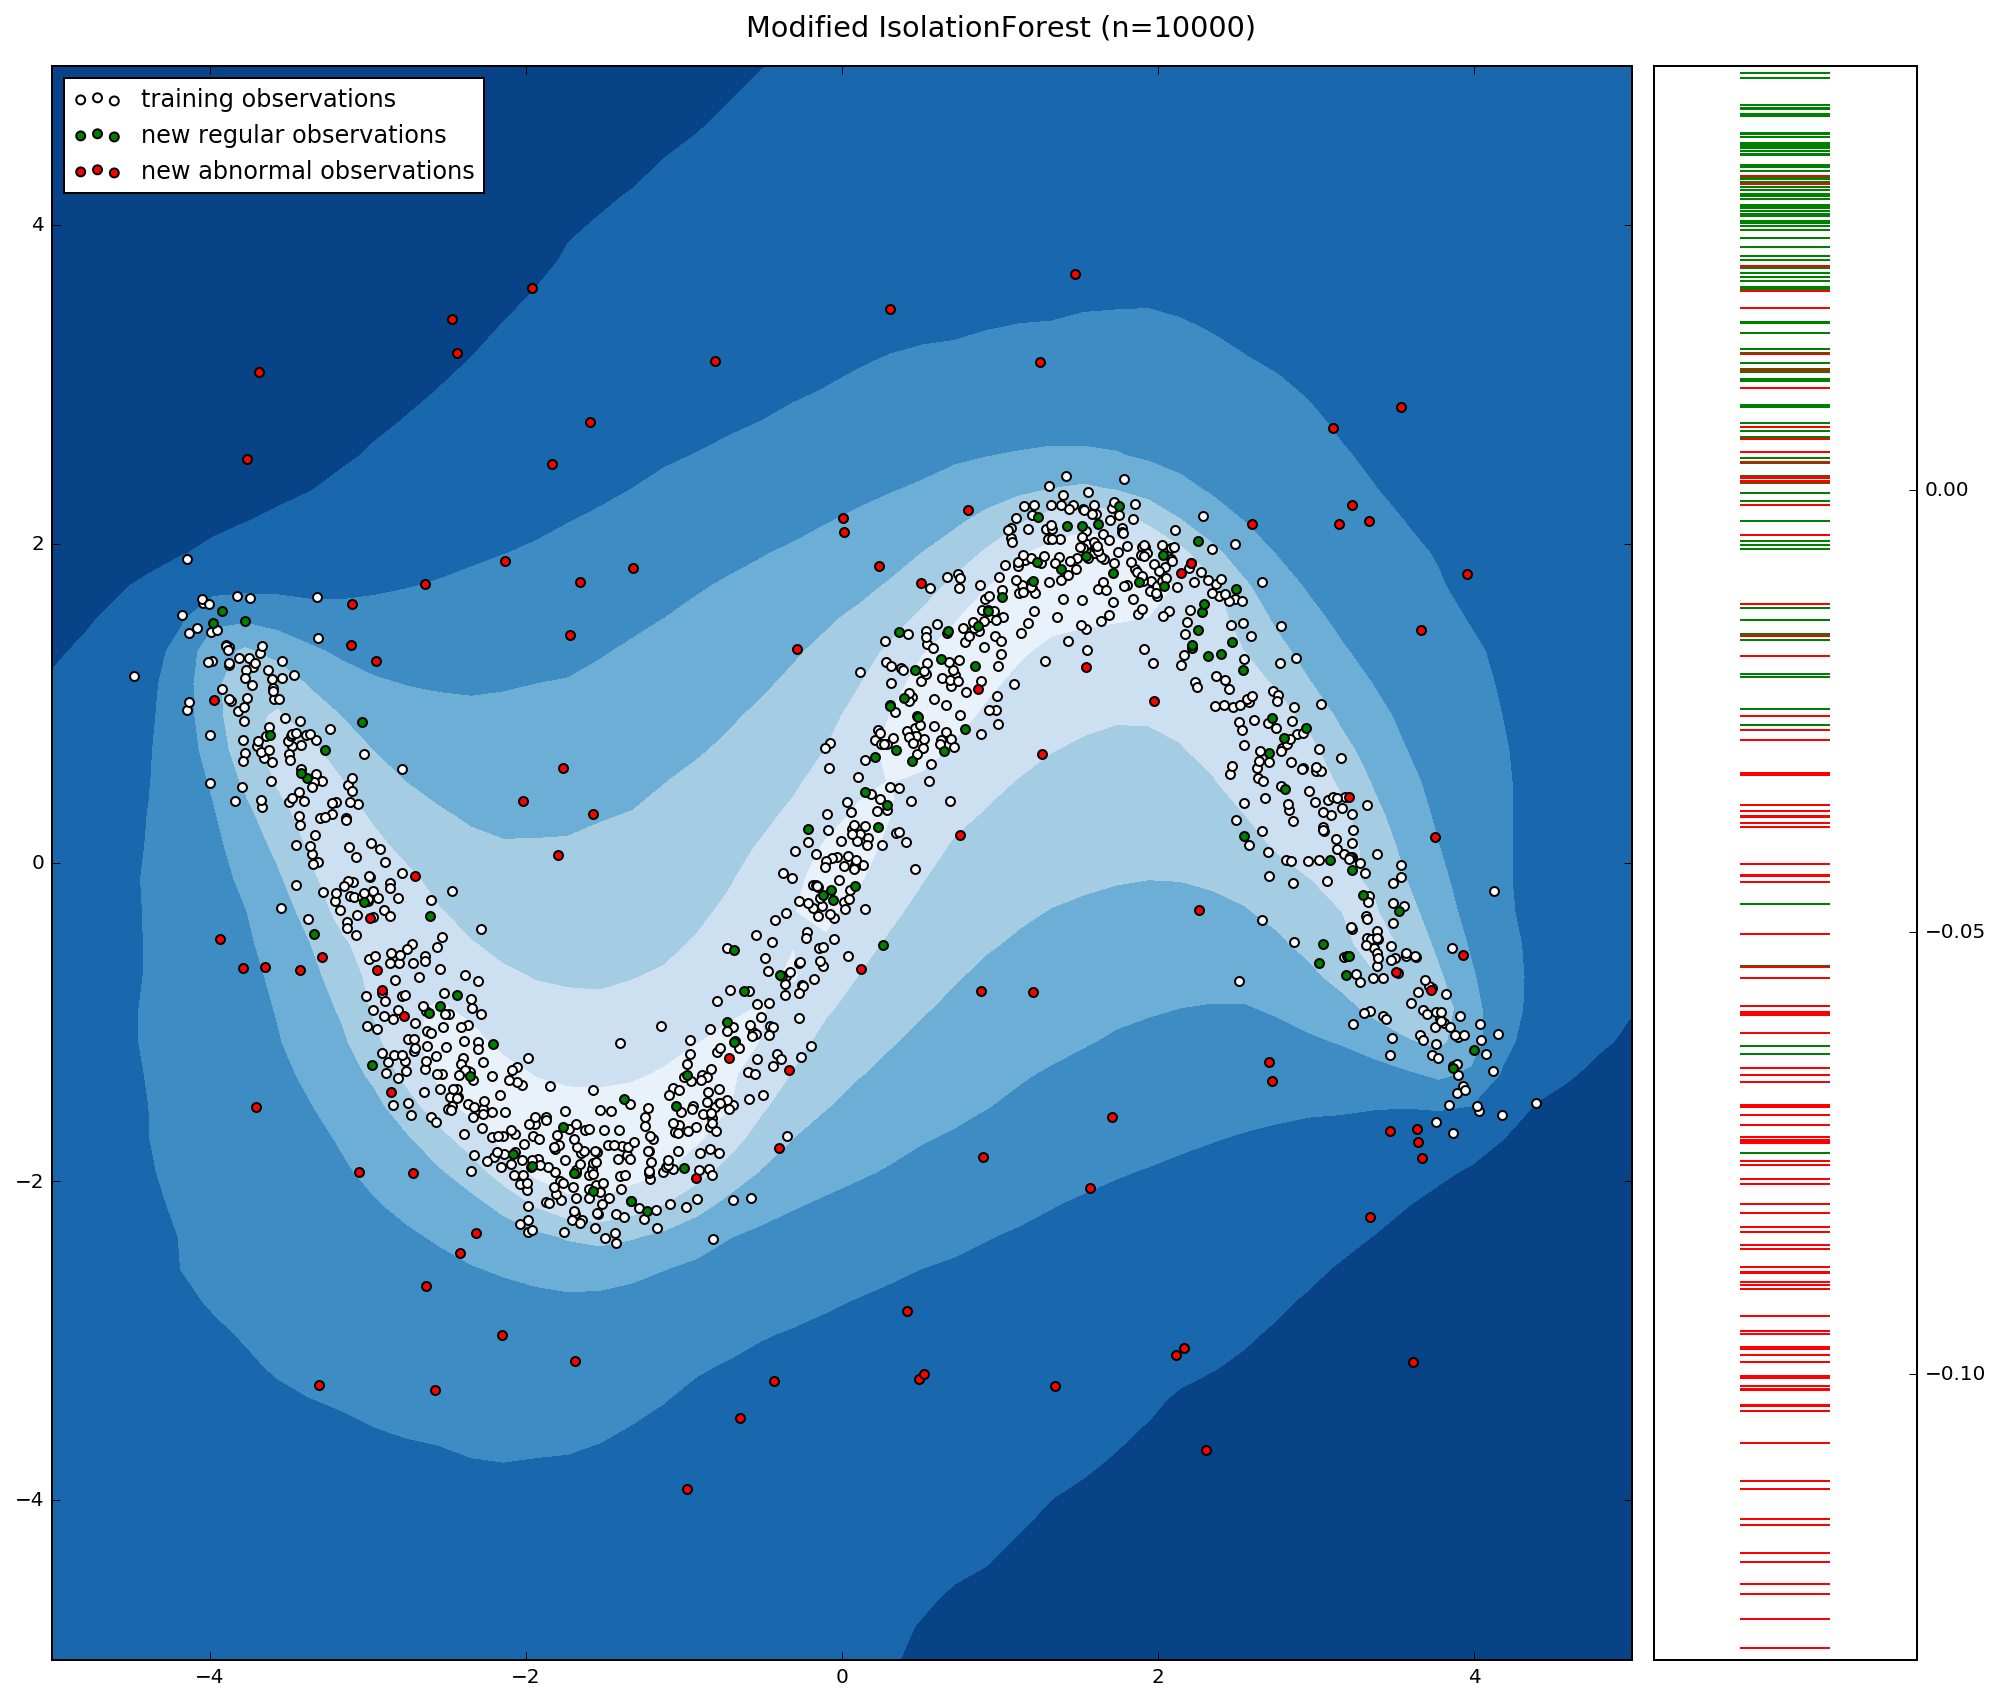

In [44]:
clf = modIsolationForest(10000)
clf.fit(sin_train)
y_pred_train = clf.decision_function(sin_train)
y_pred_test = clf.decision_function(sin_test)
y_pred_outliers = clf.decision_function(sin_outliers)

print(score(y_pred_test, y_pred_outliers))
coolPlot("Modified IsolationForest (n=10000)", clf.decision_function, sin_train, sin_test, sin_outliers)

Картинки мода красивее, потому что "вокруг" кластера границы расставлены правильнее, за счёт случайного расположения "уходящих на бесконечность полос". Разницы в приближении границы самого кластера вроде как и нет, хотя гладкую кривую модифицированному алгоритму приблизить легче - не нужно строить "лесенку".

Тем не менее, даёт ли такое изменение рост в качестве - непонятно, скорость сходимости могла измениться в обе стороны, а вот косяк с этими подозрительными полосами такой мод, похоже, исправляет, что по идее должно способствовать обобщающей способности.